Install python packages

In [1]:
# !pip3 install colpali-engine==0.3.1 vidore_benchmark==4.0.0 pdf2image google-generativeai pypdf==5.0.1 pyvespa vespacli requests

In [2]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from io import BytesIO

from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.utils.torch_utils import get_torch_device
from vidore_benchmark.utils.image_utils import scale_image, get_base64_image

## Load the model

This requires that the HF_TOKEN environment variable is set as the underlaying PaliGemma model is hosted on Hugging Face
and has a [restricive licence](https://ai.google.dev/gemma/terms) that requires authentication.

Choose the right device to run the model.

In [3]:
device = get_torch_device("auto")
if device == "cuda":
    dtype = torch.bfloat16
else:
    dtype = torch.float32

In [4]:
model_name = "vidore/colpali-v1.3"   #colpali-v1.2
model = ColPali.from_pretrained(model_name, torch_dtype=dtype, device_map=device).eval()
processor = ColPaliProcessor.from_pretrained(model_name)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Working with pdfs

We need to convert a PDF to an array of images. One image per page.
We will use pdf2image for this. Secondary, we also extract the text content of the pdf using pypdf.

NOTE: This step requires that you have `poppler` installed on your system. Read more in [pdf2image](https://pdf2image.readthedocs.io/en/latest/installation.html) docs.

In [5]:
import requests
from pdf2image import convert_from_path
from pypdf import PdfReader


def download_pdf(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BytesIO(response.content)
    else:
        raise Exception(f"Failed to download PDF: Status code {response.status_code}")


def get_pdf_images(pdf_url):
    # Download the PDF
    pdf_file = download_pdf(pdf_url)
    # Save the PDF temporarily to disk (pdf2image requires a file path)
    with open("temp.pdf", "wb") as f:
        f.write(pdf_file.read())
    reader = PdfReader("temp.pdf")
    page_texts = []
    for page_number in range(len(reader.pages)):
        page = reader.pages[page_number]
        text = page.extract_text()
        page_texts.append(text)
    images = convert_from_path("temp.pdf")
    assert len(images) == len(page_texts)
    return (images, page_texts)

We define a few sample PDFs to work with.

In [6]:
sample_pdfs = [
    # {
    #     "title": "ColBERTv2: Effective and Efficient Retrieval via Lightweight Late Interaction",
    #     "url": "https://arxiv.org/pdf/2112.01488.pdf",
    #     "authors": "Keshav Santhanam, Omar Khattab, Jon Saad-Falcon, Christopher Potts, Matei Zaharia",
    # },
    # {
    #     "title": "ColBERT: Efficient and Effective Passage Search via Contextualized Late Interaction over BERT",
    #     "url": "https://arxiv.org/pdf/2004.12832.pdf",
    #     "authors": "Omar Khattab, Matei Zaharia",
    # },
    {
        "title": "vkr-recsys",
        "url": "https://raw.githubusercontent.com/guggenheimg/VKR_RECSYS/main/%D0%92%D0%9A%D0%A0_%D0%A4%D1%80%D0%B8%D0%B7%D0%B5%D0%BD%D0%94%D0%9E.pdf",
        "authors": "qweqwe",
    },
]

Now we can convert the PDFs to images and also extract the text content.

In [7]:
for pdf in sample_pdfs:
    page_images, page_texts = get_pdf_images(pdf["url"])
    pdf["images"] = page_images
    pdf["texts"] = page_texts

Let us look at the extracted image of the first PDF page. This is the input to ColPali.

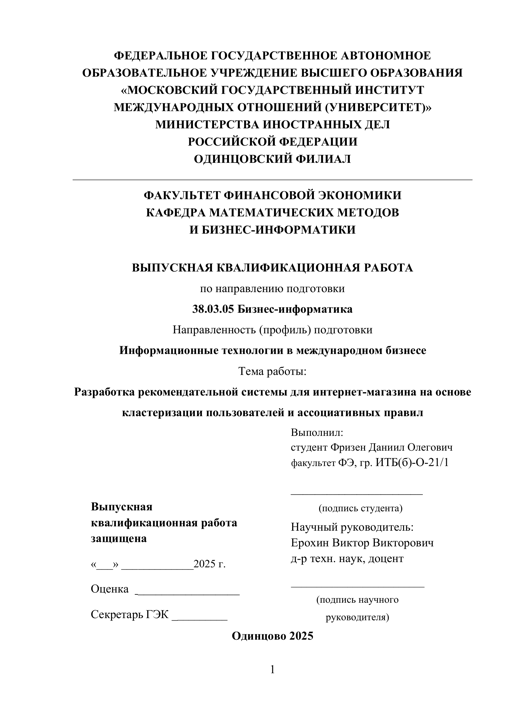

In [8]:
from IPython.display import display

display(scale_image(sample_pdfs[0]["images"][0], 720))

Now we use the ColPali model to generate embeddings for the images.

In [9]:
for pdf in sample_pdfs:
    page_embeddings = []
    dataloader = DataLoader(
        pdf["images"],
        batch_size=2,
        shuffle=False,
        collate_fn=lambda x: processor.process_images(x),
    )
    for batch_doc in tqdm(dataloader):
        with torch.no_grad():
            batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
            embeddings_doc = model(**batch_doc)
            # also handle if running on GPU
            if model.device == "cuda":
                embeddings_doc = embeddings_doc.float()
            page_embeddings.extend(list(torch.unbind(embeddings_doc.cpu())))
    pdf["embeddings"] = page_embeddings

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [19:57<00:00, 30.70s/it]


Now we are done with the document side embeddings, we now convert the custom dict to
[Vespa JSON feed](https://docs.vespa.ai/en/reference/document-json-format.html) format.


We use binarization of the vector embeddings to reduce their size. Read
more about binarization of multi-vector representations in the [colbert blog post](https://blog.vespa.ai/announcing-colbert-embedder-in-vespa/). This maps 128 dimensional floats to 128 bits, or 16 bytes per vector. Reducing
the size by 32x.

In [10]:
import numpy as np
from typing import Dict, List
from binascii import hexlify


def binarize_token_vectors_hex(vectors: List[torch.Tensor]) -> Dict[str, str]:
    vespa_tensor = list()
    for page_id in range(0, len(vectors)):
        page_vector = vectors[page_id]
        binarized_token_vectors = np.packbits(
            np.where(page_vector > 0, 1, 0), axis=1
        ).astype(np.int8)
        for patch_index in range(0, len(page_vector)):
            values = str(
                hexlify(binarized_token_vectors[patch_index].tobytes()), "utf-8"
            )
            if (
                values == "00000000000000000000000000000000"
            ):  # skip empty vectors due to padding of batch
                continue
            vespa_tensor_cell = {
                "address": {"page": page_id, "patch": patch_index},
                "values": values,
            }
            vespa_tensor.append(vespa_tensor_cell)

    return vespa_tensor

Iterate over the sample and create the Vespa JSON feed format, including the base64 encoded page images.

In [11]:
vespa_feed = []
for idx, pdf in enumerate(sample_pdfs):
    images_base_64 = []
    for image in pdf["images"]:
        images_base_64.append(get_base64_image(image, add_url_prefix=False))
    pdf["images_base_64"] = images_base_64
    doc = {
        "fields": {
            "url": pdf["url"],
            "title": pdf["title"],
            "images": pdf["images_base_64"],
            "texts": pdf["texts"],  # Array of text per page
            "colbert": {  # Colbert embeddings per page
                "blocks": binarize_token_vectors_hex(pdf["embeddings"])
            },
        }
    }
    vespa_feed.append(doc)

In [12]:
vespa_feed[0]["fields"]["colbert"]["blocks"][0:5]

[{'address': {'page': 0, 'patch': 0},
  'values': '76e4c08db33c998ed173bbdfd687e8e5'},
 {'address': {'page': 0, 'patch': 1},
  'values': '62ac8058a16d8d1e77db8aa7bea4aa84'},
 {'address': {'page': 0, 'patch': 2},
  'values': '66ac80c8a10b0d9f75ffeea6fba46286'},
 {'address': {'page': 0, 'patch': 3},
  'values': '66a498caa13d0f4ed75beda7bb8b60a6'},
 {'address': {'page': 0, 'patch': 4},
  'values': '67ae9859b5490f1efd5beea497a760a6'}]

Above is the feed format for mixed tensors with more than one mapped dimension, see [details](https://docs.vespa.ai/en/reference/constant-tensor-json-format.html#mixed-tensors). We have the `page` and `patch` dimensions and for each combination with have a binary representation of the 128 dimensional embeddings, packed into 16 bytes.

For each page image, we have 1030 patches, each with a 128 dimensional embedding.

## Configure Vespa
[PyVespa](https://vespa-engine.github.io/pyvespa/) helps us build the [Vespa application package](https://docs.vespa.ai/en/application-packages.html).
A Vespa application package consists of configuration files, schemas, models, and code (plugins).

First, we define a [Vespa schema](https://docs.vespa.ai/en/schemas.html) with the fields we want to store and their type.

In [13]:
from vespa.package import Schema, Document, Field, FieldSet

colbert_schema = Schema(
    name="doc",
    document=Document(
        fields=[
            Field(name="url", type="string", indexing=["summary"]),
            Field(
                name="title",
                type="string",
                indexing=["summary", "index"],
                index="enable-bm25",
            ),
            Field(
                name="texts",
                type="array<string>",
                indexing=["index"],
                index="enable-bm25",
            ),
            Field(
                name="images",
                type="array<string>",
                indexing=["summary"],
            ),
            Field(
                name="colbert",
                type="tensor<int8>(page{}, patch{}, v[16])",
                indexing=["attribute"],
            ),
        ]
    ),
    fieldsets=[FieldSet(name="default", fields=["title", "texts"])],
)

Notice the `colbert` field is a tensor field with the type `tensor(page{}, patch{}, v[128])`. This is the field that will store the embeddings generated by ColPali. This is an example of a mixed tensor where we combine two mapped (sparse) dimensions with one dense.

Read more in [Tensor guide](https://docs.vespa.ai/en/tensor-user-guide.html). We also enable [BM25](https://docs.vespa.ai/en/reference/bm25.html) for the `title` and `texts` fields.

Create the Vespa [application package](https://docs.vespa.ai/en/application-packages):

In [14]:
from vespa.package import ApplicationPackage

vespa_app_name = "visionrag"
vespa_application_package = ApplicationPackage(
    name=vespa_app_name, schema=[colbert_schema]
)

Now we define how we want to rank the pages. We use BM25 for the text and late interaction with Max Sim for the image embeddings.
This means that we retrieve using the text representations to find relevant PDF documents, then we use the ColPALI embeddings to rerank the pages within the document using the max of the page scores.

 We also return all the page level scores using `match-features`,  so that we can
render multiple scoring pages in the search result.

As LLMs gets longer context windows, we can input more than a single page per PDF.

In [15]:
from vespa.package import RankProfile, Function, FirstPhaseRanking, SecondPhaseRanking

colbert_profile = RankProfile(
    name="default",
    inputs=[("query(qt)", "tensor<float>(querytoken{}, v[128])")],
    functions=[
        Function(
            name="max_sim_per_page",
            expression="""
                sum(
                    reduce(
                        sum(
                            query(qt) * unpack_bits(attribute(colbert)) , v
                        ),
                        max, patch
                    ),
                    querytoken
                )
            """,
        ),
        Function(name="max_sim", expression="reduce(max_sim_per_page, max, page)"),
        Function(name="bm25_score", expression="bm25(title) + bm25(texts)"),
    ],
    first_phase=FirstPhaseRanking(expression="bm25_score"),
    second_phase=SecondPhaseRanking(expression="max_sim", rerank_count=10),
    match_features=["max_sim_per_page", "bm25_score"],
)
colbert_schema.add_rank_profile(colbert_profile)

## Деплой vespa с помощью docker


Если vespa деплоиться в первый раз, то выполни следующее:

In [16]:
# import os
# # В папке ноутбука лежит папка .\visionrag\ . Там находяться файлы необходимые для деплоя Vespa поэтому укажите ваш путь до этой папки в следующей переменной
# os.environ["APP"] = pass # os Path + "\visionrag\"

In [17]:
# !docker run -d --name vespa -m 4g --cpus=2 -p 8080:8080 -p 19071:19071 -v "${env:APP}:/vespa-app" vespaengine/vespa:8

In [18]:
# !docker exec vespa vespa-deploy prepare /vespa-app

In [19]:
# !docker exec vespa vespa-deploy activate

Если vespa деплоится повторно

In [20]:
!docker start vespa && docker exec vespa /opt/vespa/bin/vespa-start-services

vespa
Starting config proxy using tcp/localhost:19070 as config source(s)
Waiting for config proxy to start on '7890c95ba12d'
config proxy started after 0s (runserver pid 123)
Starting services for VESPA_HOSTNAME='7890c95ba12d'


could not lock pidfile var/run/configproxy.pid: Resource temporarily unavailable
var/run/configproxy.pid: Resource temporarily unavailable
runserver(config-sentinel) already running with pid 238


In [21]:
!docker ps -a

CONTAINER ID   IMAGE                 COMMAND                  CREATED       STATUS        PORTS                                              NAMES
7890c95ba12d   vespaengine/vespa:8   "/usr/local/bin/starвЂ¦"   8 hours ago   Up 1 second   0.0.0.0:8080->8080/tcp, 0.0.0.0:19071->19071/tcp   vespa


In [22]:
!docker exec vespa /opt/vespa/bin/vespa-start-services

Starting config proxy using tcp/localhost:19070 as config source(s)
Waiting for config proxy to start on '7890c95ba12d'
config proxy started after 0s (runserver pid 123)
Starting services for VESPA_HOSTNAME='7890c95ba12d'


runserver(configproxy) already running with pid 123
runserver(config-sentinel) already running with pid 238


Нужно ждать примерно 20 сек до полноценного деплоя

In [23]:
!powershell -Command "Start-Sleep -Seconds 60"

Проверка статуса приложения

In [24]:
!docker exec vespa curl -f http://localhost:8080/ApplicationStatus

{

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 24885    0 24885    0     0   207k      0 --:--:-- --:--:-- --:--:--  207k



  "application" : {
    "vespa" : {
      "version" : "8.524.25"
    },
    "meta" : {
      "name" : "default",
      "user" : "unknown",
      "path" : "",
      "generation" : 2,
      "timestamp" : 1748259215783,
      "date" : "Mon May 26 11:33:35 UTC 2025",
      "checksum" : "8ce2b20bab563a0083a00179d868866e"
    },
    "user" : {
      "version" : ""
    }
  },
  "abstractComponents" : [ {
    "id" : "com.yahoo.prelude.querytransform.CJKSearcher@visionrag_content",
    "class" : "com.yahoo.prelude.querytransform.CJKSearcher",
    "bundle" : "container-search-and-docproc:8.524.25"
  }, {
    "id" : "com.yahoo.container.logging.FileConnectionLog",
    "class" : "com.yahoo.container.logging.FileConnectionLog",
    "bundle" : "container-disc:8.524.25"
  }, {
    "id" : "com.yahoo.search.searchers.ValidateNearestNeighborSearcher@visionrag_content",
    "class" : "com.yahoo.search.searchers.ValidateNearestNeighborSearcher",
    "bundle" : "container-search-and-docproc:8.524.25"
  },

## Vespa feeding
Предполагается что веспа запущена локально через docker на URL http://localhost:8080

In [25]:
from vespa.io import VespaResponse
from vespa.application import Vespa


vespa_endpoint = "http://localhost:8080"

# разбиваем на host и port
from urllib.parse import urlparse
_parsed = urlparse(vespa_endpoint)
host = f"{_parsed.scheme}://{_parsed.hostname}"
port = _parsed.port or (443 if _parsed.scheme=="https" else 80)

# создаём клиент
vespa = Vespa(url=host, port=port)

In [26]:
with vespa.syncio() as sync:
        for op in tqdm(vespa_feed, desc="Feeding Vespa", ncols=80):
            resp: VespaResponse = sync.feed_data_point(
                data_id=op["fields"]["url"],
                fields=op["fields"],
                schema="doc"
            )
            if not resp.is_successful():
                print("Error feeding:", resp.json())

Feeding Vespa: 100%|██████████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Validate that certificates are ok and deploy the application to Vespa Cloud.

## Querying Vespa (проверка)

Ok, so now we have indexed the PDF pages in Vespa. Let us now obtain ColPali embeddings for a text query and
use it to match against the indexed PDF pages.

Our demo query:

_Composition of the Lotte Benchmark_

In [27]:
# queries = ["Composition of the LoTTE benchmark"]
queries = ["описание алгоритма Apriori"]

Obtain the query embeddings using the ColPali model

In [28]:
dataloader = DataLoader(
    queries,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda x: processor.process_queries(x),
)
qs = []
for batch_query in dataloader:
    with torch.no_grad():
        batch_query = {k: v.to(model.device) for k, v in batch_query.items()}
        embeddings_query = model(**batch_query)
        # also handle if running on GPU
        if model.device == "cuda":
            embeddings_query = embeddings_query.float()
        qs.extend(list(torch.unbind(embeddings_query.cpu())))

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


A simple routine to format the ColPali multi-vector emebeddings to a format that can be used in Vespa.
See [querying with tensors](https://docs.vespa.ai/en/tensor-user-guide.html#querying-with-tensors) for more details.

In [29]:
def float_query_token_vectors(vectors: torch.Tensor) -> Dict[str, List[float]]:
    vespa_token_dict = dict()
    for index in range(0, len(vectors)):
        vespa_token_dict[index] = vectors[index].tolist()
    return vespa_token_dict

We create a simple routine to display the results.

Notice that each hit is a PDF document. Within a PDF document
we have multiple pages and we have the MaxSim score for each page.

The PDF documents are ranked by the maximum page score. But, we have access to all the page level scores and
below we display the top 2-pages for each PDF document. We convert the base64 encoded image to a PIL image
for rendering. We could also render the extracted text, but we skip that for now.

In [30]:
from IPython.display import display, HTML
import base64


def display_query_results(query, response):
    """
    Displays the query result, including the two best matching pages per matched pdf.
    """
    html_content = f"<h3>Query text: {query}</h3>"

    for i, hit in enumerate(response.hits[:2]):  # Adjust to show more hits if needed
        title = hit["fields"]["title"]
        url = hit["fields"]["url"]
        match_scores = hit["fields"]["matchfeatures"]["max_sim_per_page"]
        images = hit["fields"]["images"]

        html_content += f"<h3>PDF Result {i + 1}</h3>"
        html_content += f'<p><strong>Title:</strong> <a href="{url}">{title}</a></p>'

        # Find the two best matching pages
        sorted_pages = sorted(match_scores.items(), key=lambda x: x[1], reverse=True)
        best_pages = sorted_pages[:2]

        for page, score in best_pages:
            page = int(page)
            image_data = base64.b64decode(images[page])
            image = Image.open(BytesIO(image_data))
            scaled_image = scale_image(image, 648)

            buffered = BytesIO()
            scaled_image.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode()

            html_content += f"<p><strong>Best Matching Page {page+1} for PDF document:</strong> with MaxSim score {score:.2f}</p>"
            html_content += (
                f'<img src="data:image/png;base64,{img_str}" style="max-width:100%;">'
            )

    display(HTML(html_content))

Query Vespa with a text query and display the results.


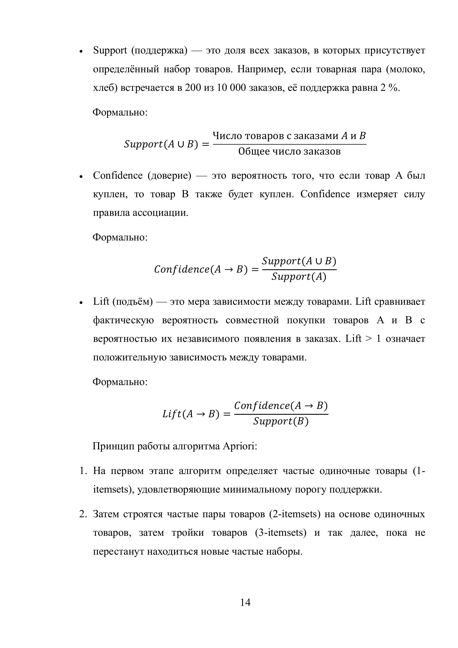
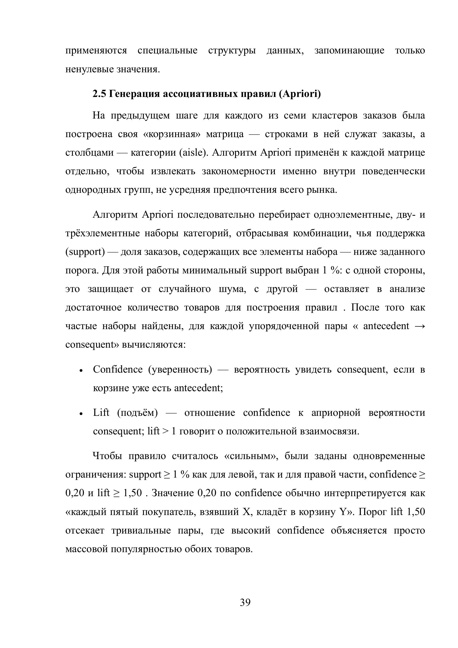

In [31]:
from vespa.io import VespaQueryResponse

for idx, query in enumerate(queries):
    response: VespaQueryResponse = vespa.query(
        yql="select title,url,images from doc where userInput(@userQuery)",
        ranking="default",
        userQuery=query,
        timeout=2,
        hits=3,
        body={
            "presentation.format.tensors": "short-value",
            "input.query(qt)": float_query_token_vectors(qs[idx]),
        },
    )
    assert response.is_successful()
    display_query_results(query, response)

# AI агент семантического поиса

    ollama run gemma3:4b-it-q4_K_M
    docker start vespa
    docker exec vespa /opt/vespa/bin/vespa-start-services

In [1]:
import base64
import requests
import torch
from torch.utils.data import DataLoader
from vespa.io import VespaQueryResponse
from IPython.display import display, HTML
from io import BytesIO
from PIL import Image
from colpali_engine.models import ColPali, ColPaliProcessor
from tqdm import tqdm
from vespa.application import Vespa

# Настройки
OLLAMA_ENDPOINT = "http://localhost:11434/api/generate"
MODEL_NAME = "gemma3:4b-it-q4_K_M"
MAX_CLARIFICATIONS = 2
VESPA_TIMEOUT = 2
VESPA_HITS = 3
vespa_endpoint = "http://localhost:8080"

# разбиваем на host и port
from urllib.parse import urlparse
_parsed = urlparse(vespa_endpoint)
host = f"{_parsed.scheme}://{_parsed.hostname}"
port = _parsed.port or (443 if _parsed.scheme=="https" else 80)

# создаём клиент
vespa = Vespa(url=host, port=port)

if not globals().get("model"):
    model = ColPali.from_pretrained("vidore/colpali-v1.3")
    processor = ColPaliProcessor.from_pretrained("vidore/colpali-v1.3")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model.to(device)


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
def query_gemma_multimodal(prompt: str, images_b64: list[str]=None, system: str="") -> str:
    payload = {"model": MODEL_NAME, "prompt": prompt, "stream": False}
    if images_b64: payload["images"] = images_b64
    if system:     payload["system"] = system
    resp = requests.post(OLLAMA_ENDPOINT, json=payload)
    resp.raise_for_status()
    return resp.json().get("response", "").strip()

def float_query_token_vectors(vectors: torch.Tensor) -> dict[int, list[float]]:
    return {i: vec.tolist() for i, vec in enumerate(vectors)}

def embed_queries(queries: list[str]) -> list[torch.Tensor]:
    loader = DataLoader(
        queries,
        batch_size=1,
        shuffle=False,
        collate_fn=lambda x: processor.process_queries(x)
    )
    embeddings = []
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            out = model(**batch)
            if device.type == "cuda": out = out.float()
        embeddings.extend(torch.unbind(out.cpu()))
    return embeddings

def fetch_from_vespa(query: str, embedding: torch.Tensor) -> VespaQueryResponse:
    return vespa.query(
        yql="select title,url,images,matchfeatures from doc where userInput(@userQuery)",
        ranking="default",
        userQuery=query,
        timeout=VESPA_TIMEOUT,
        hits=VESPA_HITS,
        body={
            "presentation.format.tensors": "short-value",
            "input.query(qt)": float_query_token_vectors(embedding)
        }
    )

def extract_images(response: VespaQueryResponse, top_k: int = 2) -> list[str]:
    """
    Возвращает top_k base64-изображений с наивысшими max_sim_per_page 
    по всем hit-ам в ответе Vespa.
    """
    # Собираем все (image, score)
    img_score_pairs = []
    for hit in response.hits[:2]:
        scores = hit["fields"]["matchfeatures"]["max_sim_per_page"]
        for page_str, score in scores.items():
            img = hit["fields"]["images"][int(page_str)]
            img_score_pairs.append((img, score))
    # Сортируем глобально по убыванию score
    sorted_pairs = sorted(img_score_pairs, key=lambda x: x[1], reverse=True)
    # Берём top_k изображений
    return [img for img, _ in sorted_pairs[:top_k]]

def display_query_results(query, response):
    """
    Displays the query result with a max-width wrapper to constrain output width.
    """
    # Начинаем обёртку
    html = '<div style="max-width:720px; margin:auto; max-height:1080px">'
    html += f"<h3>Query text: {query}</h3>"
    
    for i, hit in enumerate(response.hits[:3]):
        title = hit["fields"]["title"]
        url   = hit["fields"]["url"]
        html += f"<h4>{i+1}. <a href='{url}' target='_blank'>{title}</a></h4>"

        # Сортируем страницы по убыванию max_sim_per_page
        scores = hit["fields"]["matchfeatures"]["max_sim_per_page"]
        top_pages = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
        for page_str, score in top_pages:
            page = int(page_str)
            img_b64 = hit["fields"]["images"][page]
            html += f"<p>Page {page+1}: score {score:.2f}</p>"
            html += (
                f"<img src='data:image/png;base64,{img_b64}' "
                "style='width:100%; height:auto; display:block; margin-bottom:16px;'>"
            )
    # Закрываем обёртку
    html += "</div>"

    # Корректный вызов без лишних аргументов
    display(HTML(html))


In [3]:
def decompose_query(user_query: str) -> list[str]:
    """
    Разбивает составной запрос на 2 подзапроса, если в нём есть 'и' или 'или'.
    Если LLM не справляется — используется ручной fallback по шаблону.
    """
    lower = user_query.lower()

    # 1. Простейшая защита от простых запросов
    if " и " not in lower and " или " not in lower:
        return [user_query]

    # 2. Попробуем вызвать Gemma
    try:
        prompt = (
            "Ты — ассистент, который разбивает вопрос на независимые подзапросы. "
            "Разбивай ТОЛЬКО по словам 'и' или 'или'. "
            "Верни только список подзапросов, каждый с новой строки и с маркером '- '. "
            "Если это один вопрос — верни его как один пункт.\n\n"
            f"Вопрос: {user_query}"
        )
        result = query_gemma_multimodal(prompt).strip()
        print(result)
        parts = [line.lstrip("- ").strip() for line in result.splitlines() if line.startswith("- ")]

        # если модель не дала два подзапроса — fallback
        if len(parts) < 2:
            raise ValueError("LLM не дал корректную декомпозицию")

        return parts
    except:
        # 3. Ручной fallback: по шаблону «X и Y»
        split_match = re.split(r"\s+(?:и|или)\s+", user_query, maxsplit=1)
        if len(split_match) == 2:
            return [s.strip().capitalize() for s in split_match]
        return [user_query]

def evaluate_images_for_query(user_query: str, images_b64: list[str]) -> (bool, str):
    """
    Возвращает (ok, resp). ok=False, если ответ слишком короткий
    или содержит фразы об отсутствии данных.
    """
    prompt = (
        "На основании прикреплённых изображений, ответь на запрос:\n"
        f"«{user_query}»\n\n"
        "Если на изображениях есть однозначный ответ — верни его. "
        "Если нет — верни фразу 'точная информация отсутствует'."
    )
    resp = query_gemma_multimodal(prompt, images_b64).strip()
    low = resp.lower()

    # 1) Пустой или очень короткий ответ
    words = low.split()
    if len(words) < 3:
        return False, resp

    # 2) Фразы об отсутствии информации
    absence_phrases = [
        "нет информации",
        "не представлено",
        "не содержится",
        "точная информация отсутствует",
        "не могу найти"
    ]
    if any(phrase in low for phrase in absence_phrases):
        return False, resp

    # 3) Если первая строка — уже вопрос (Gemma решила уточнить)
    if words[0] in ("что","как","почему","где","когда","зачем","сколько"):
        return False, resp

    # Во всех остальных случаях считаем ответ полным
    return True, resp


def summarize_answers_with_gemma(answers: list[str]) -> str:
    """
    Принимает список ответов на подзапросы и возвращает единый
    связный ответ в одном стиле, используя Gemma.
    """
    # Собираем ответы в единый блок
    combined = "\n\n".join(f"- {ans}" for ans in answers)
    prompt = (
        "Ты — ассистент, который объединяет фрагменты ответов на подзапросы "
        "в один связный, цельный ответ в едином стиле и тоне.\n\n"
        "Фрагменты ответов:\n"
        f"{combined}\n\n"
        "Сформируй исчерпывающее сводное объяснение так, "
        "будто это один полный ответ на исходный запрос."
    )
    # Вызываем Gemma (только текст, без изображений)
    return query_gemma_multimodal(prompt)



In [4]:
def process_query_with_gemma_vespa(user_query: str):
    clarifications = 0
    current = user_query

    while clarifications <= MAX_CLARIFICATIONS + 1:
        # 1) Декомпозиция
        subs = decompose_query(current)
        collected_answers = []
        embs = embed_queries(subs)
        
        # 2) По каждому подзапросу
        for idx, sub in enumerate(subs):
            vespa_resp = fetch_from_vespa(sub, embs[idx])
            display_query_results(sub, vespa_resp)
            imgs = extract_images(vespa_resp)

            ok, out = evaluate_images_for_query(sub, imgs)
            if ok:
                print(f"\nОтвет на «{sub}»:\n{out}\n")
                collected_answers.append(f"Ответ на «{sub}»: {out}")
            else:
                # Уточнение
                print(f"⚠ Gemma уточняет: {out}\n")
                current = input("Пожалуйста, уточните запрос: ")
                clarifications += 1
                break
        else:
            # Если цикл завершился без уточнений:
            if len(collected_answers) > 1:
                # 3) Суммируем в единый ответ
                summary = summarize_answers_with_gemma(collected_answers)
                print("\n📦 Итоговый объединённый ответ:\n", summary)
            else:
                # Если был один подзапрос, просто выводим его ответ
                print("\n📦 Итоговый ответ:\n", collected_answers[0])
            return

    print("🚫 Превышено число уточнений. Завершаем.")


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


- Описание алгоритма Apriori
- Как рассчитать support
- Как рассчитать confidence
- Как рассчитать lift


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



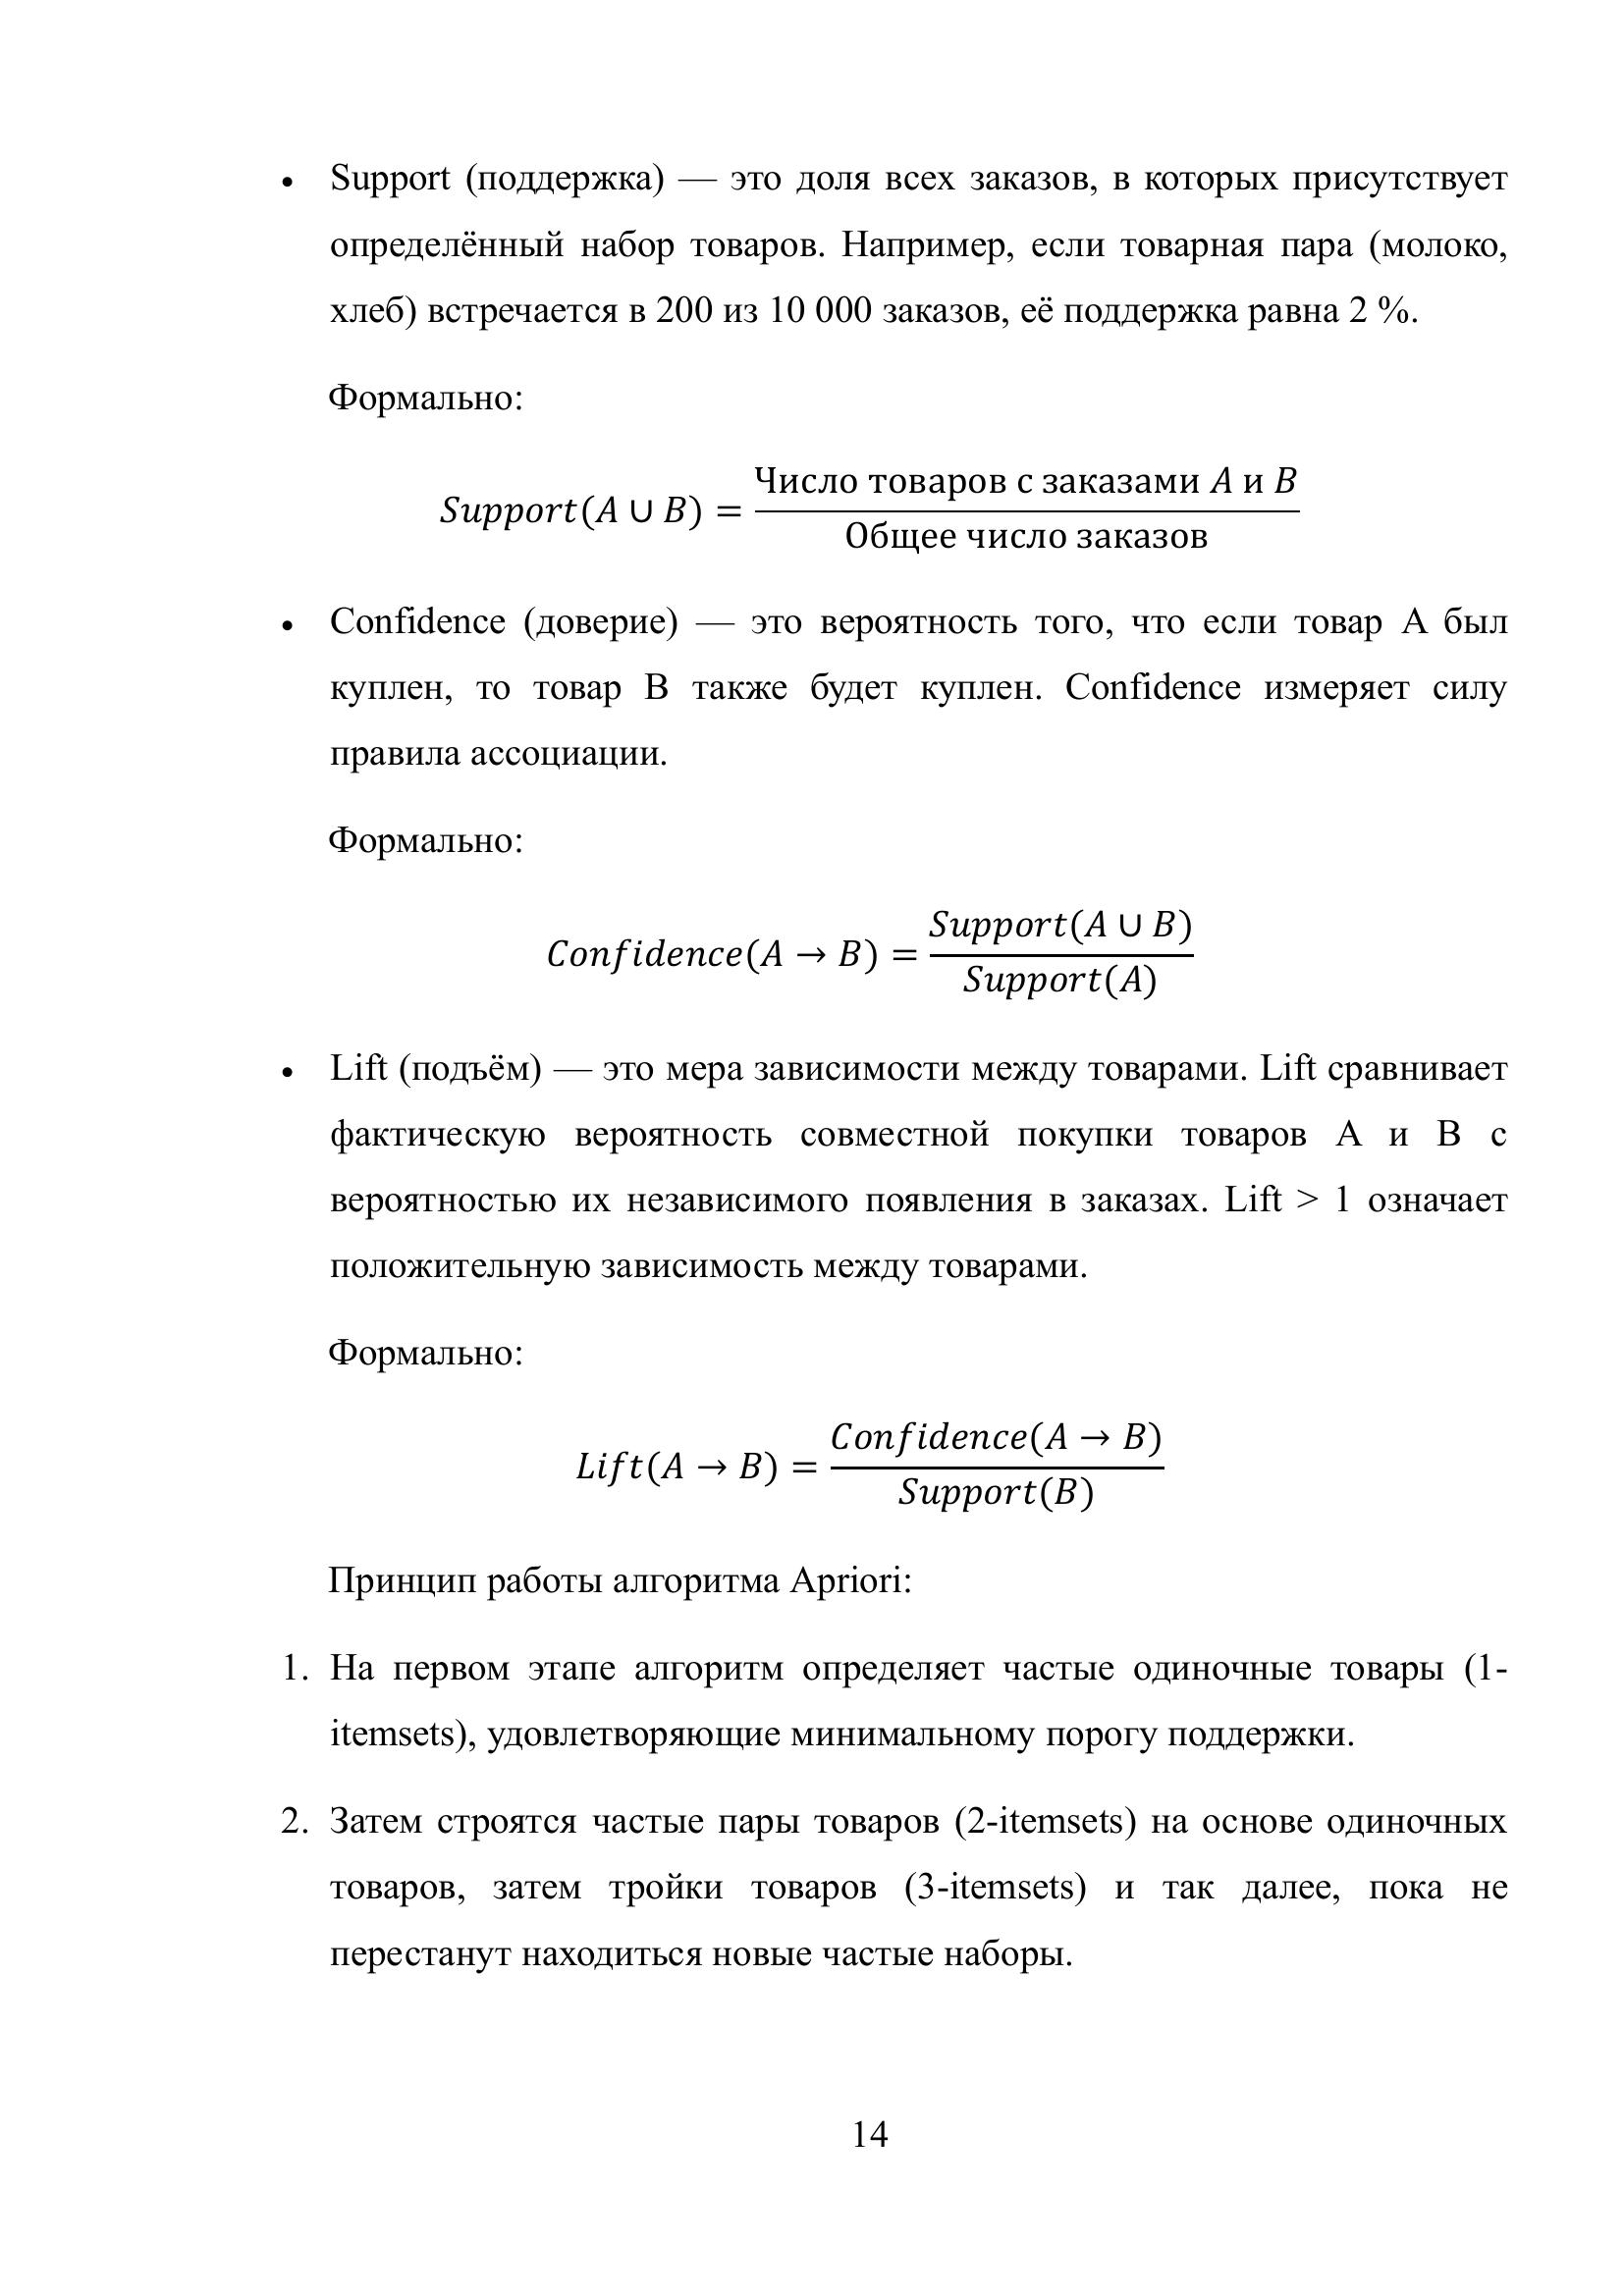
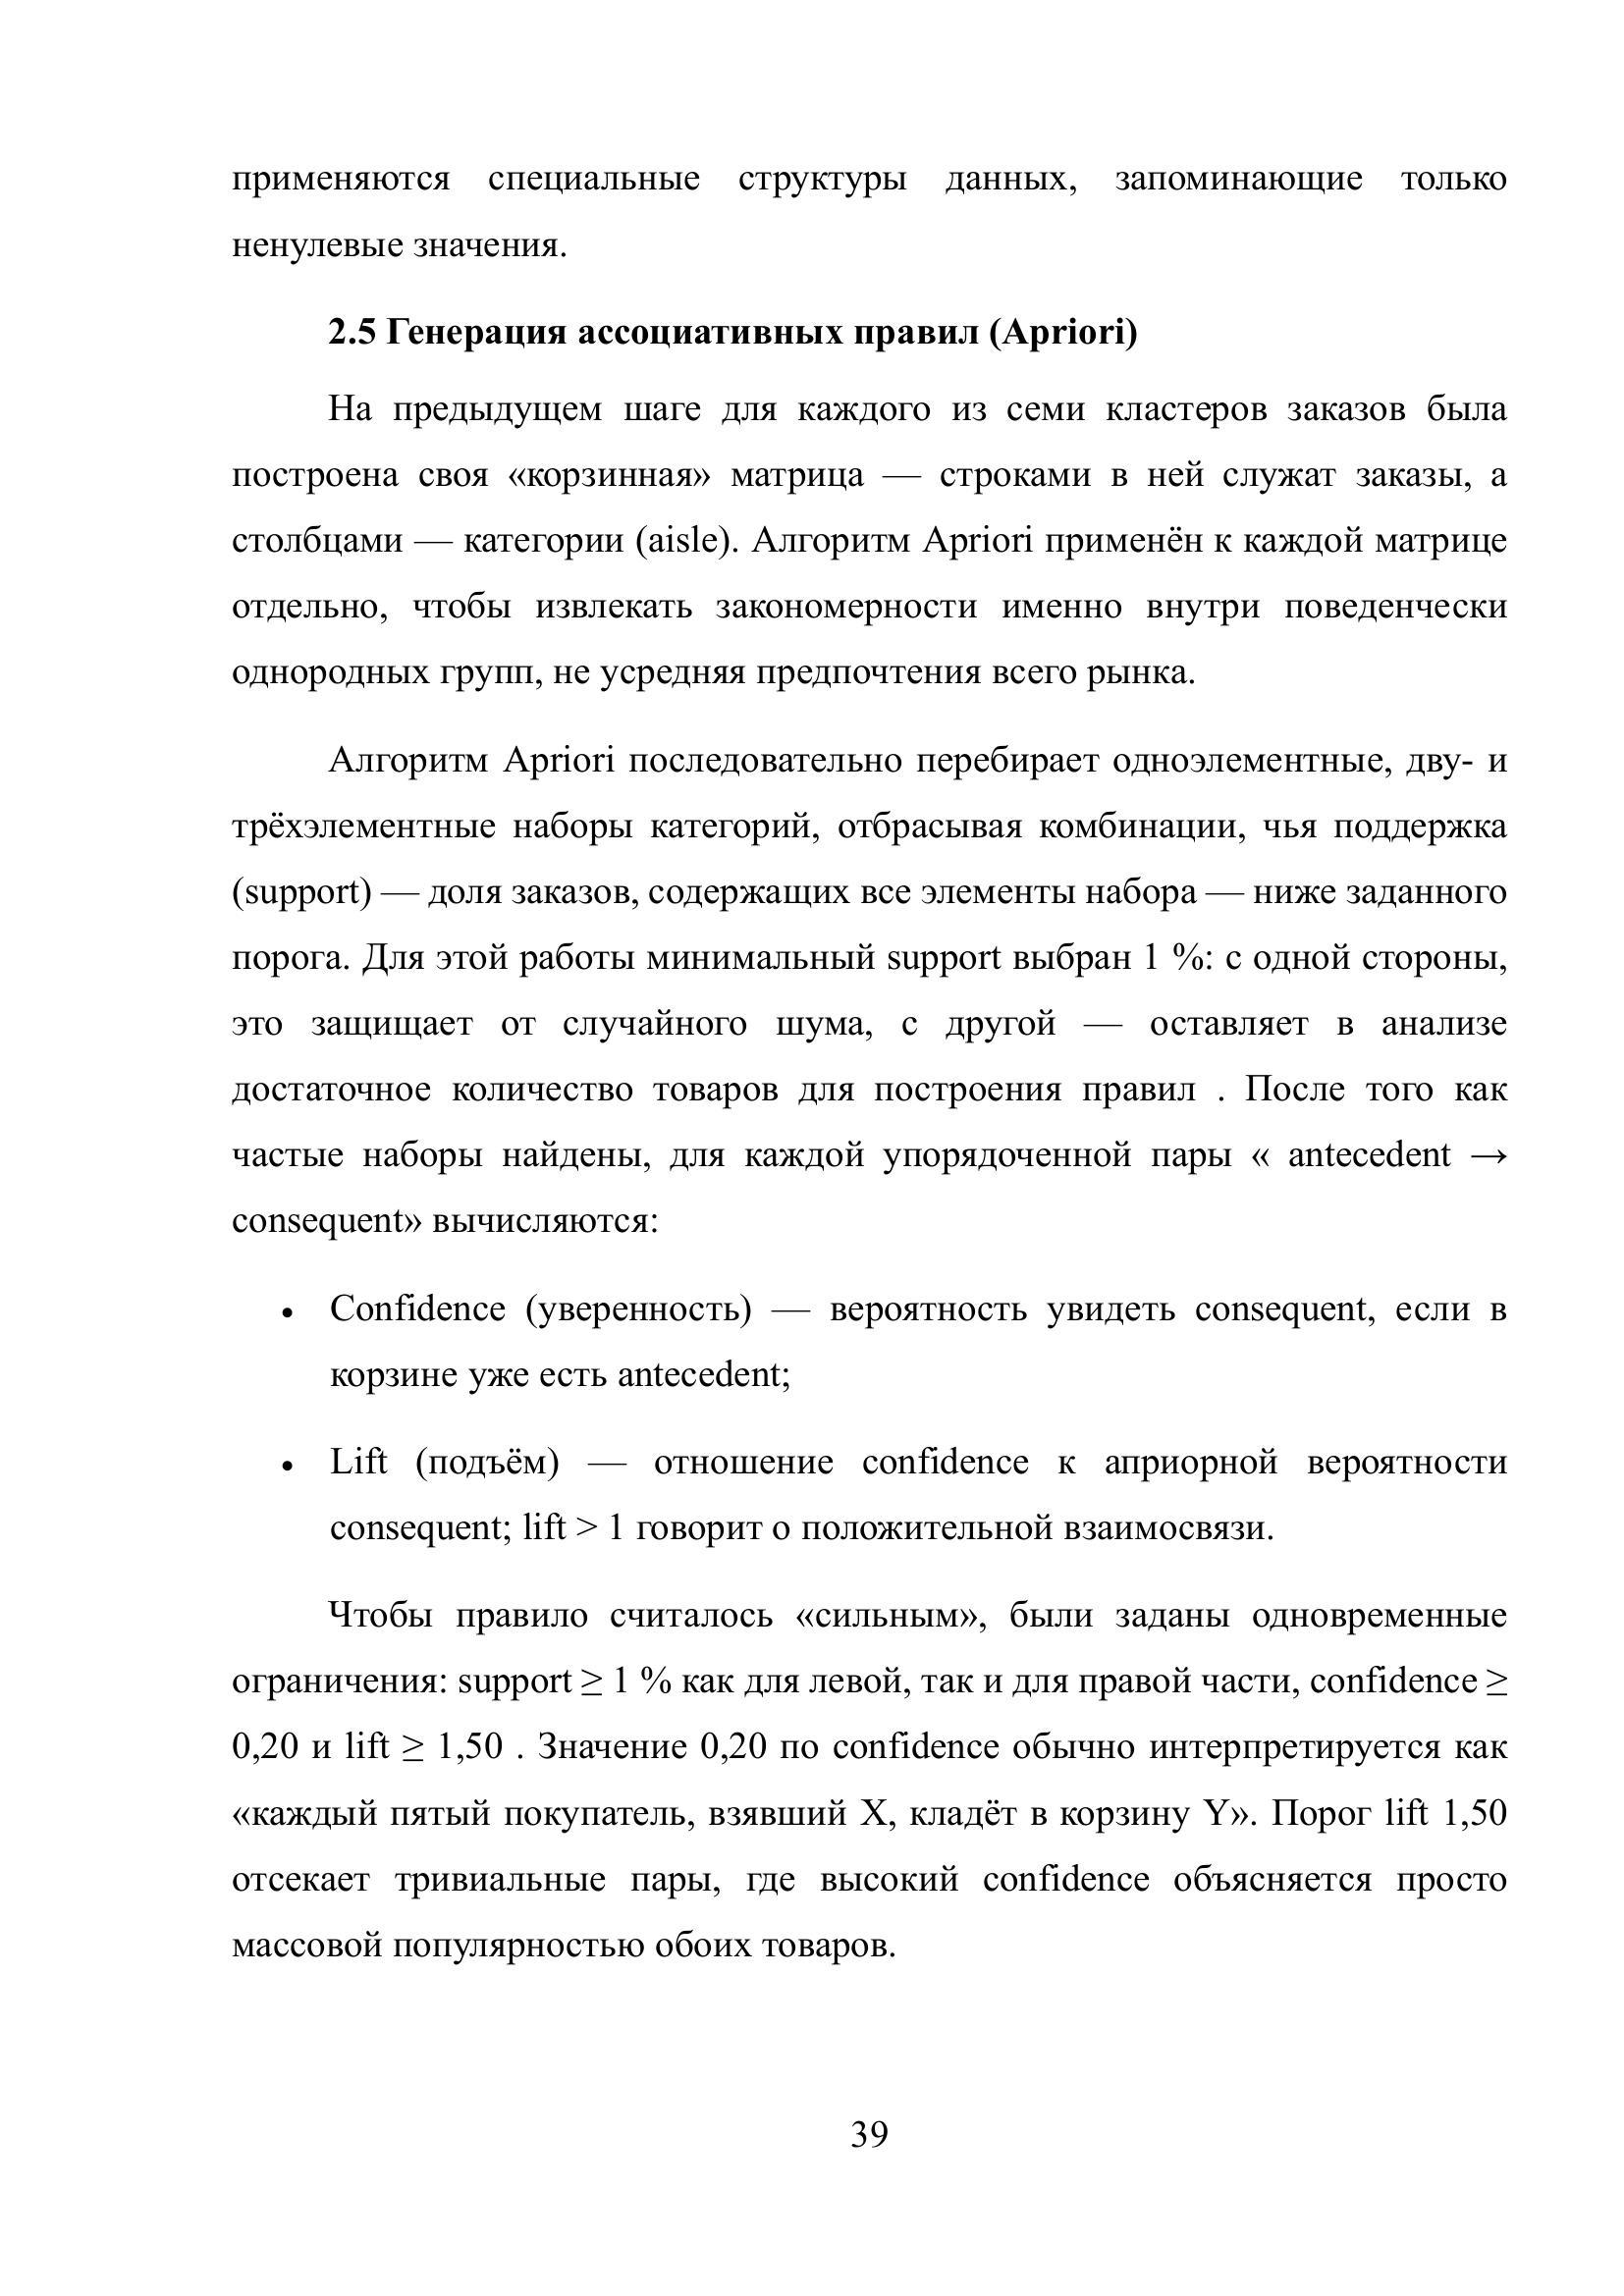
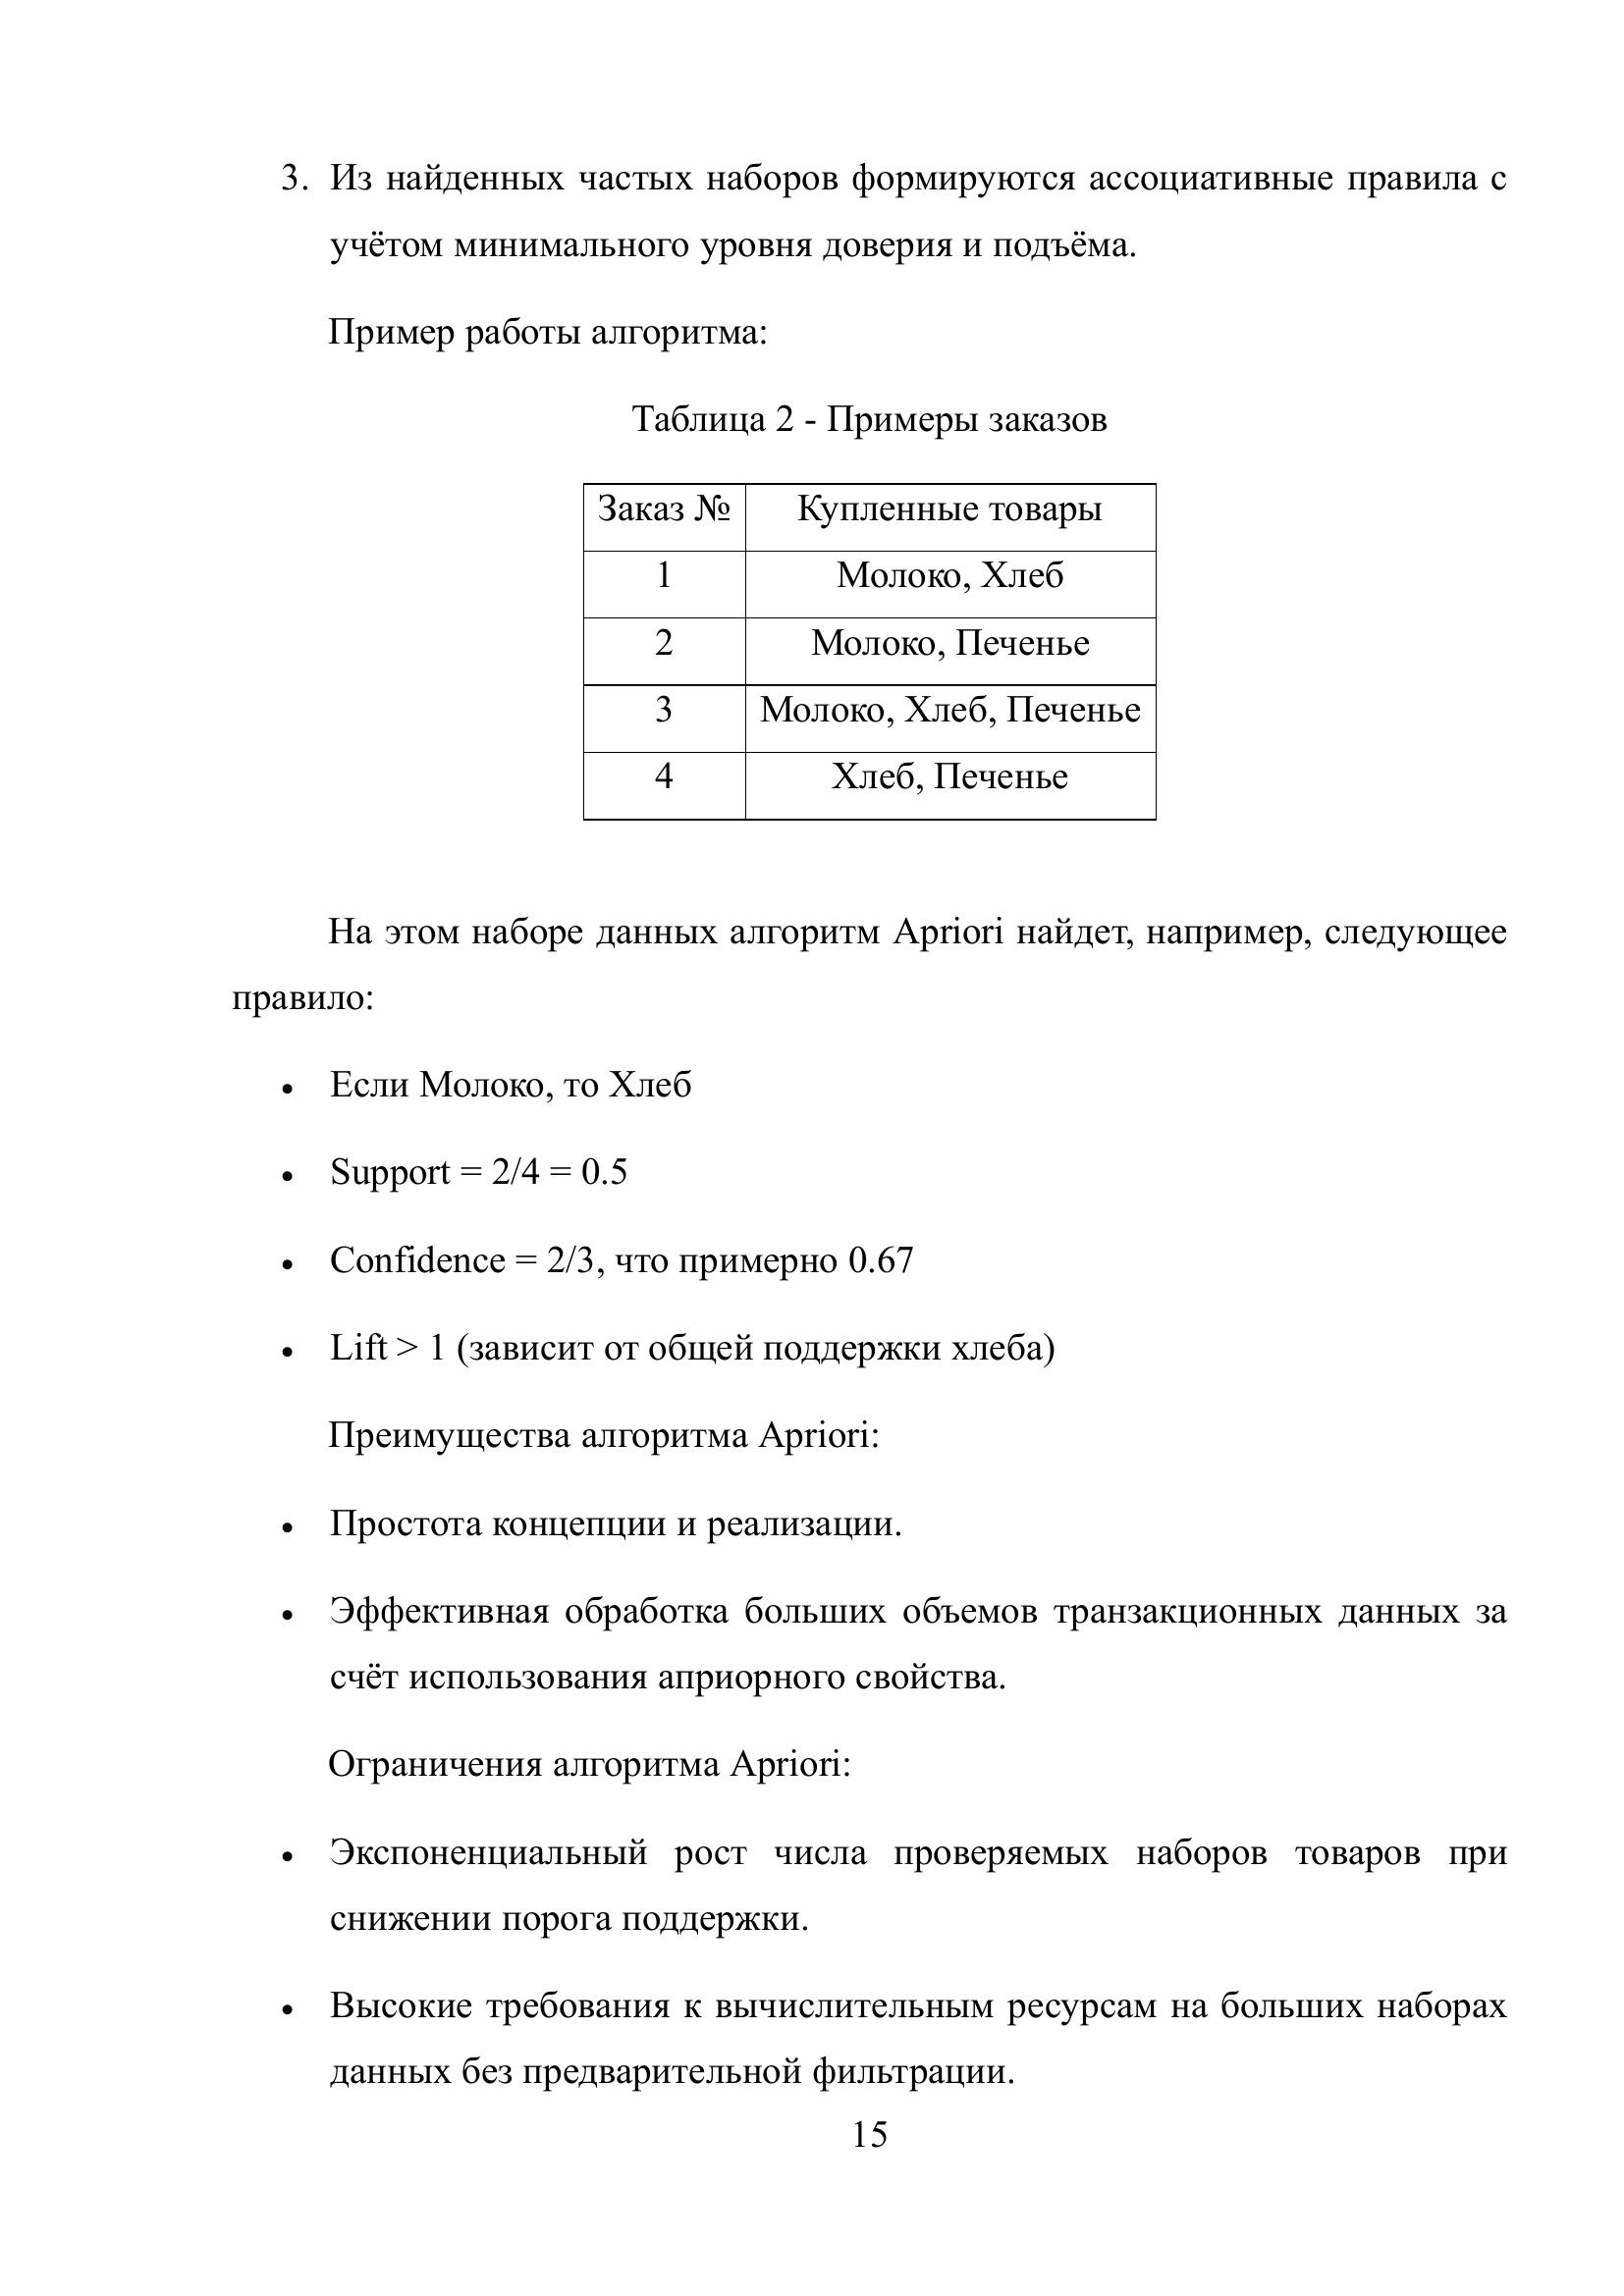


Ответ на «Описание алгоритма Apriori»:
Вот описание алгоритма Apriori, основанное на предоставленных изображениях:

**Принцип работы алгоритма Apriori:**

1.  На первом этапе алгоритм определяет частые одиночные товары (1-itemsets), удовлетворяющие минимальному порогу поддержки.
2.  Затем строятся частые пары товаров (2-itemsets) на основе одиночных товаров, затем тройки товаров (3-itemsets) и так далее, пока не перестанут находиться новые частые наборы.

**Показатели алгоритма:**

*   **Support (поддержка)** - это доля всех заказов, в которых присутствует определенный набор товаров.
*   **Confidence (доверие)** - это вероятность того, что если товар B был куплен, то товар A также будет куплен. Confidence измеряет силу правила ассоциации.
*   **Lift (подъем)** - это мера зависимости между товарами. Lift сравнивает фактическую вероятность покупки товаров A и B с вероятностью их независимого появления в заказах. Lift > 1 означает положительную зависимость между товарами.

    *   Значен


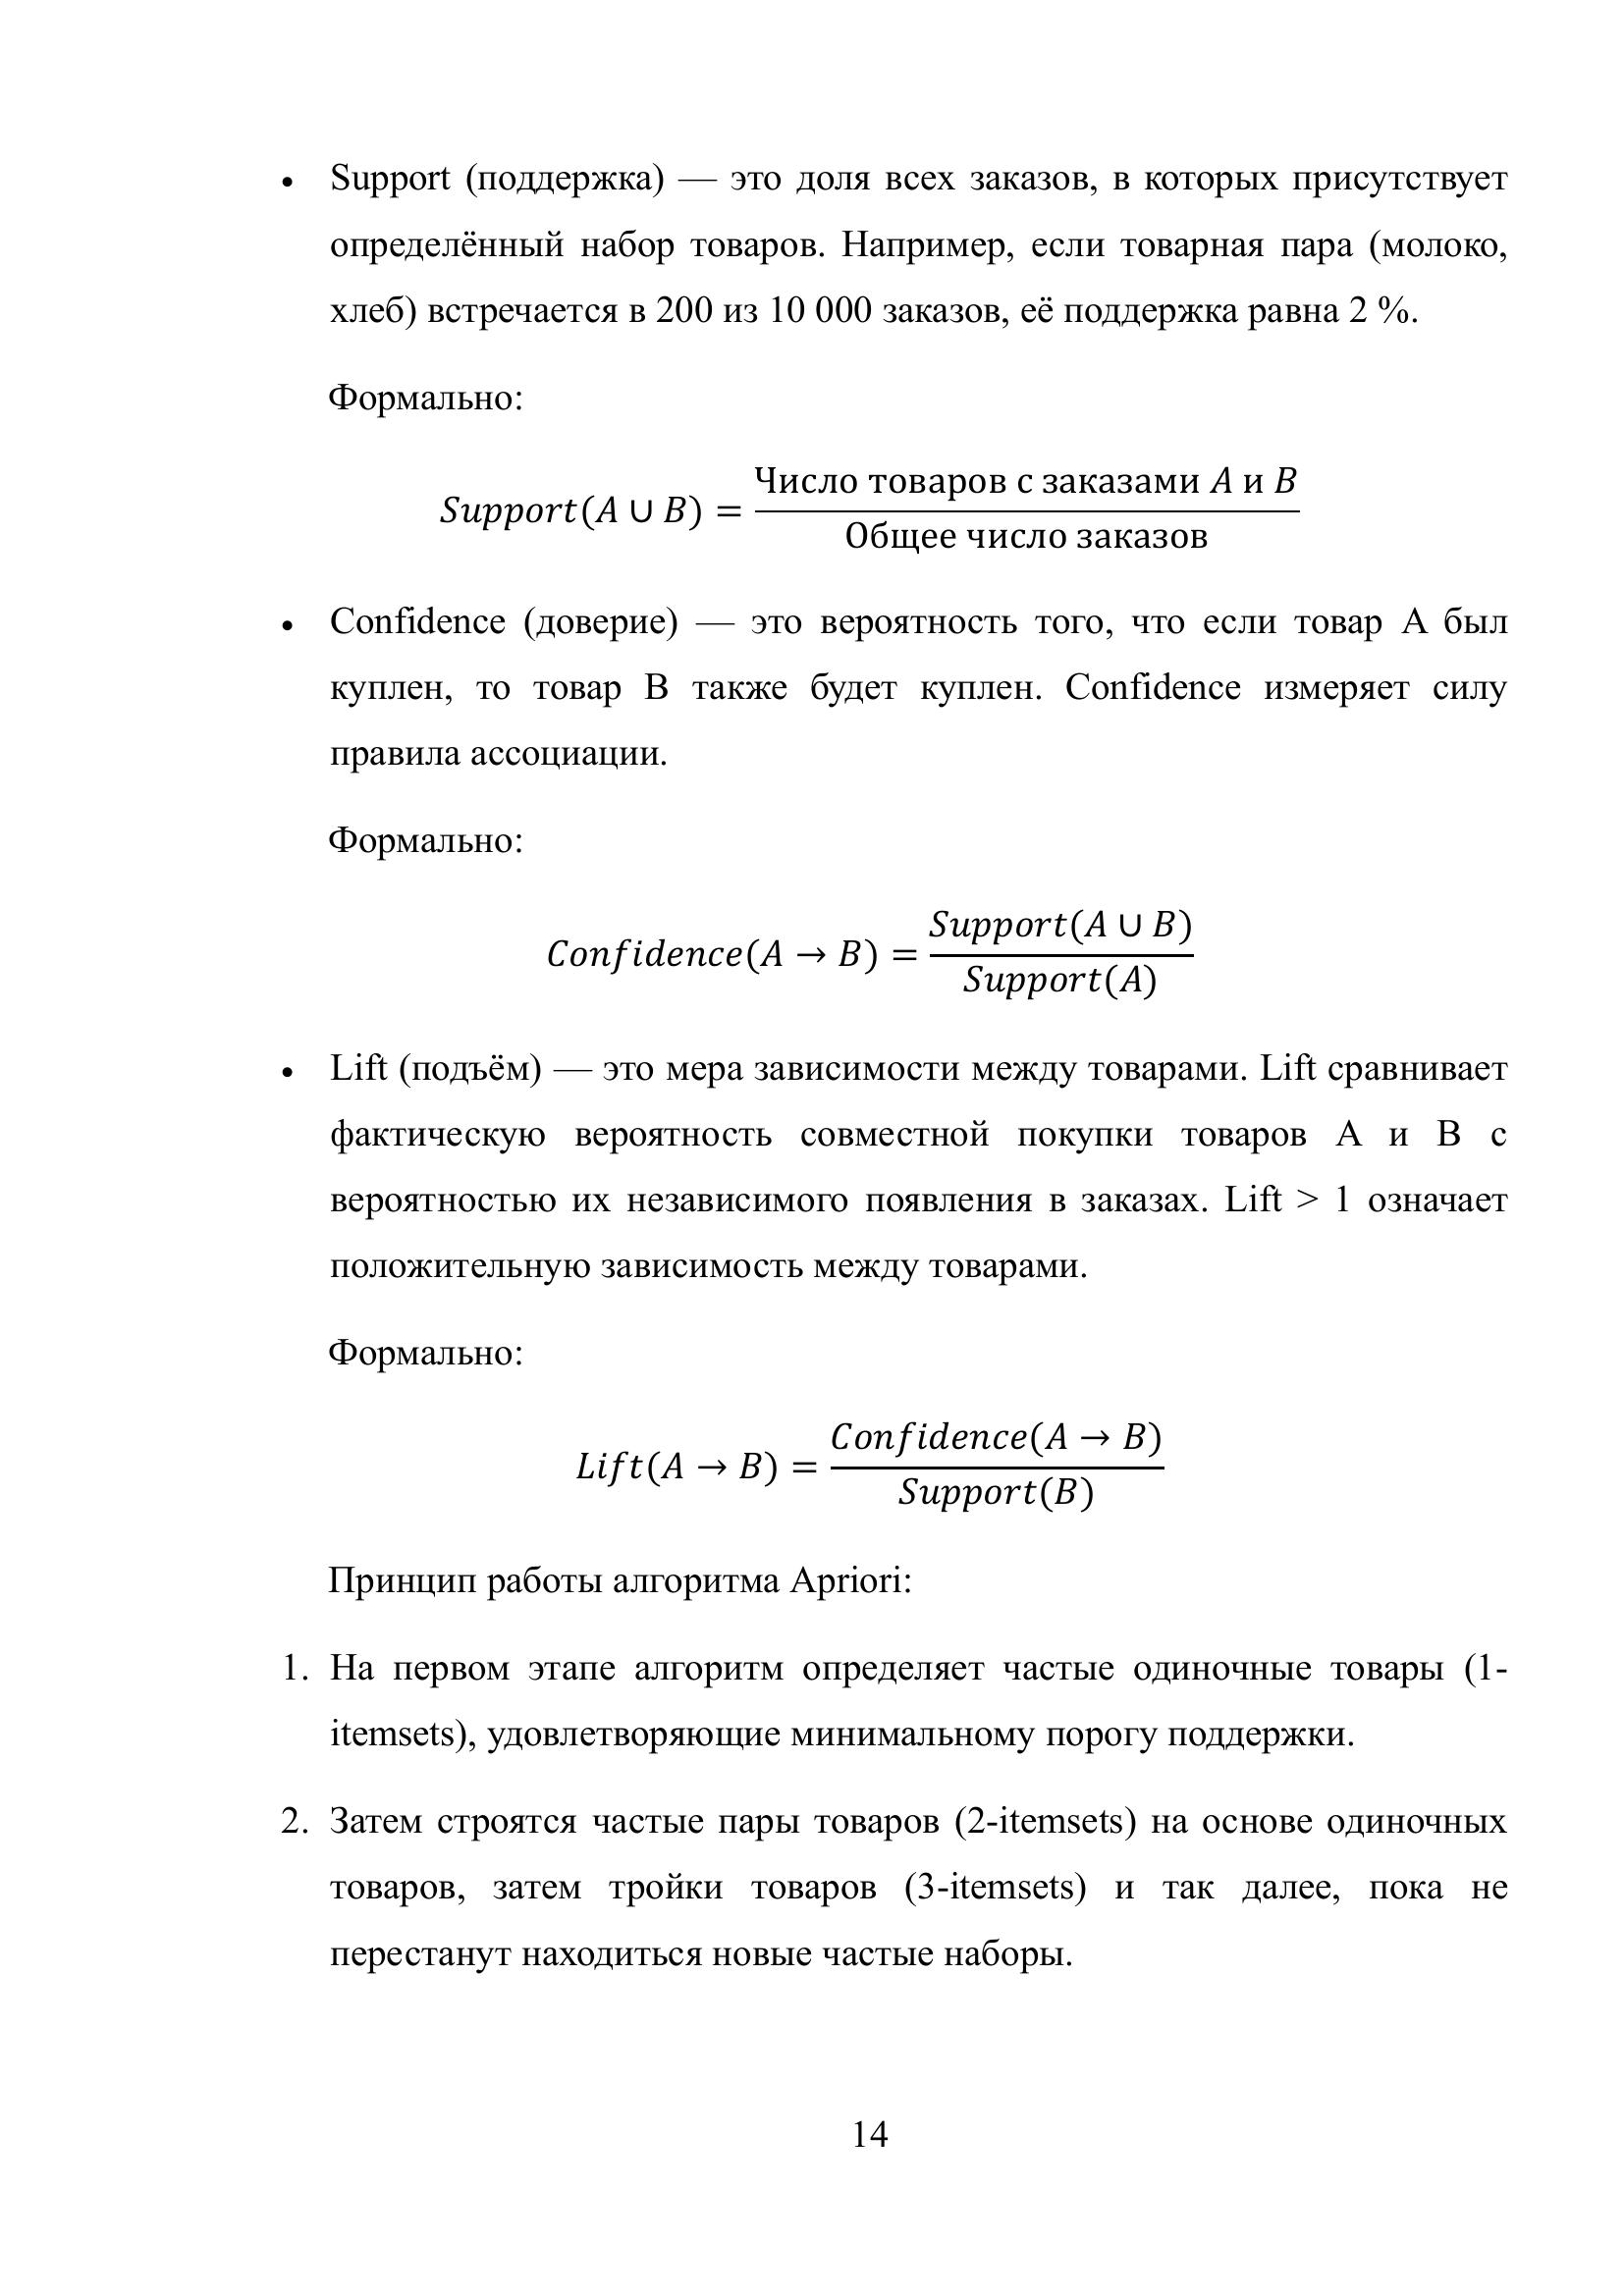
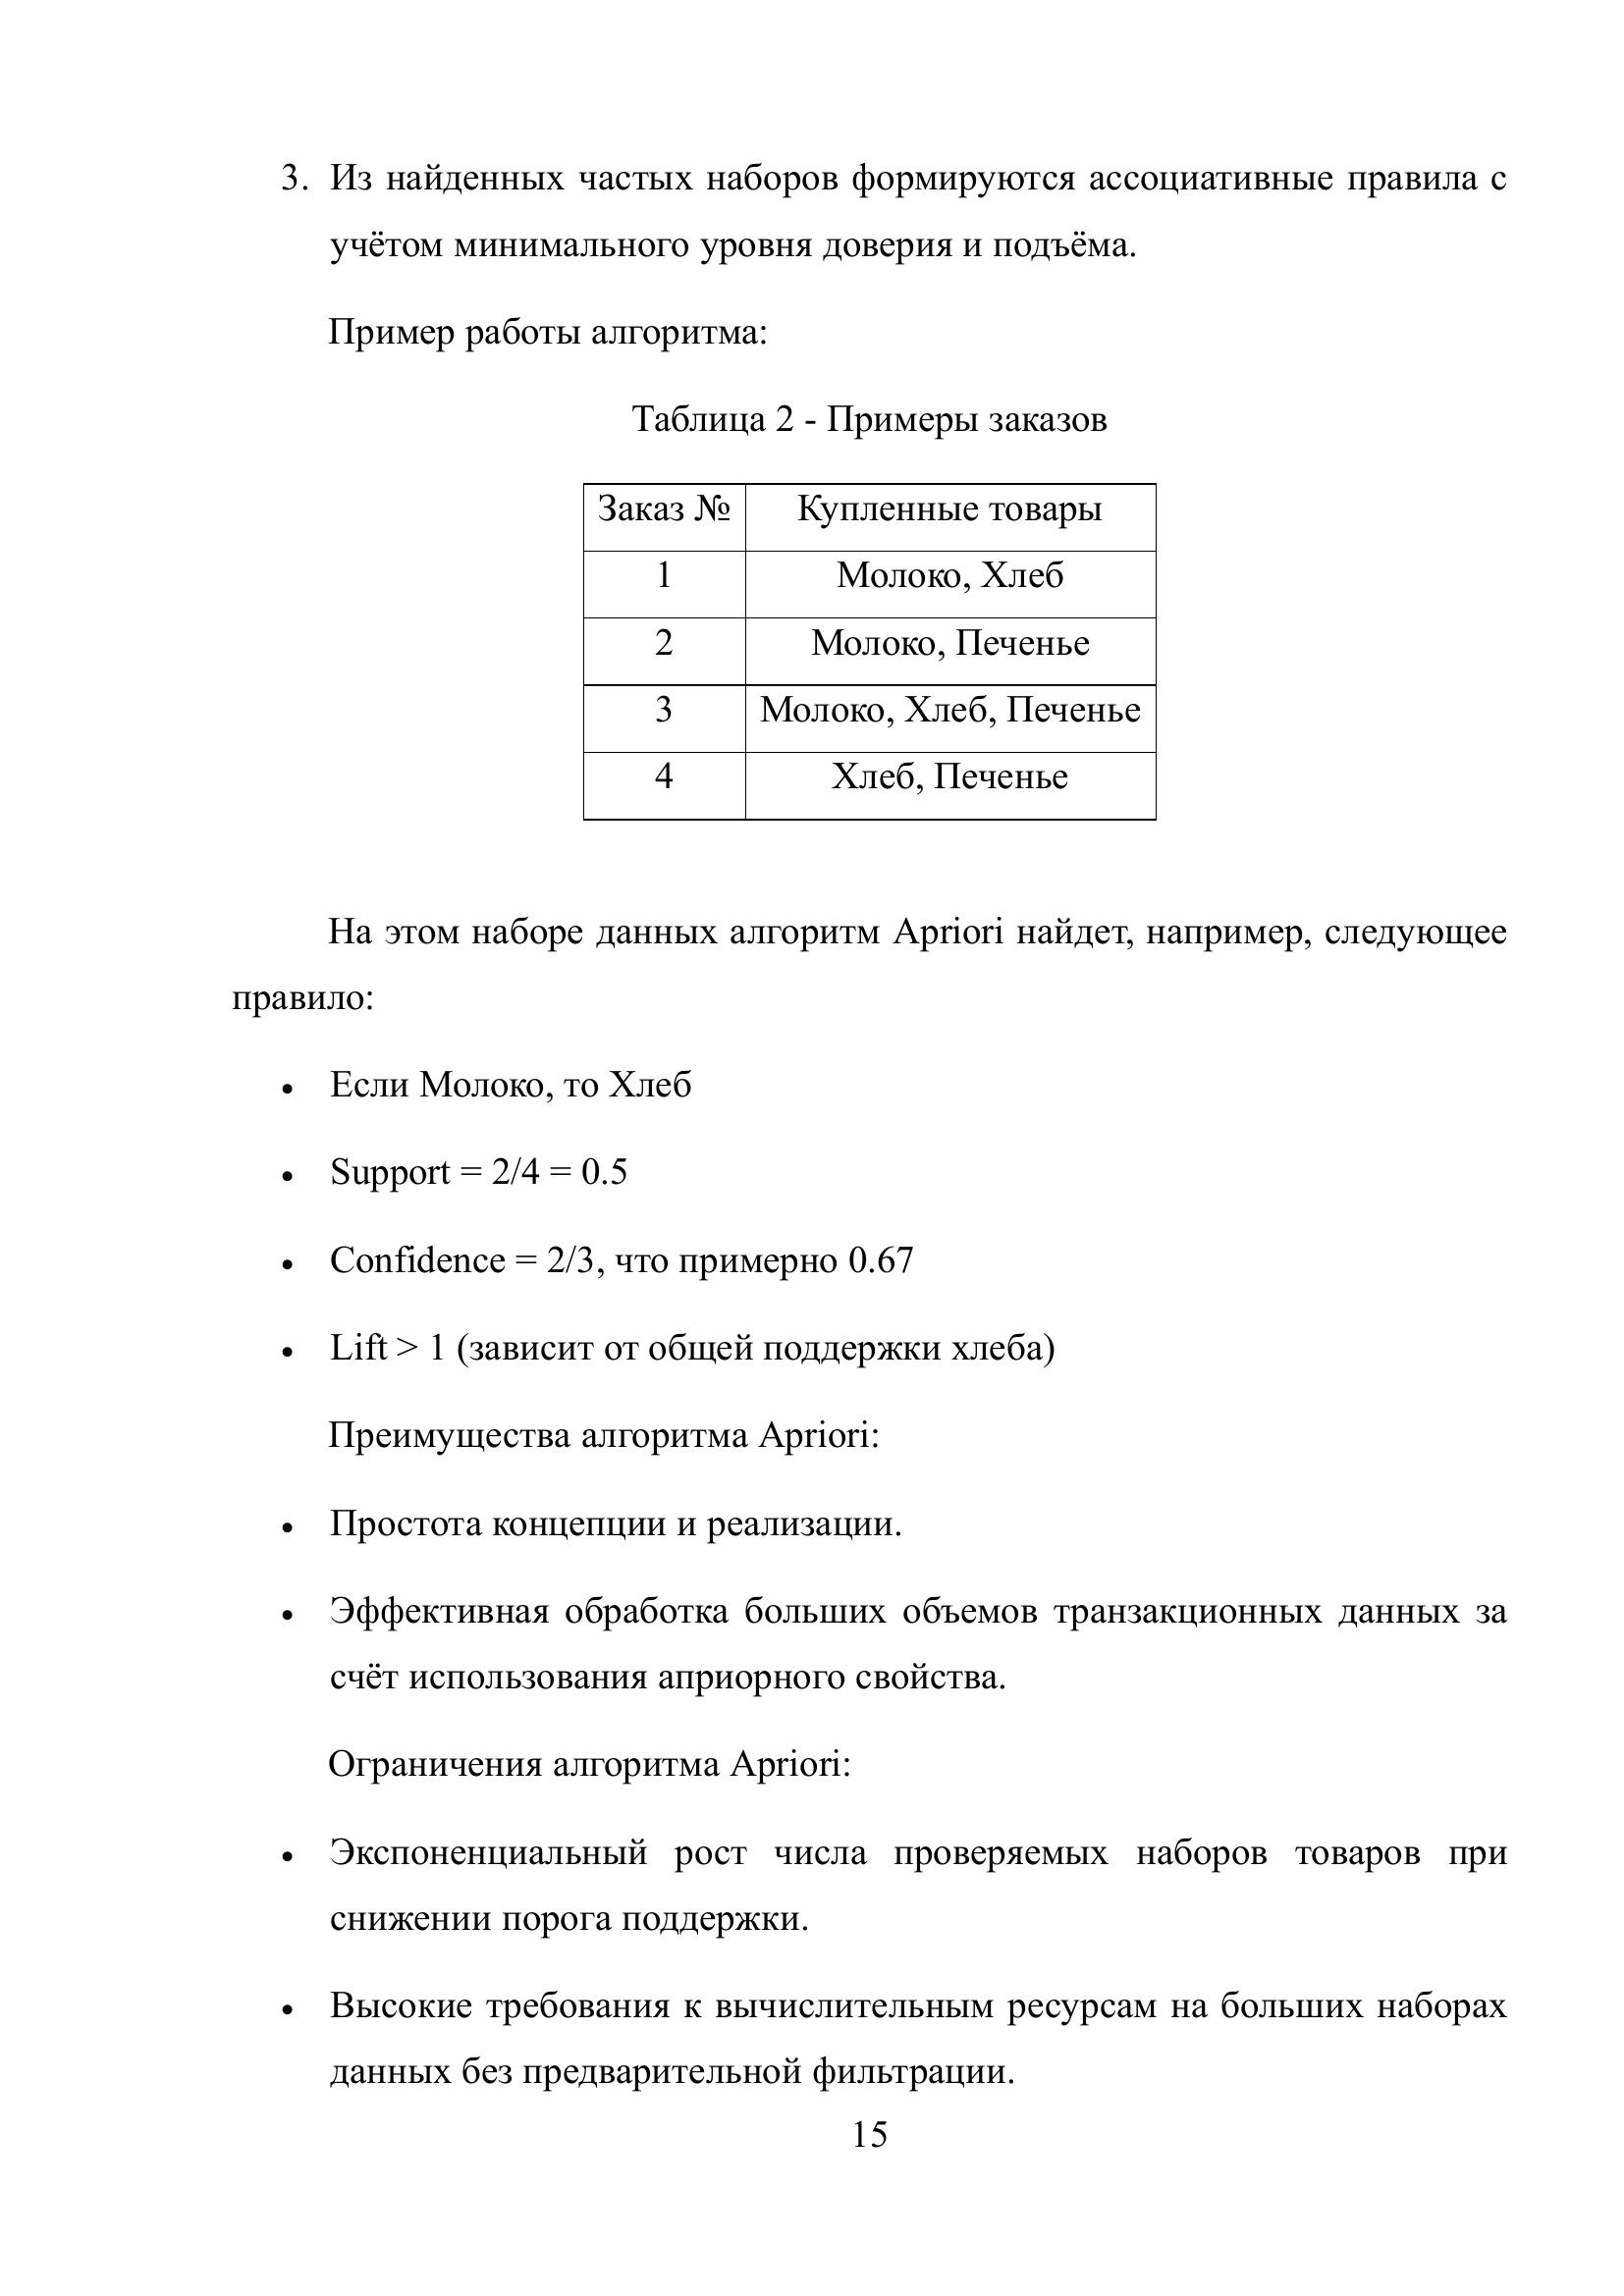
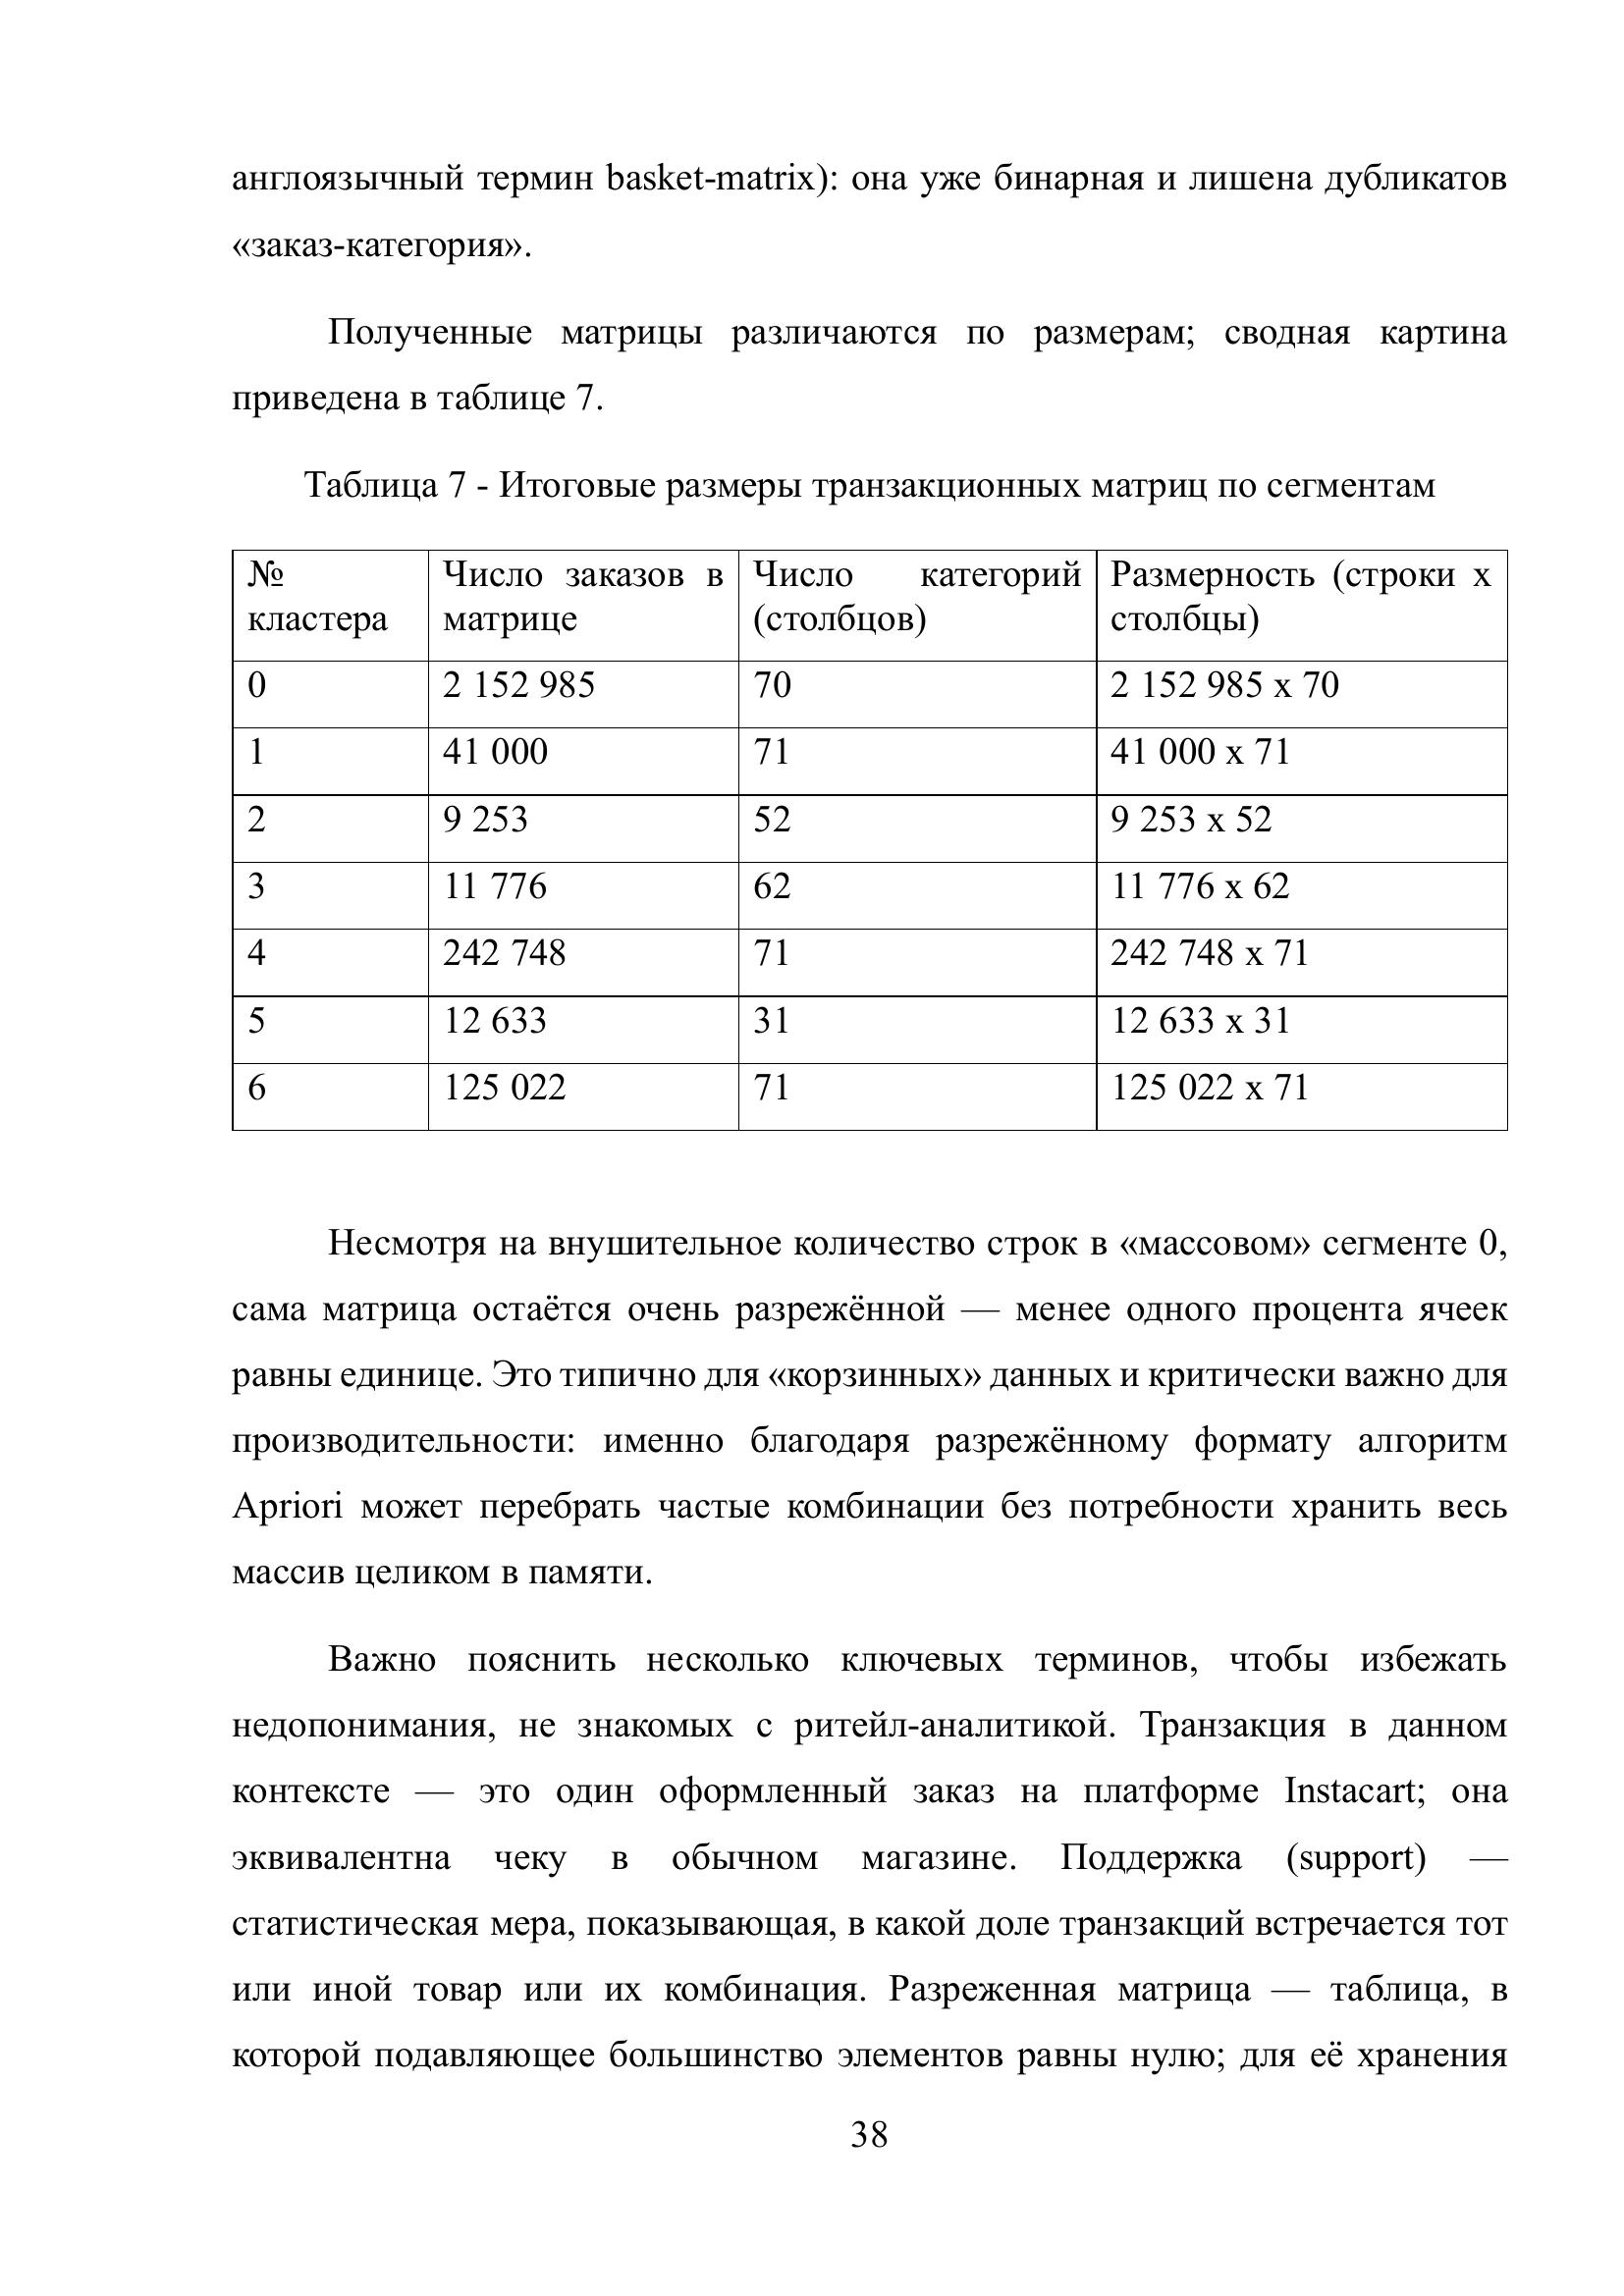


Ответ на «Как рассчитать support»:
Формально:

Support(A ∪ B) = (Число товаров с заказами A и B) / Общее число заказов




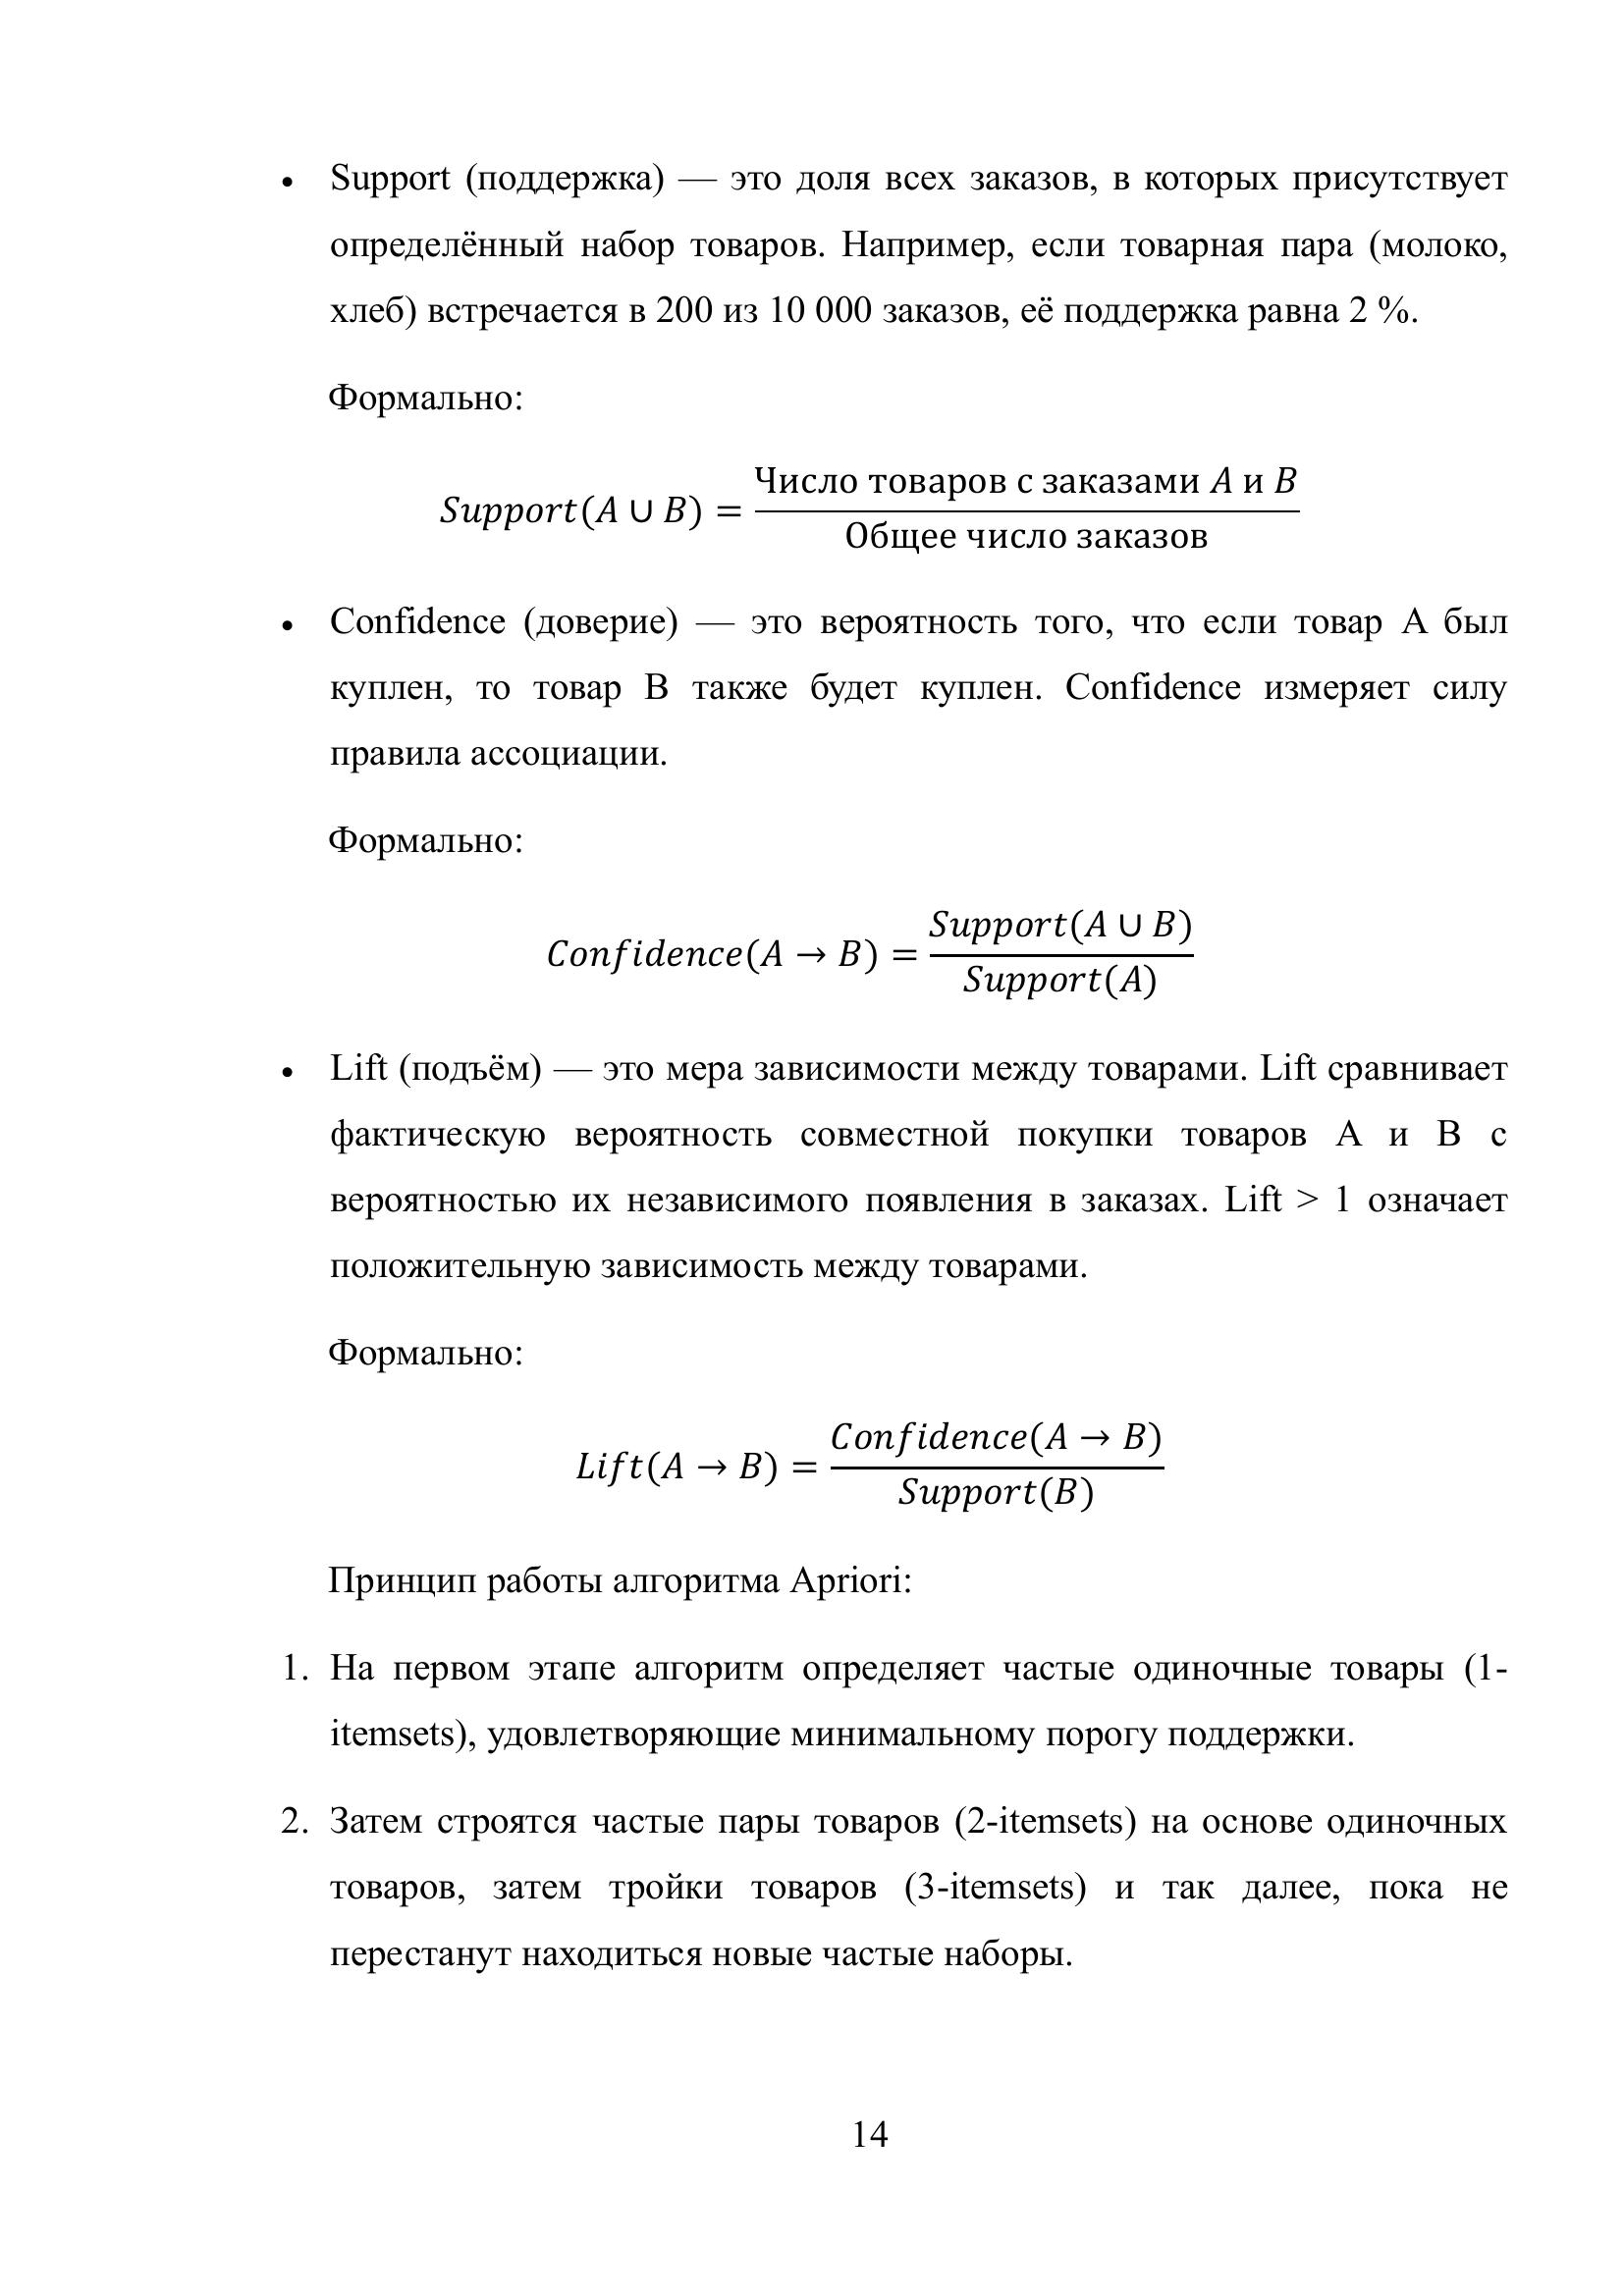
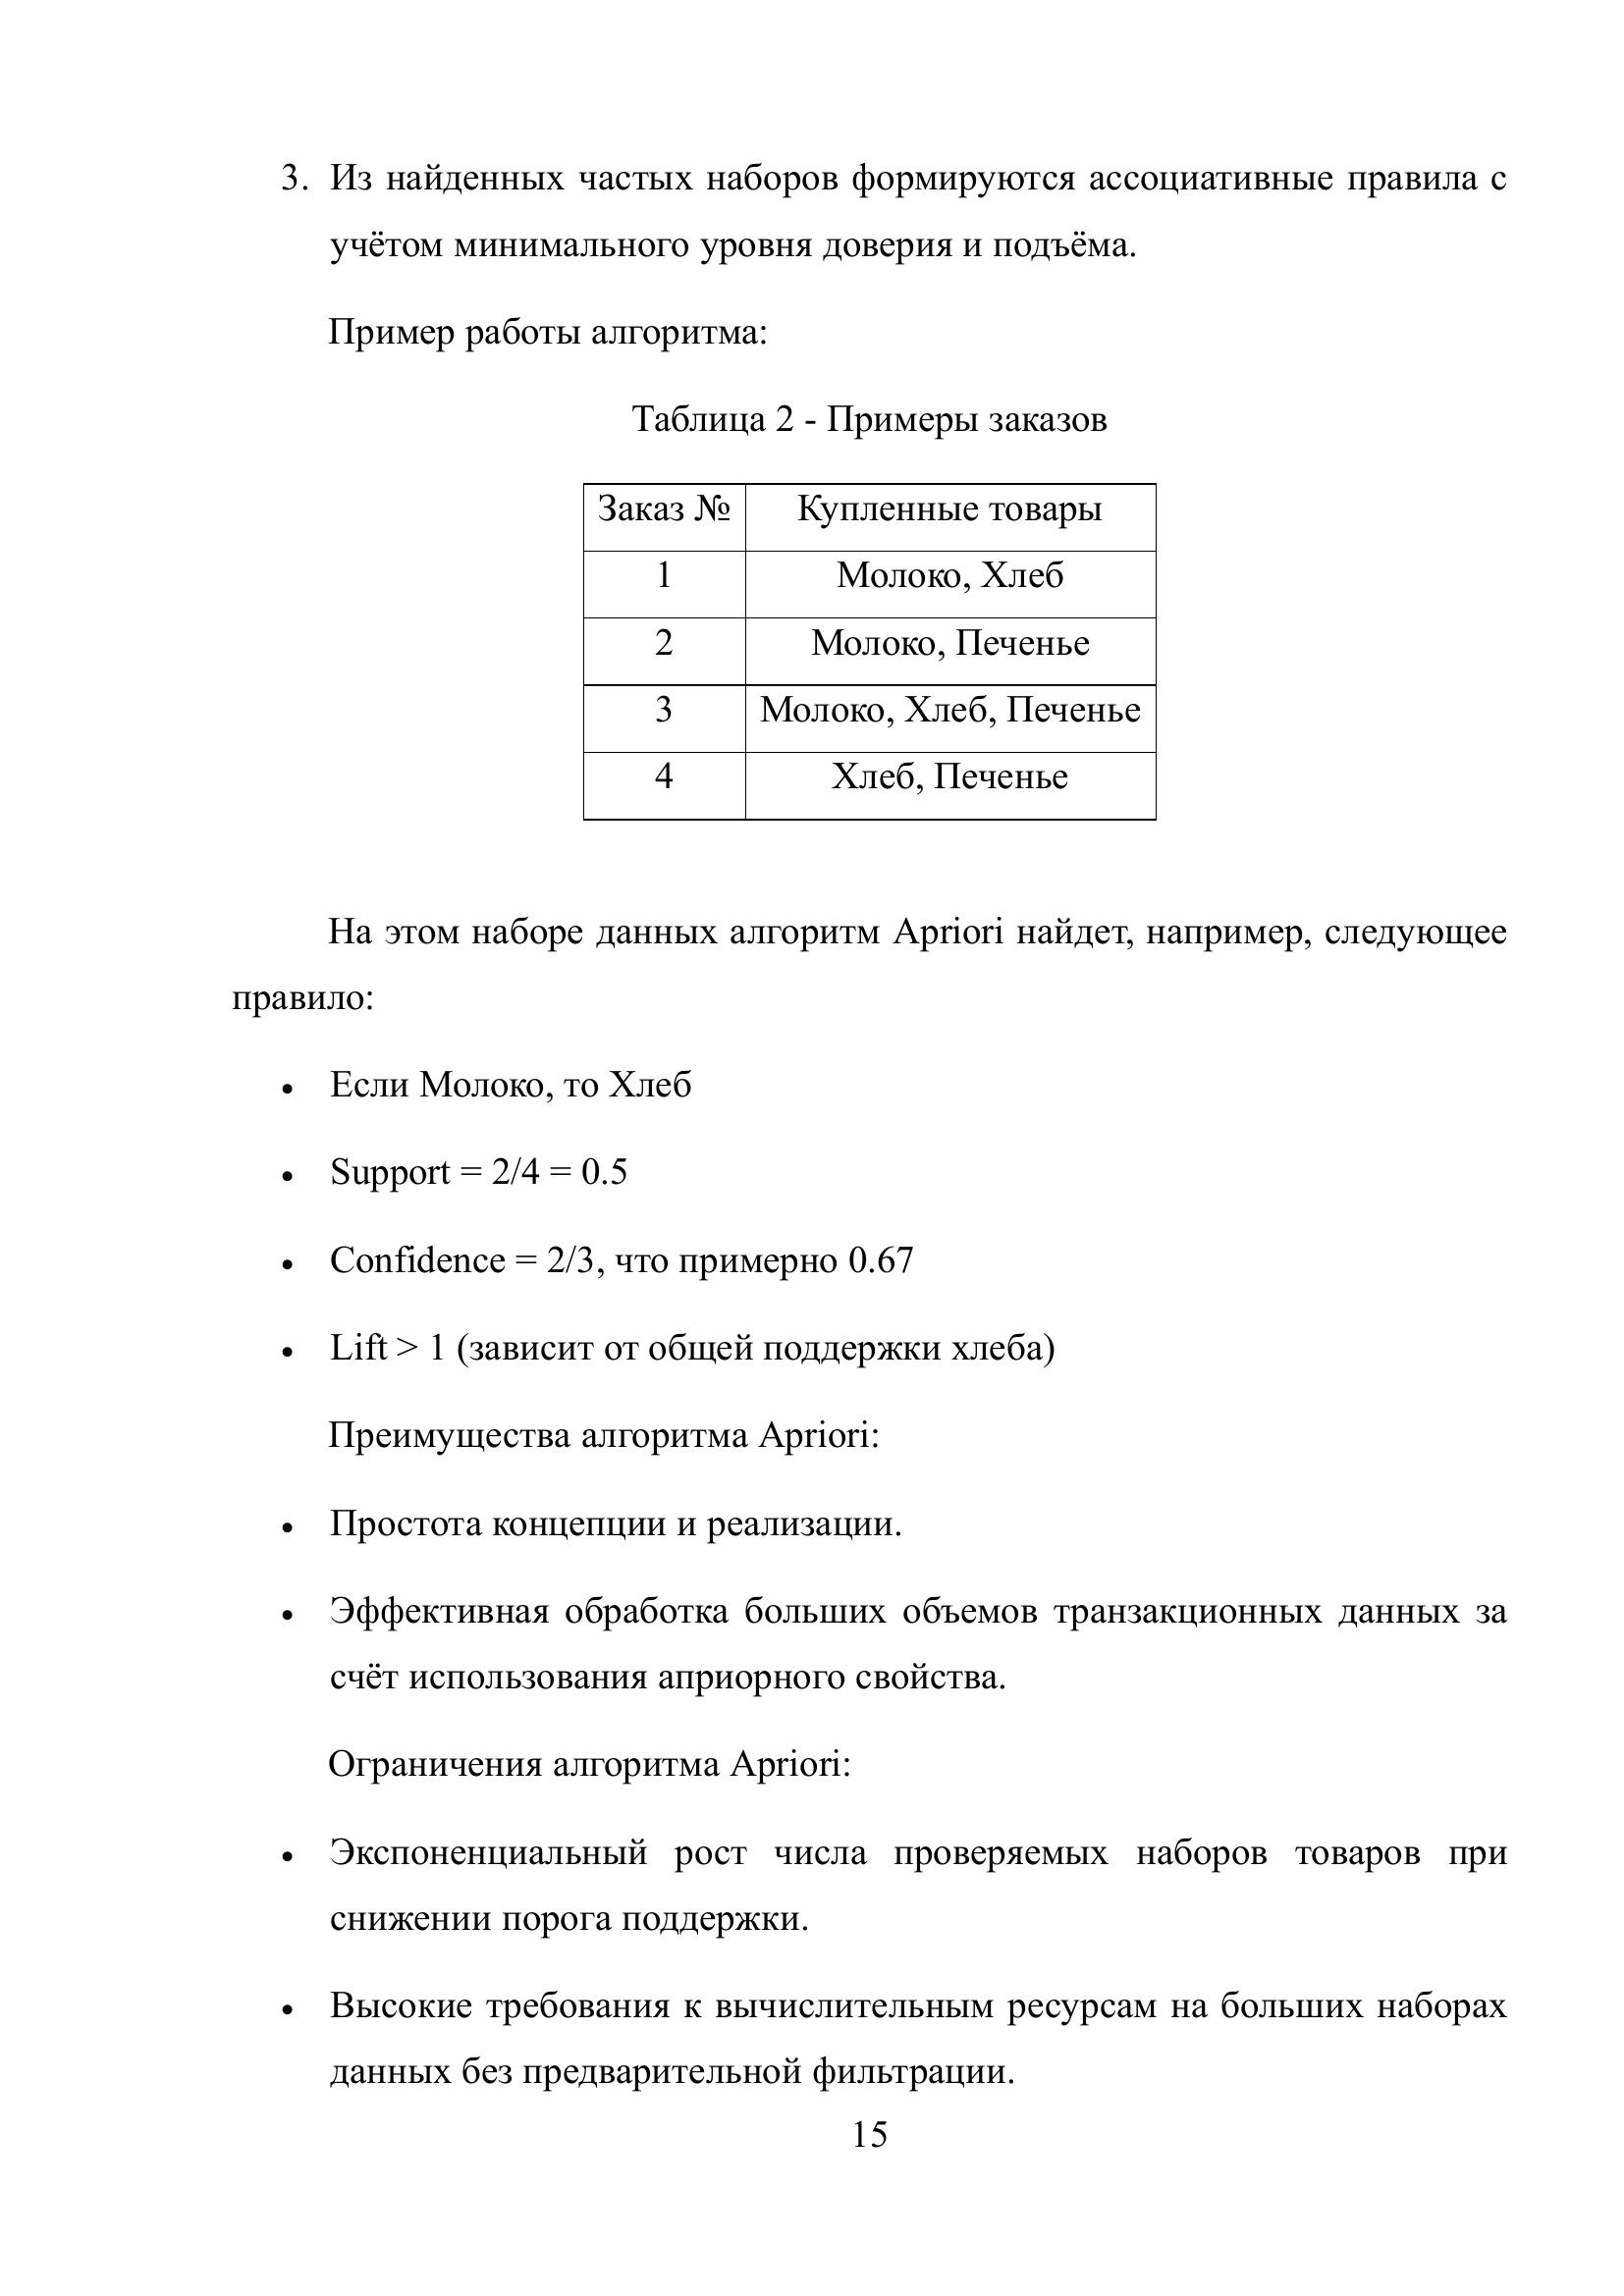
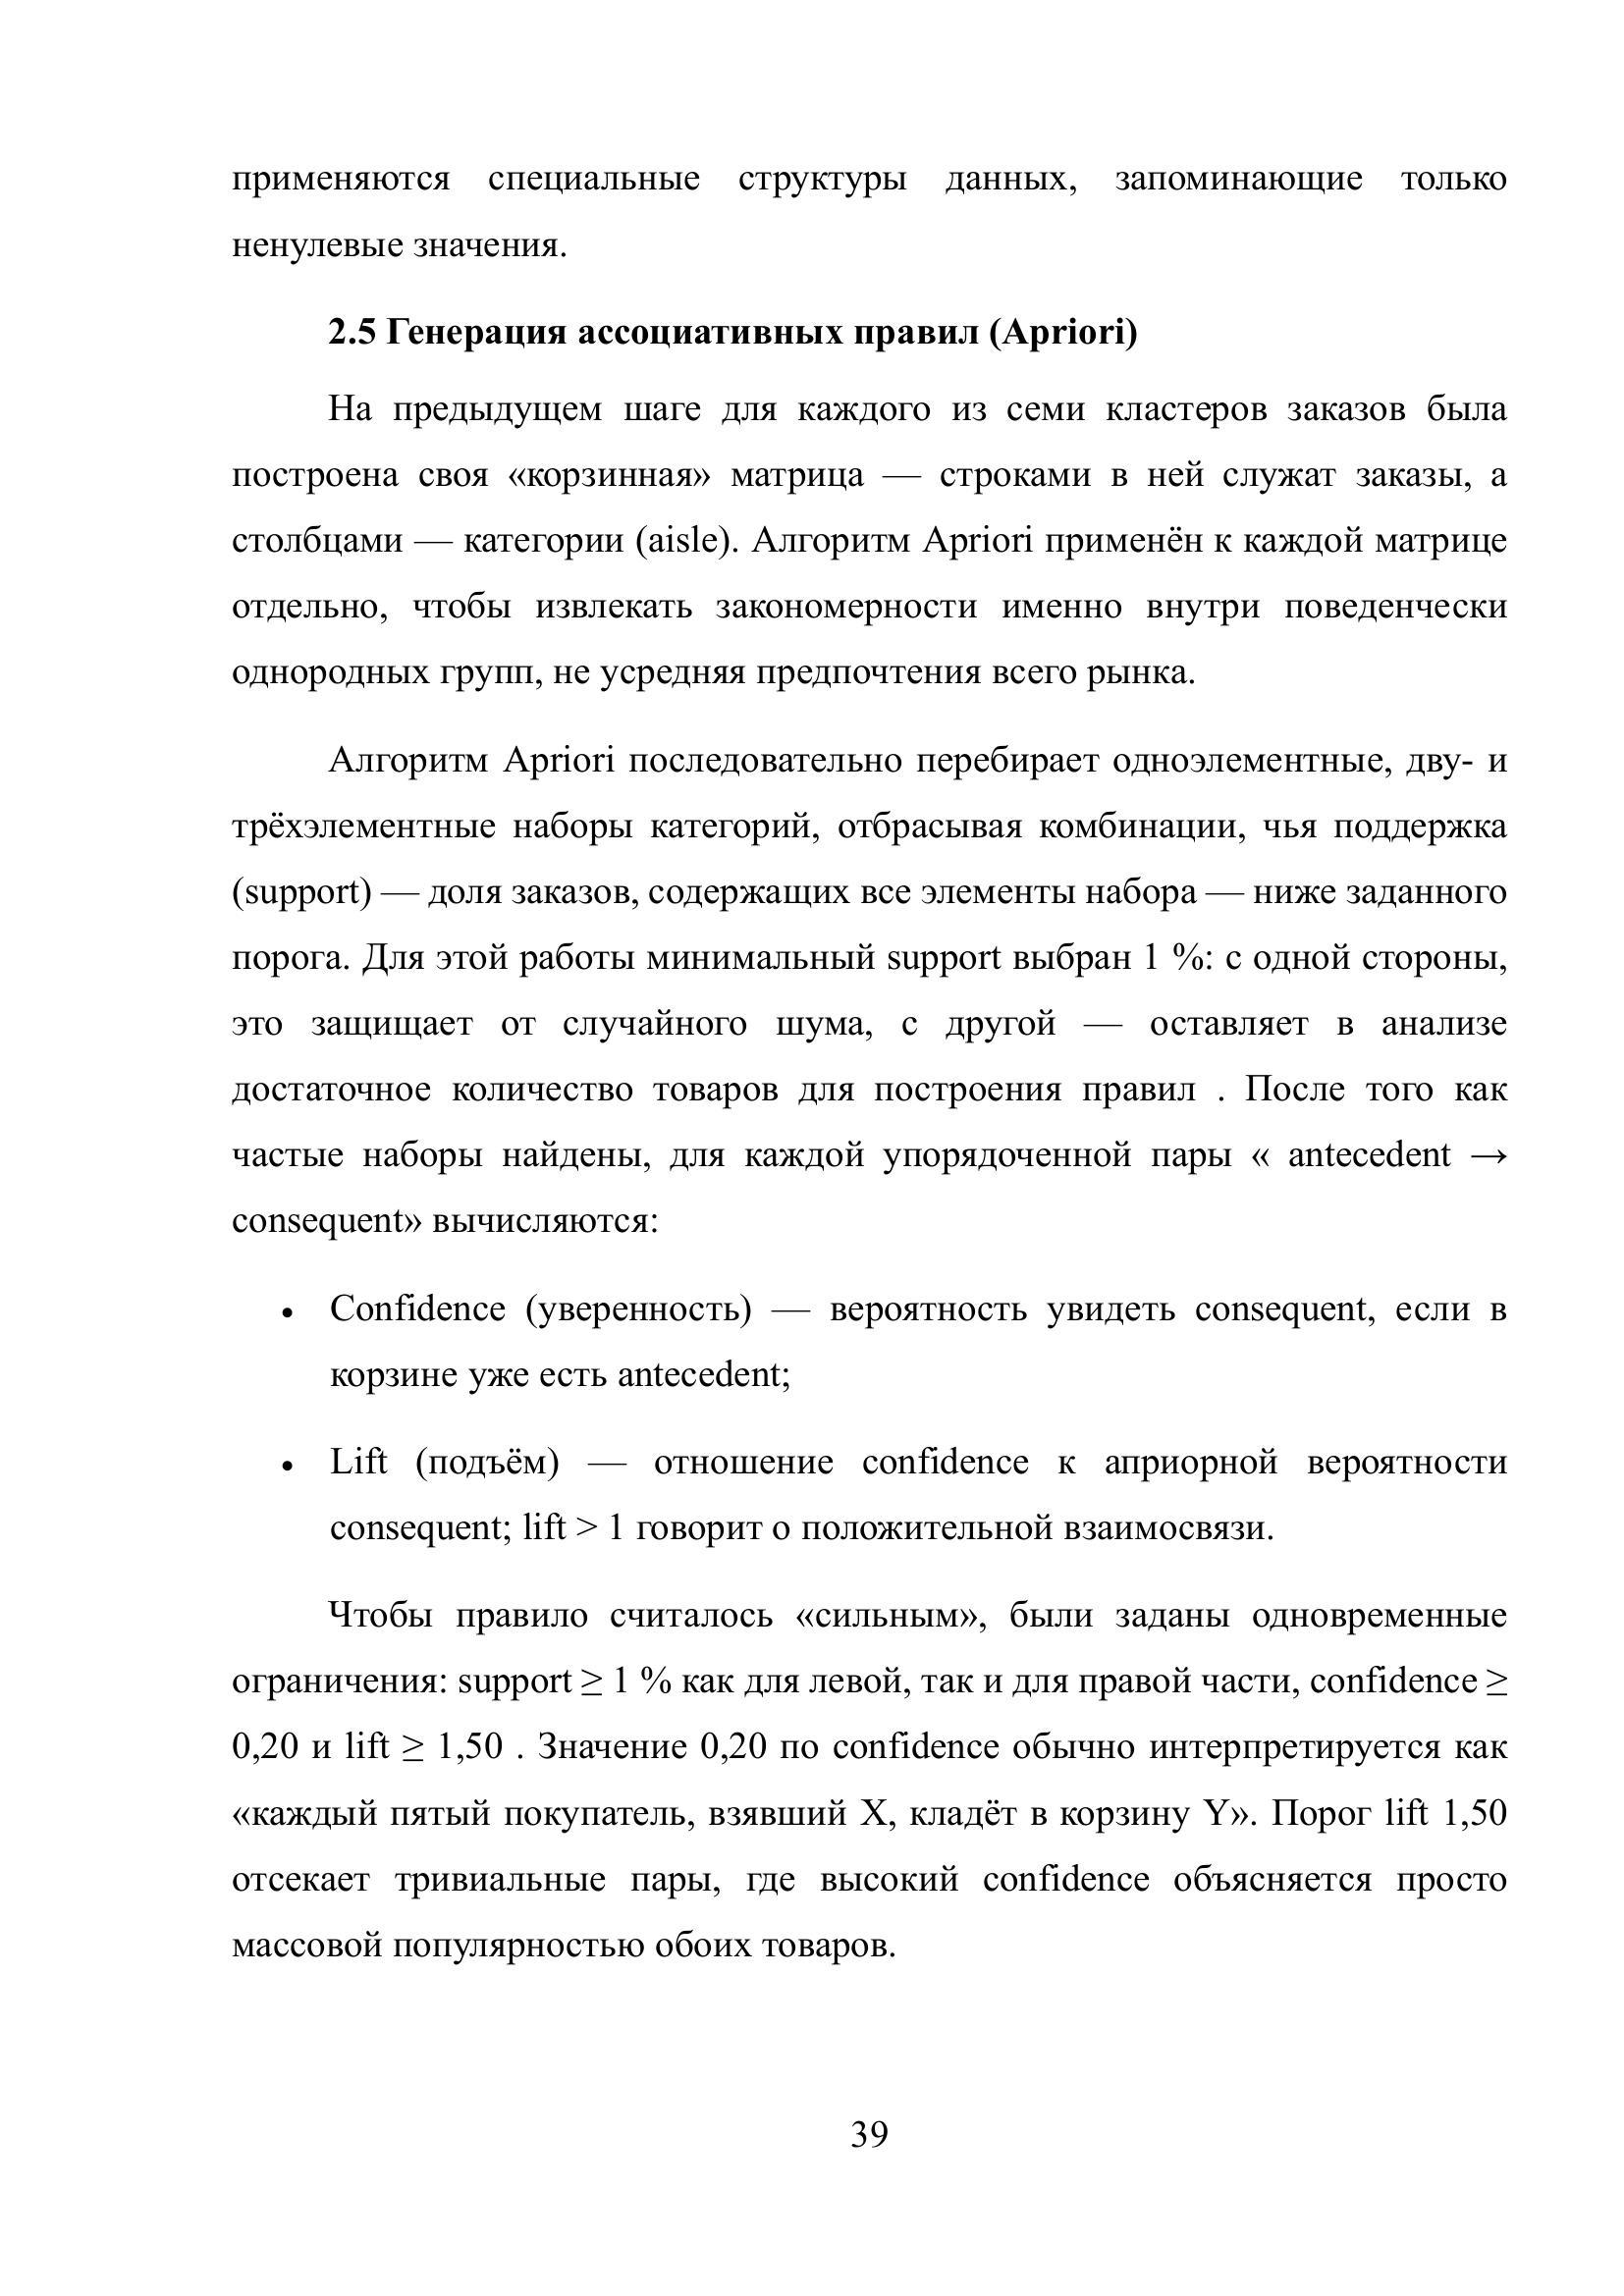


Ответ на «Как рассчитать confidence»:
Confidence (доверие) — это вероятность того, что если товар B был куплен, то товар A также будет куплен. Confidence измеряет силу правила ассоциации.

Формально:

Confidence(A → B) = Support(A ∪ B) / Support(A)




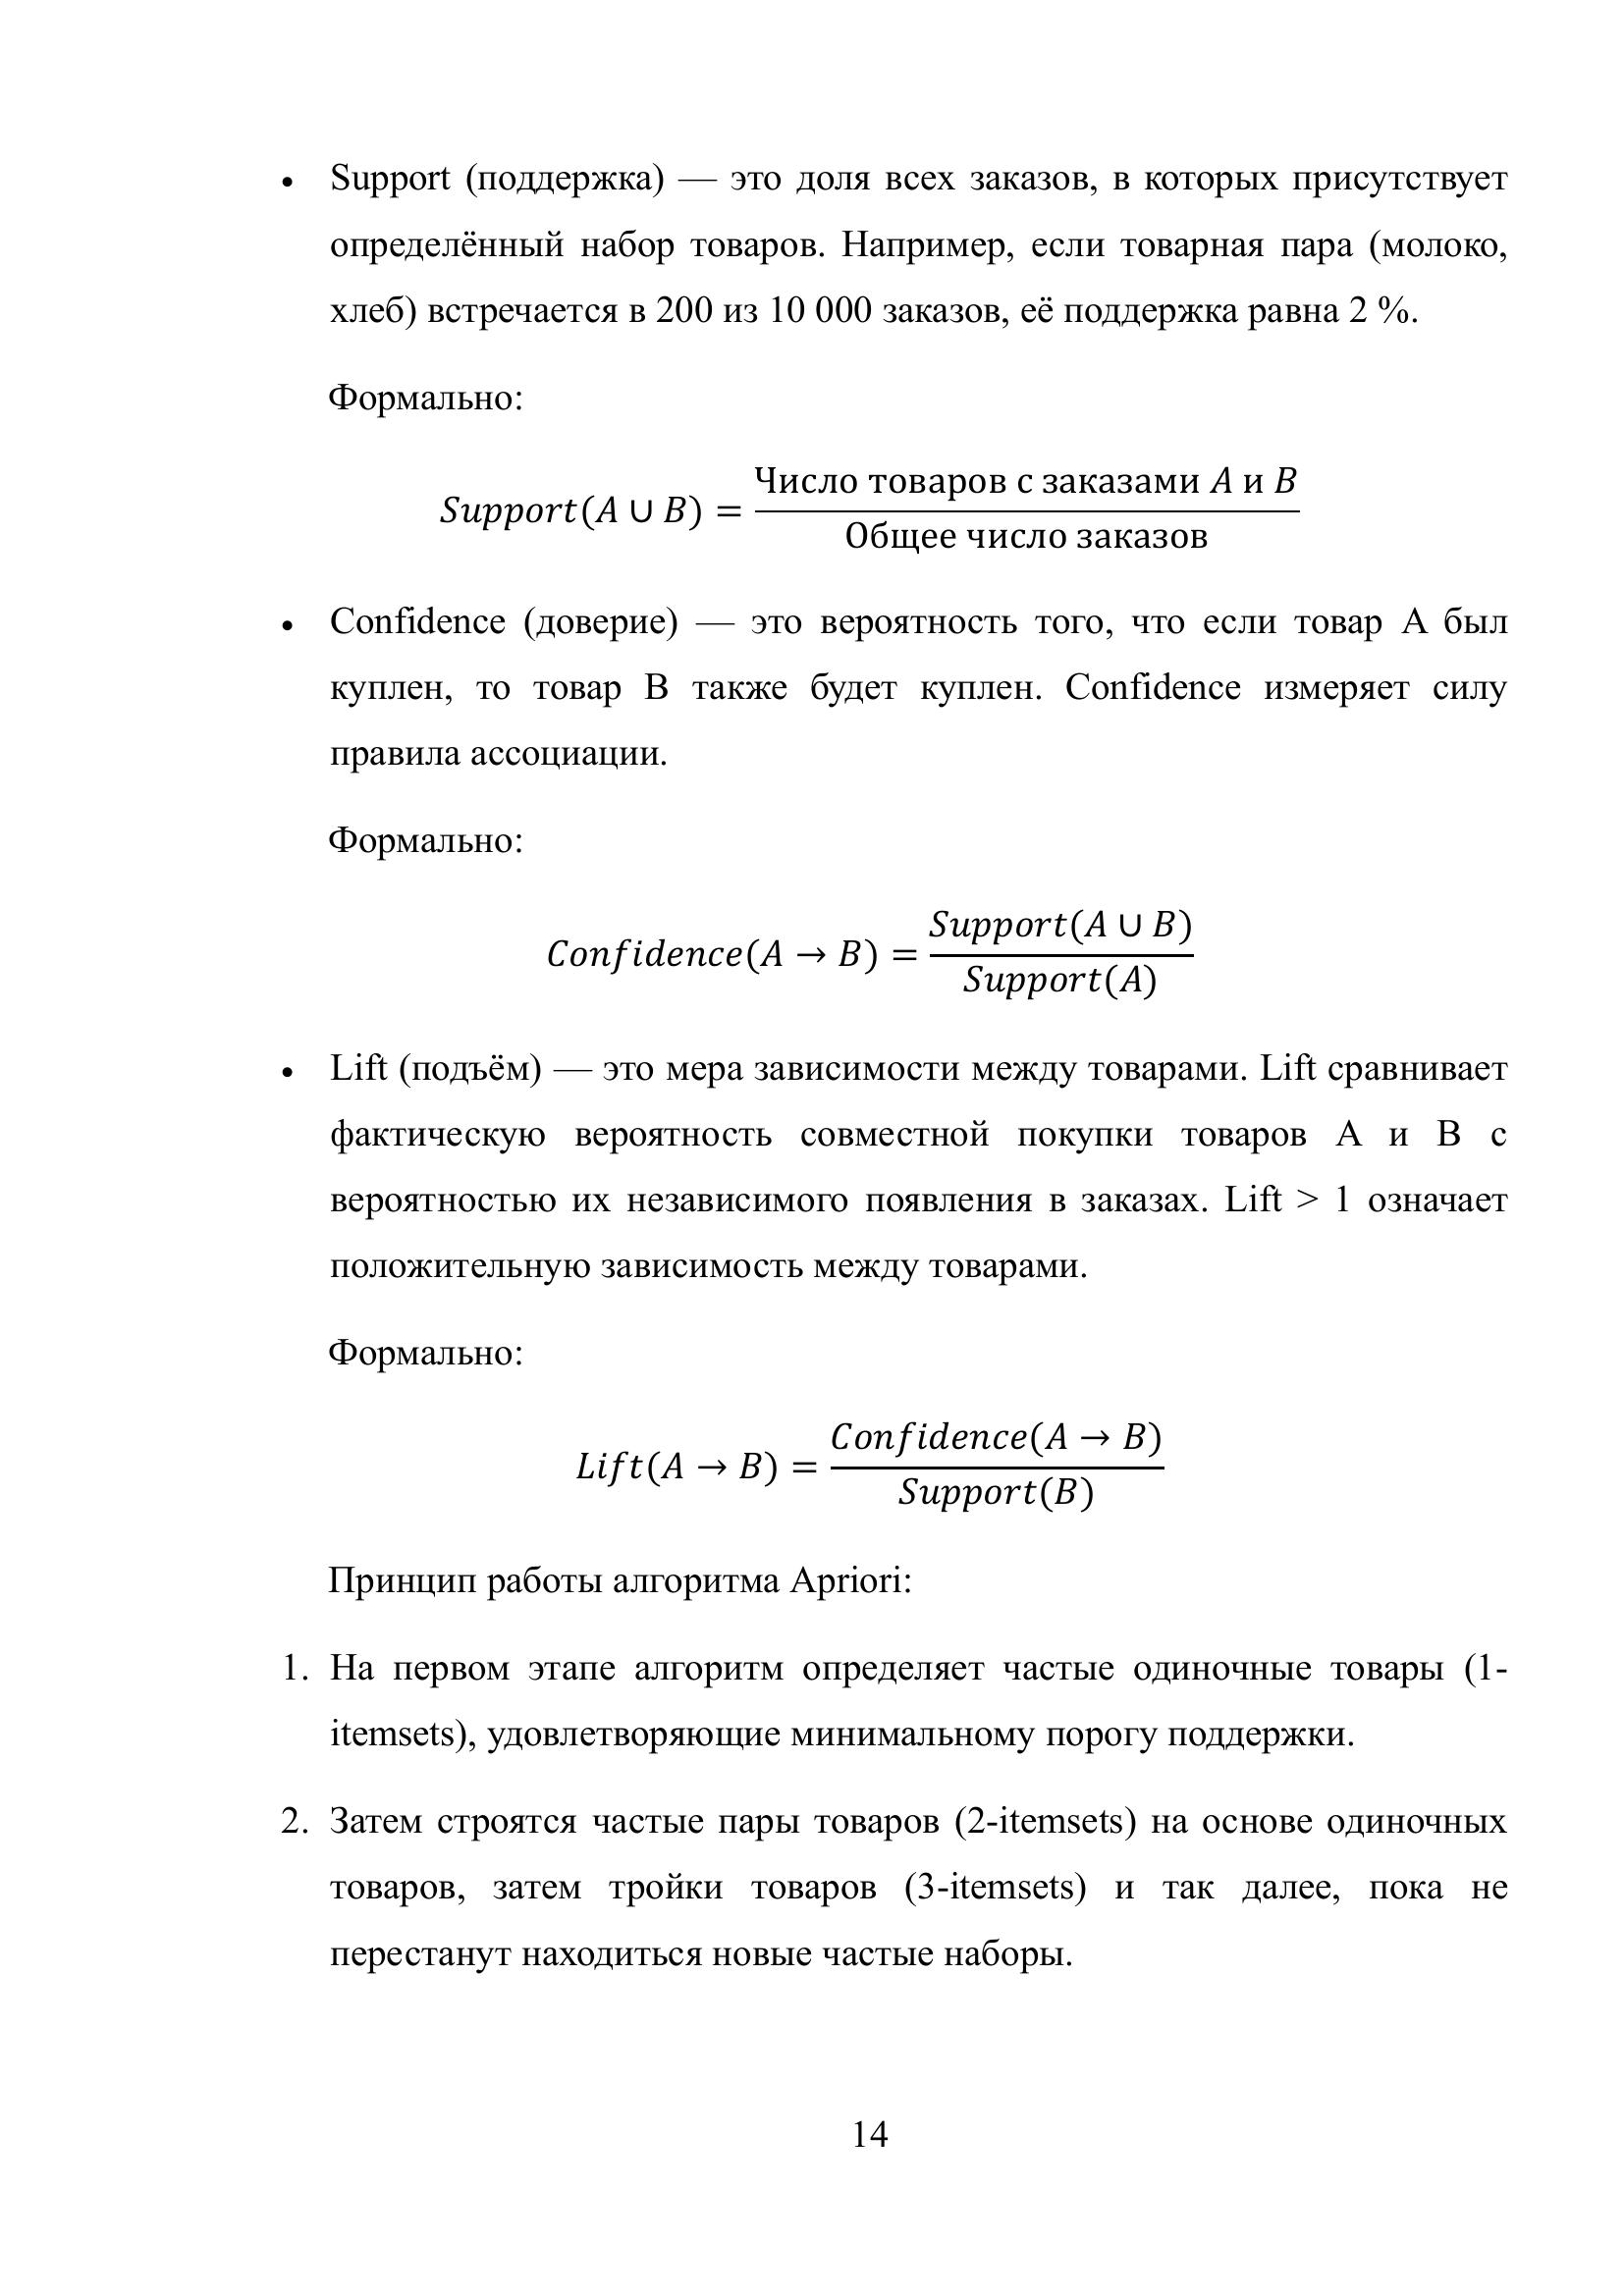
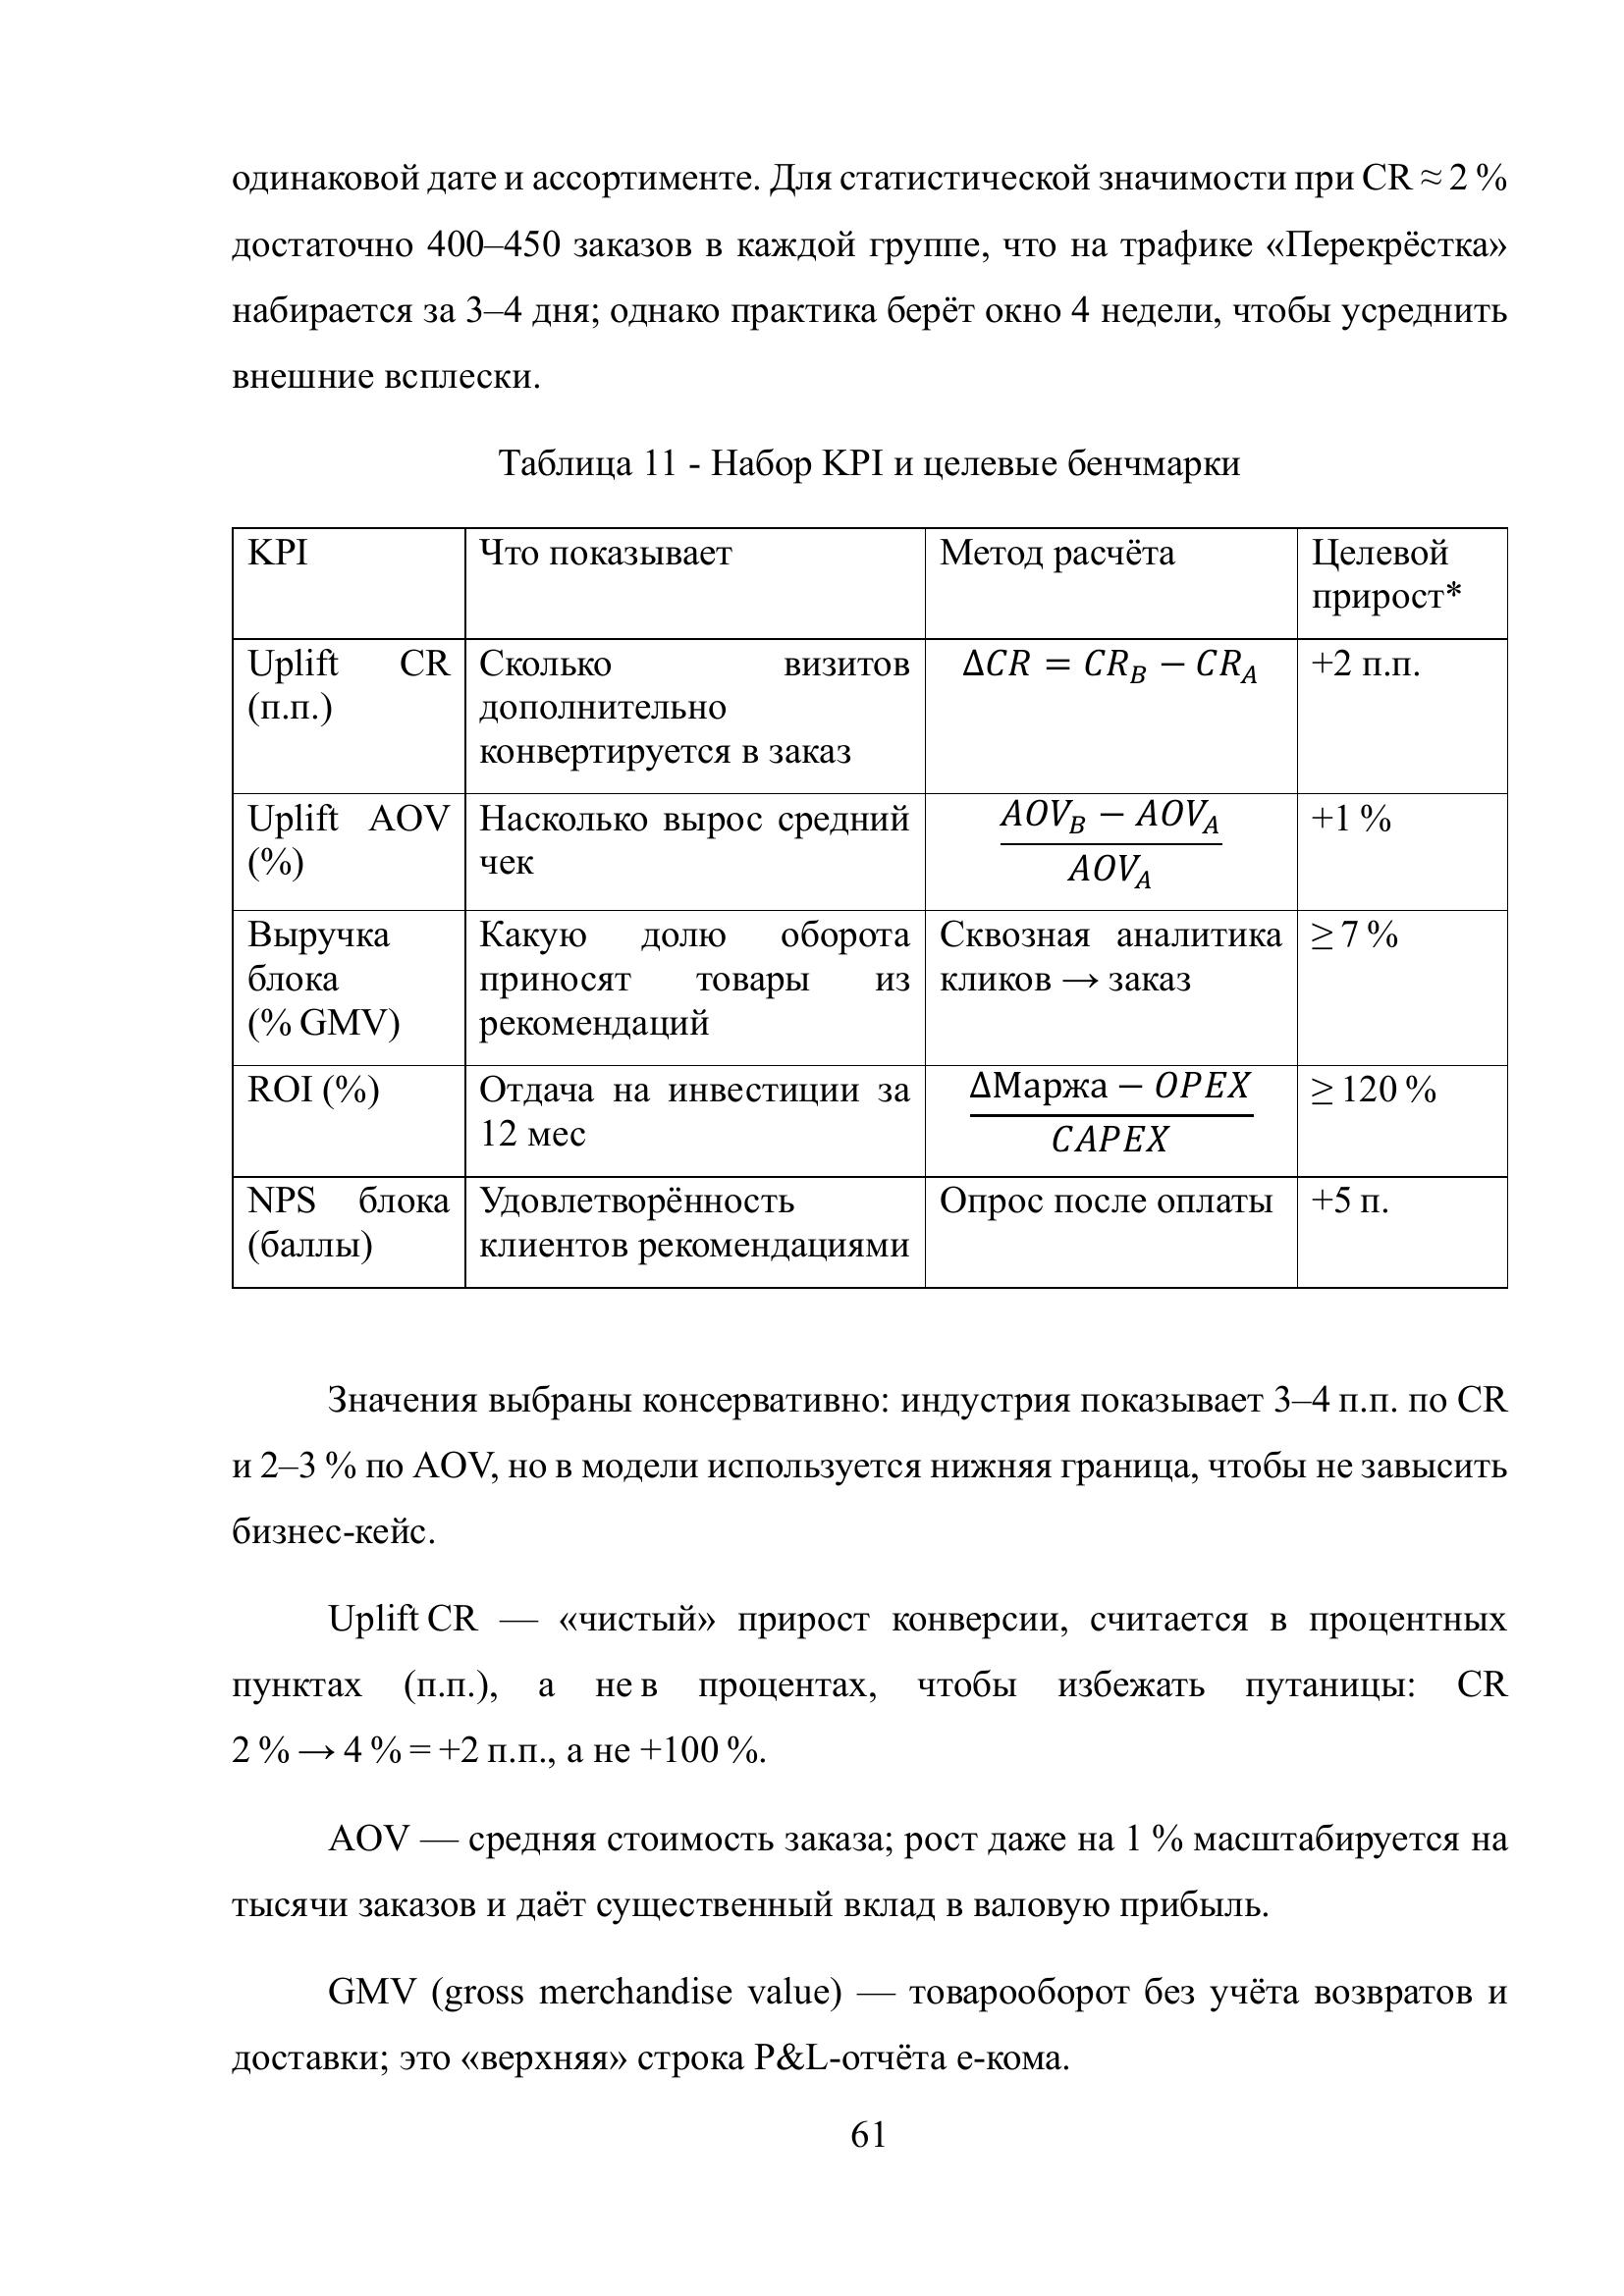
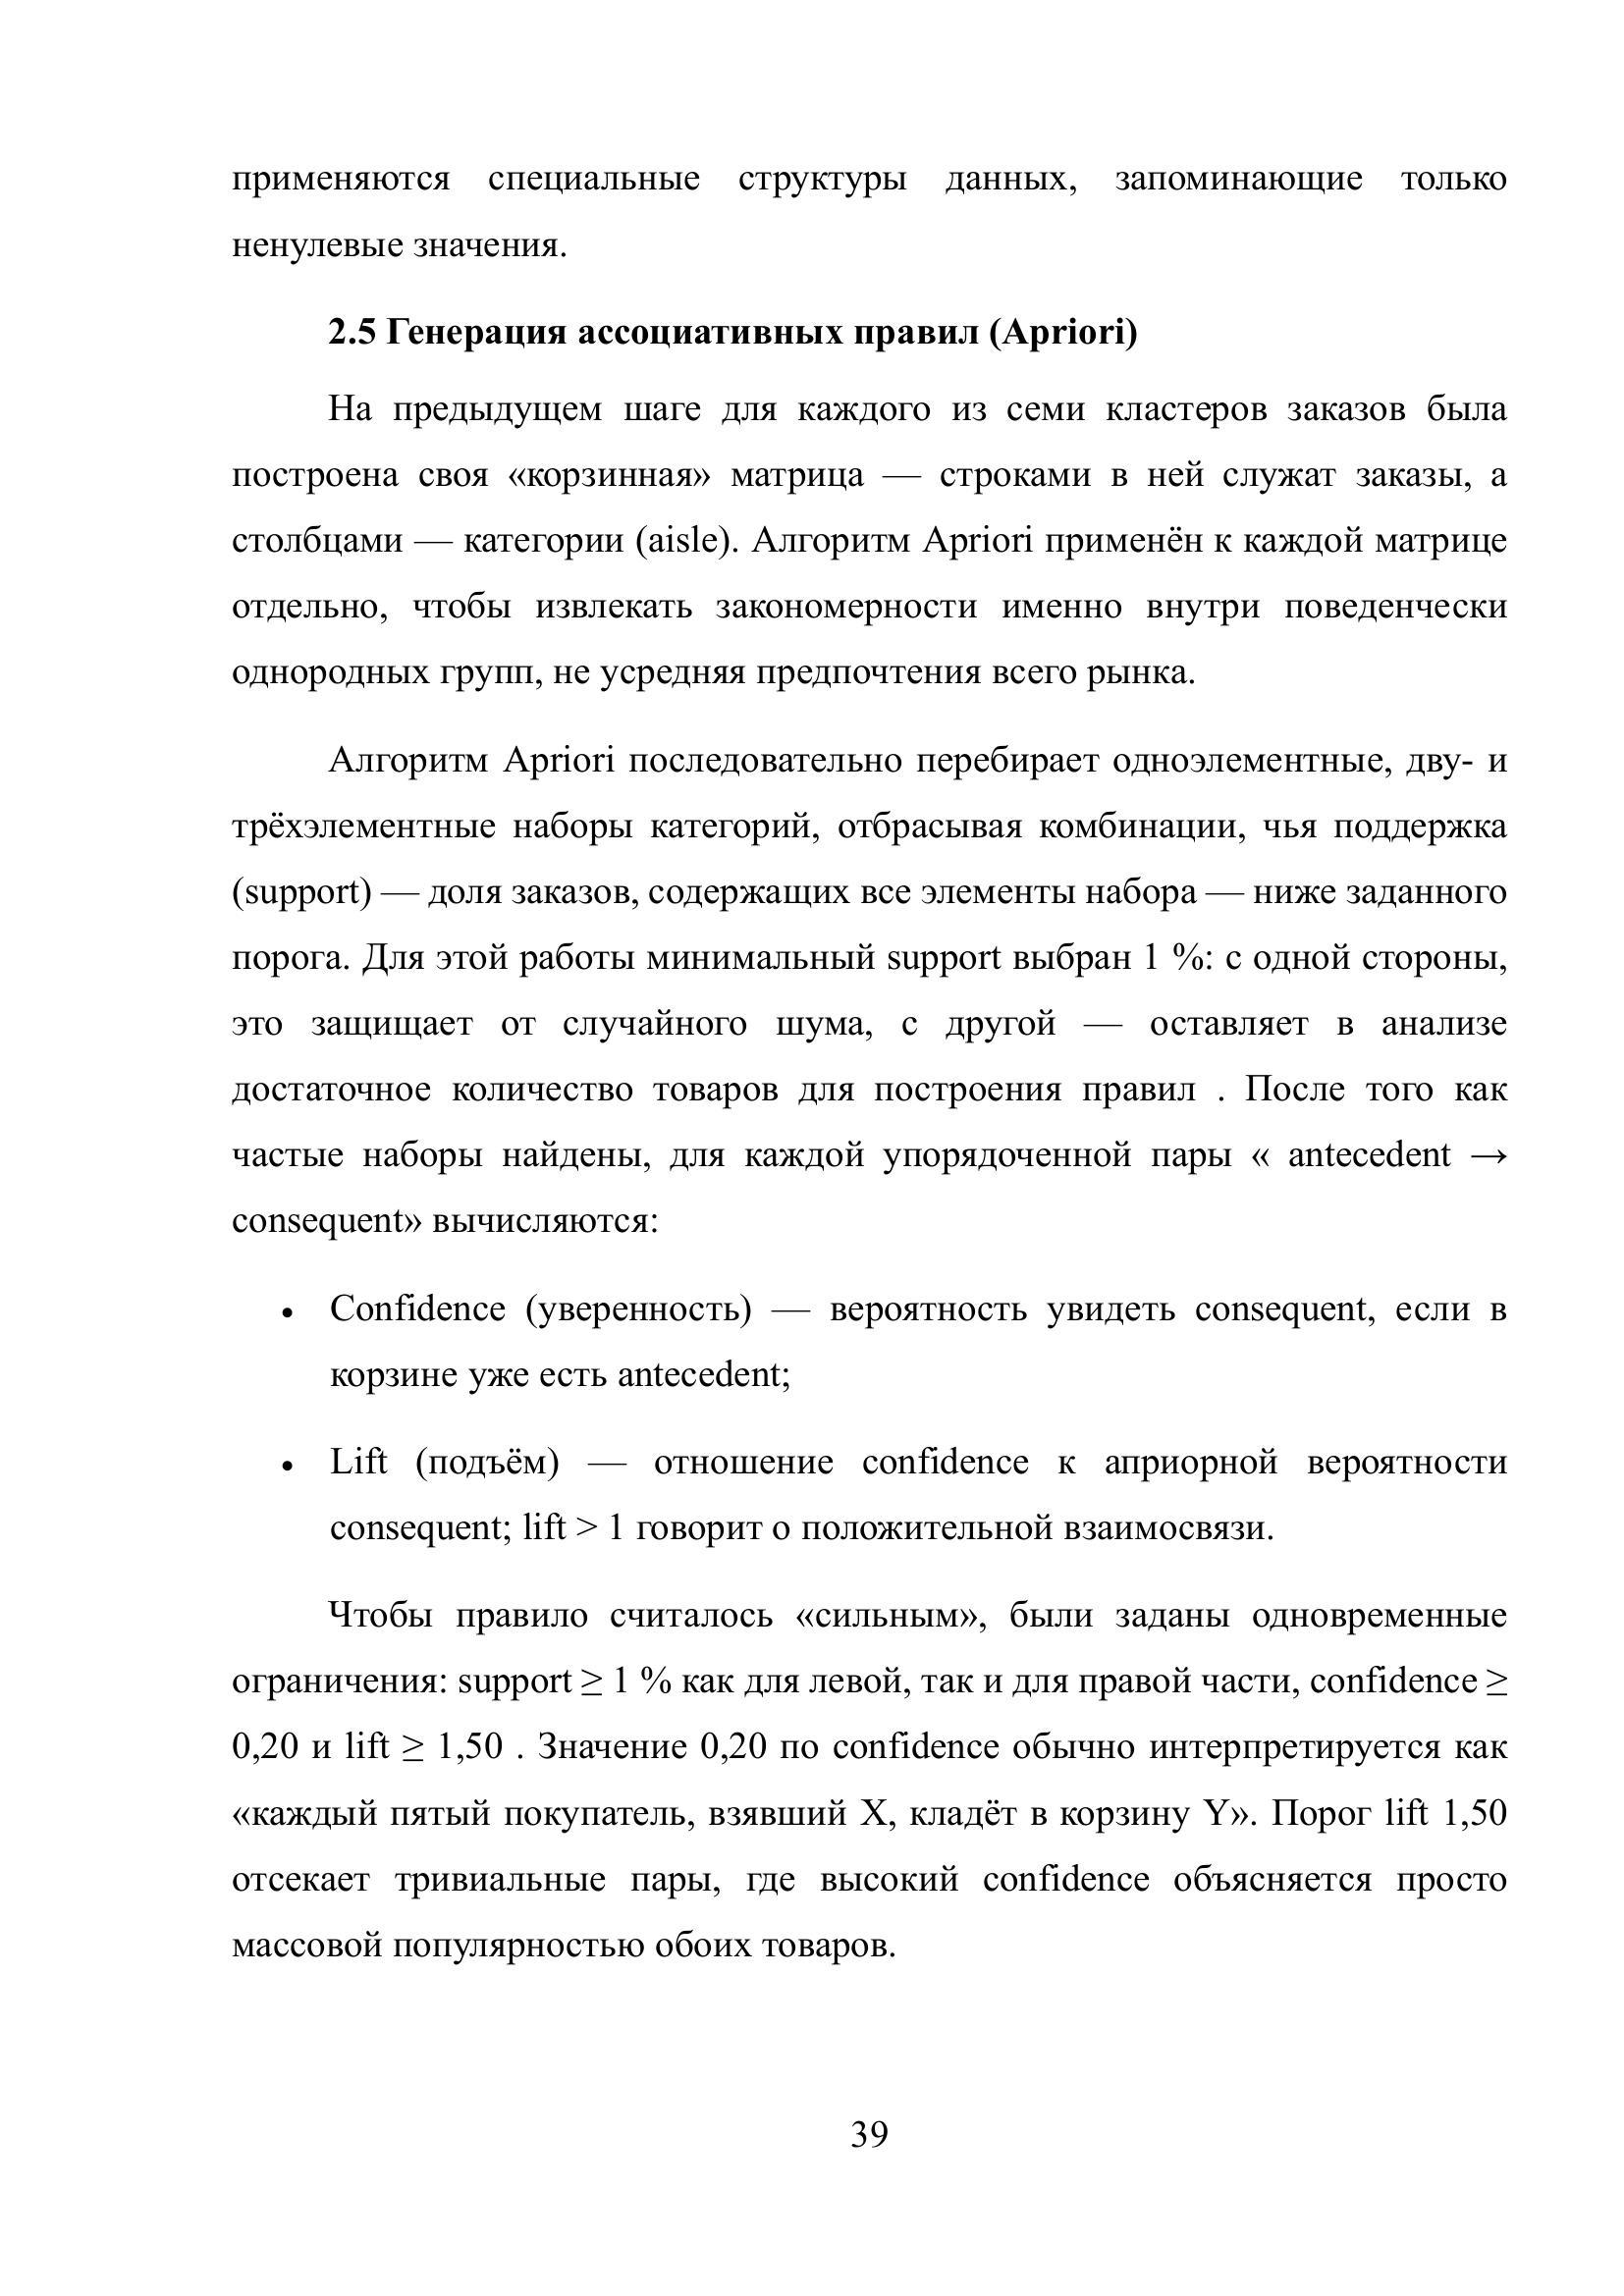


Ответ на «Как рассчитать lift»:
Lift (подтёлка) — это зависимость между товарами. Lift сравнивает фактическиую вероятность покупки товаров А и B с вероятностью их независимого появления в заказах. Lift > 1 означает положительную зависимость между товарами.

Формально:

Lift(A → B) = Confidence(A → B) / Support(B)


📦 Итоговый объединённый ответ:
 ## Алгоритм Apriori: Обнаружение Ассоциативных Правил в Данных

Алгоритм Apriori – это эффективный метод для обнаружения ассоциативных правил в транзакционных данных, таких как данные о покупках клиентов.  Он основан на идее, что часто встречающиеся наборы товаров (itemsets) в данных указывают на потенциальные связи между ними.  Алгоритм Apriori ищет закономерности, которые могут быть использованы для прогнозирования, персонализации и принятия решений в различных областях, включая розничную торговлю, маркетинг и медицину.

**Принцип работы алгоритма Apriori** заключается в итеративном построении и анализе наборов товаров, начиная с наиболее ч

In [5]:
user_q = "описание алгоритма Apriori и как рассчитать support, confidence и lift" #это однозначно есть в тексте и этот запрос выполняется пректрасно
# user_q = "что такое молоко" #в тексте мелькает пример с молоком и в итоге просит уточнить
process_query_with_gemma_vespa(user_q)


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



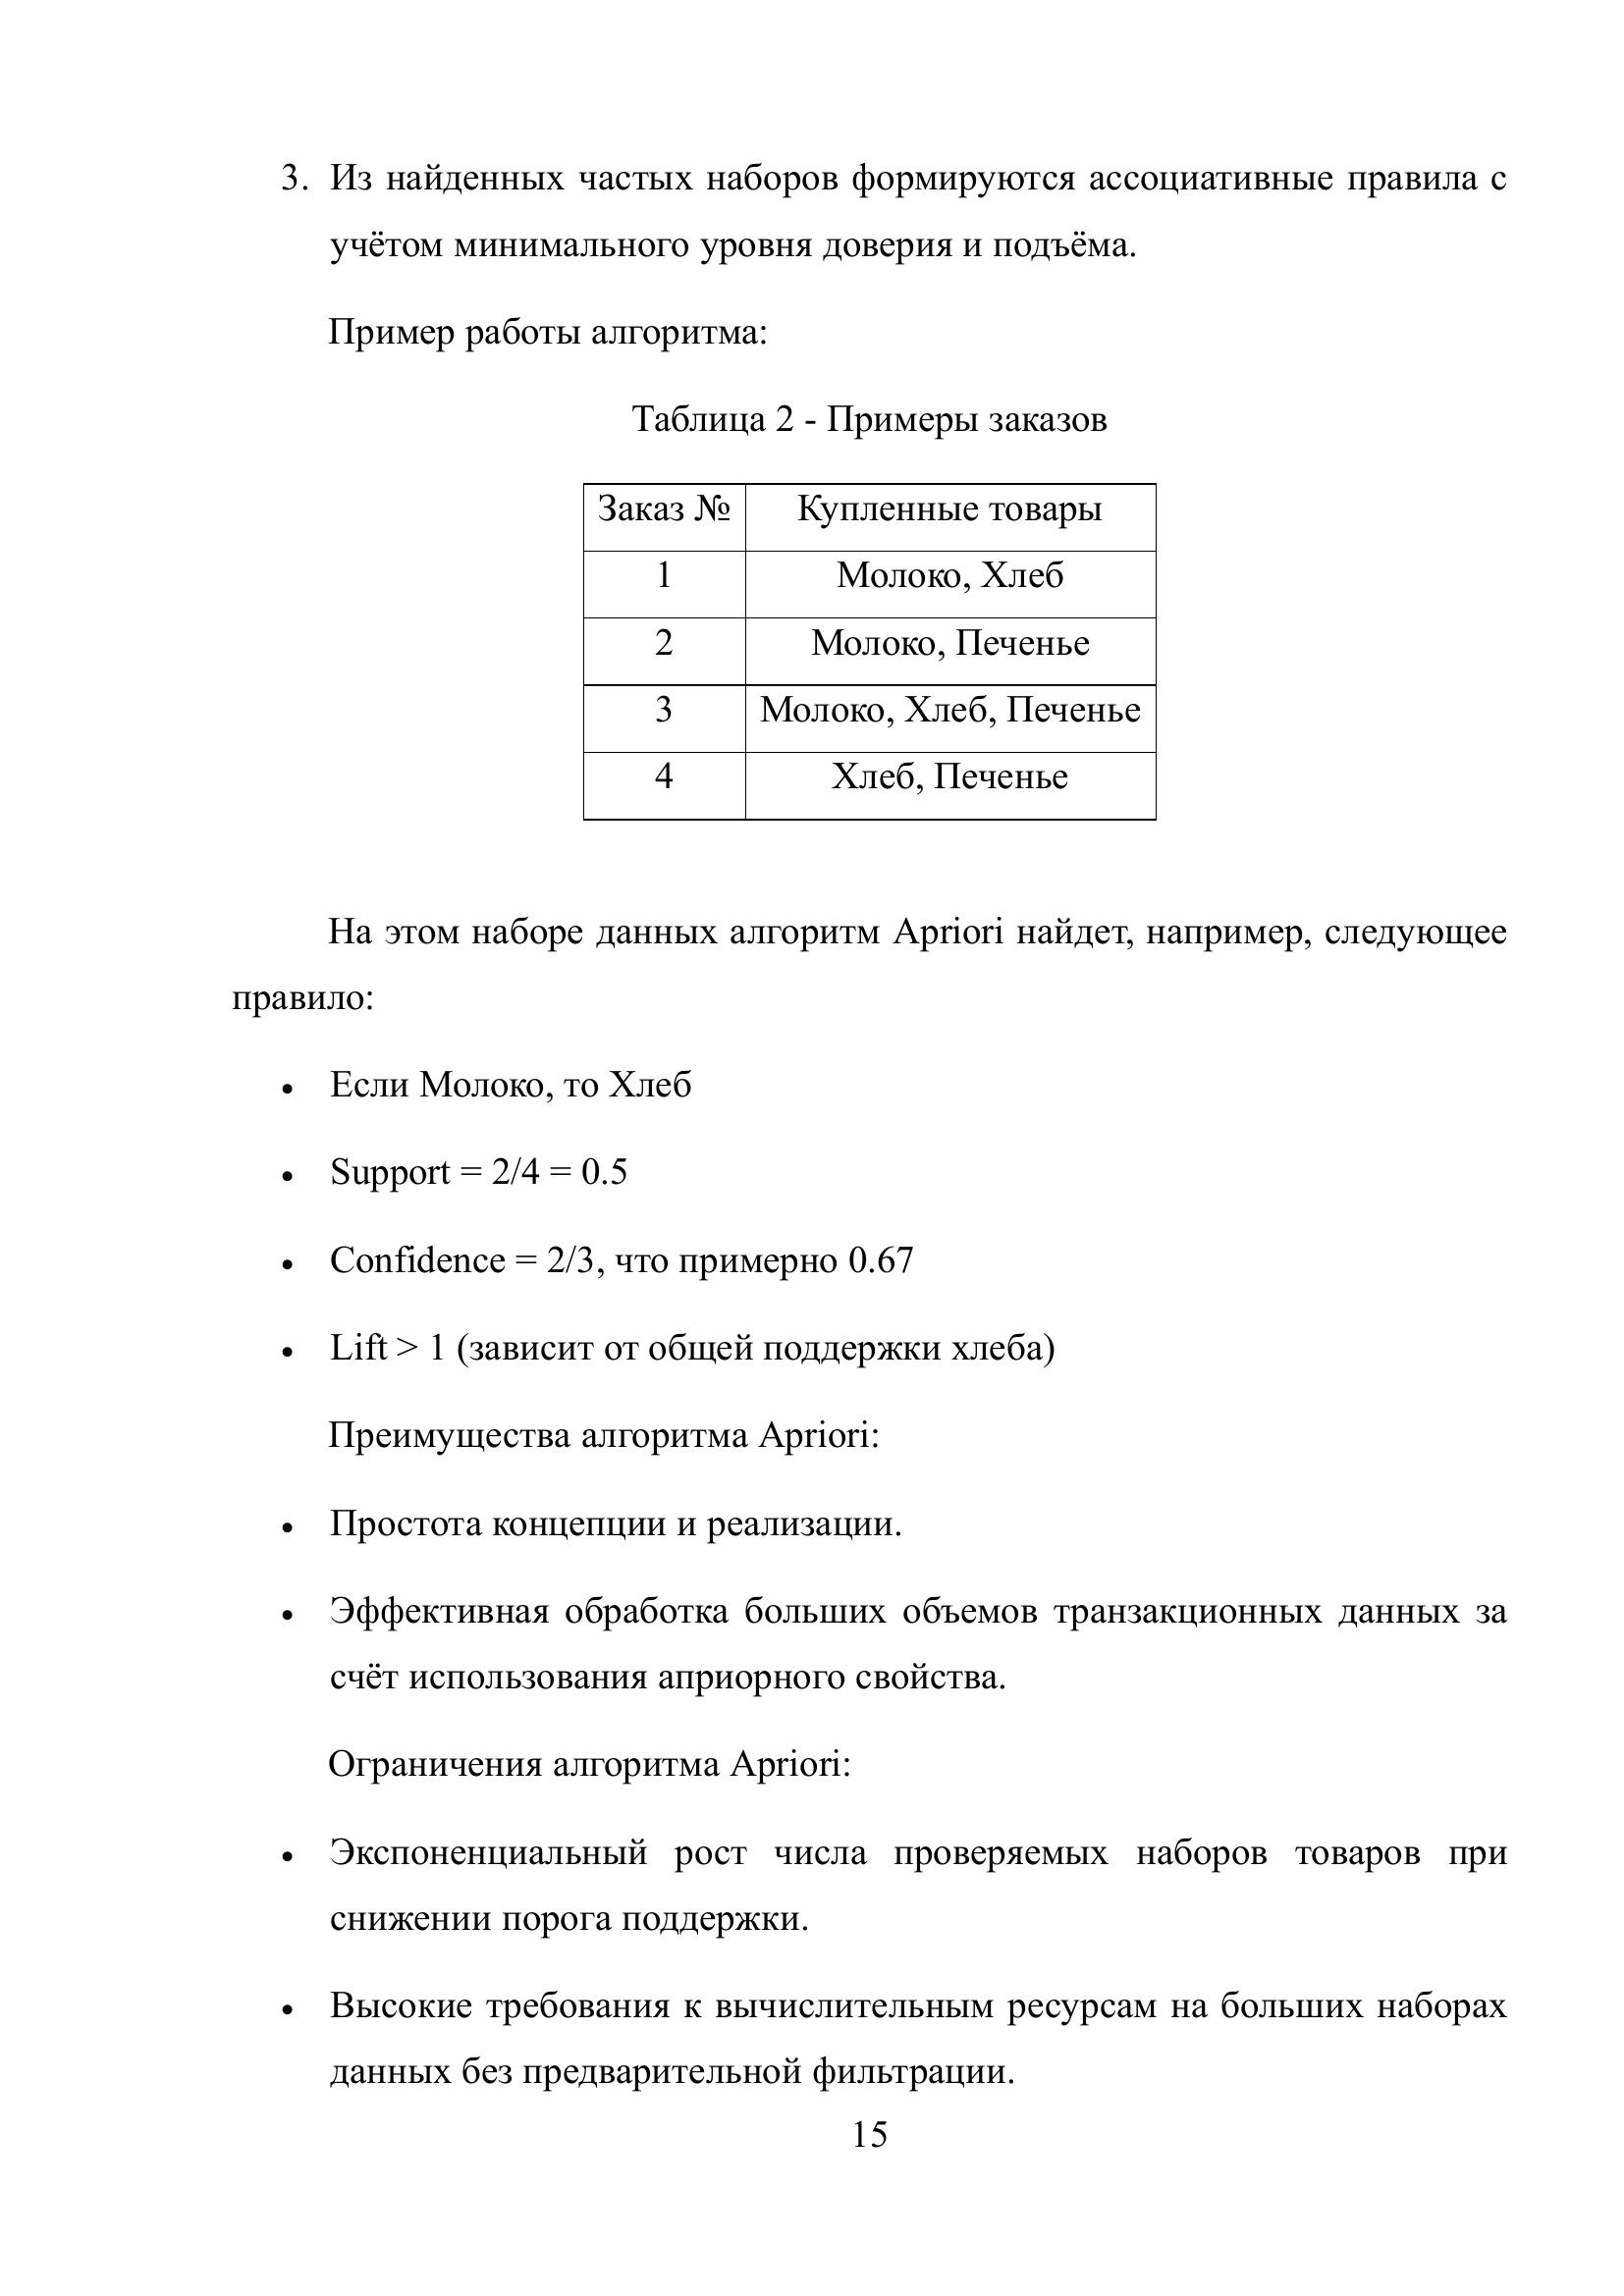
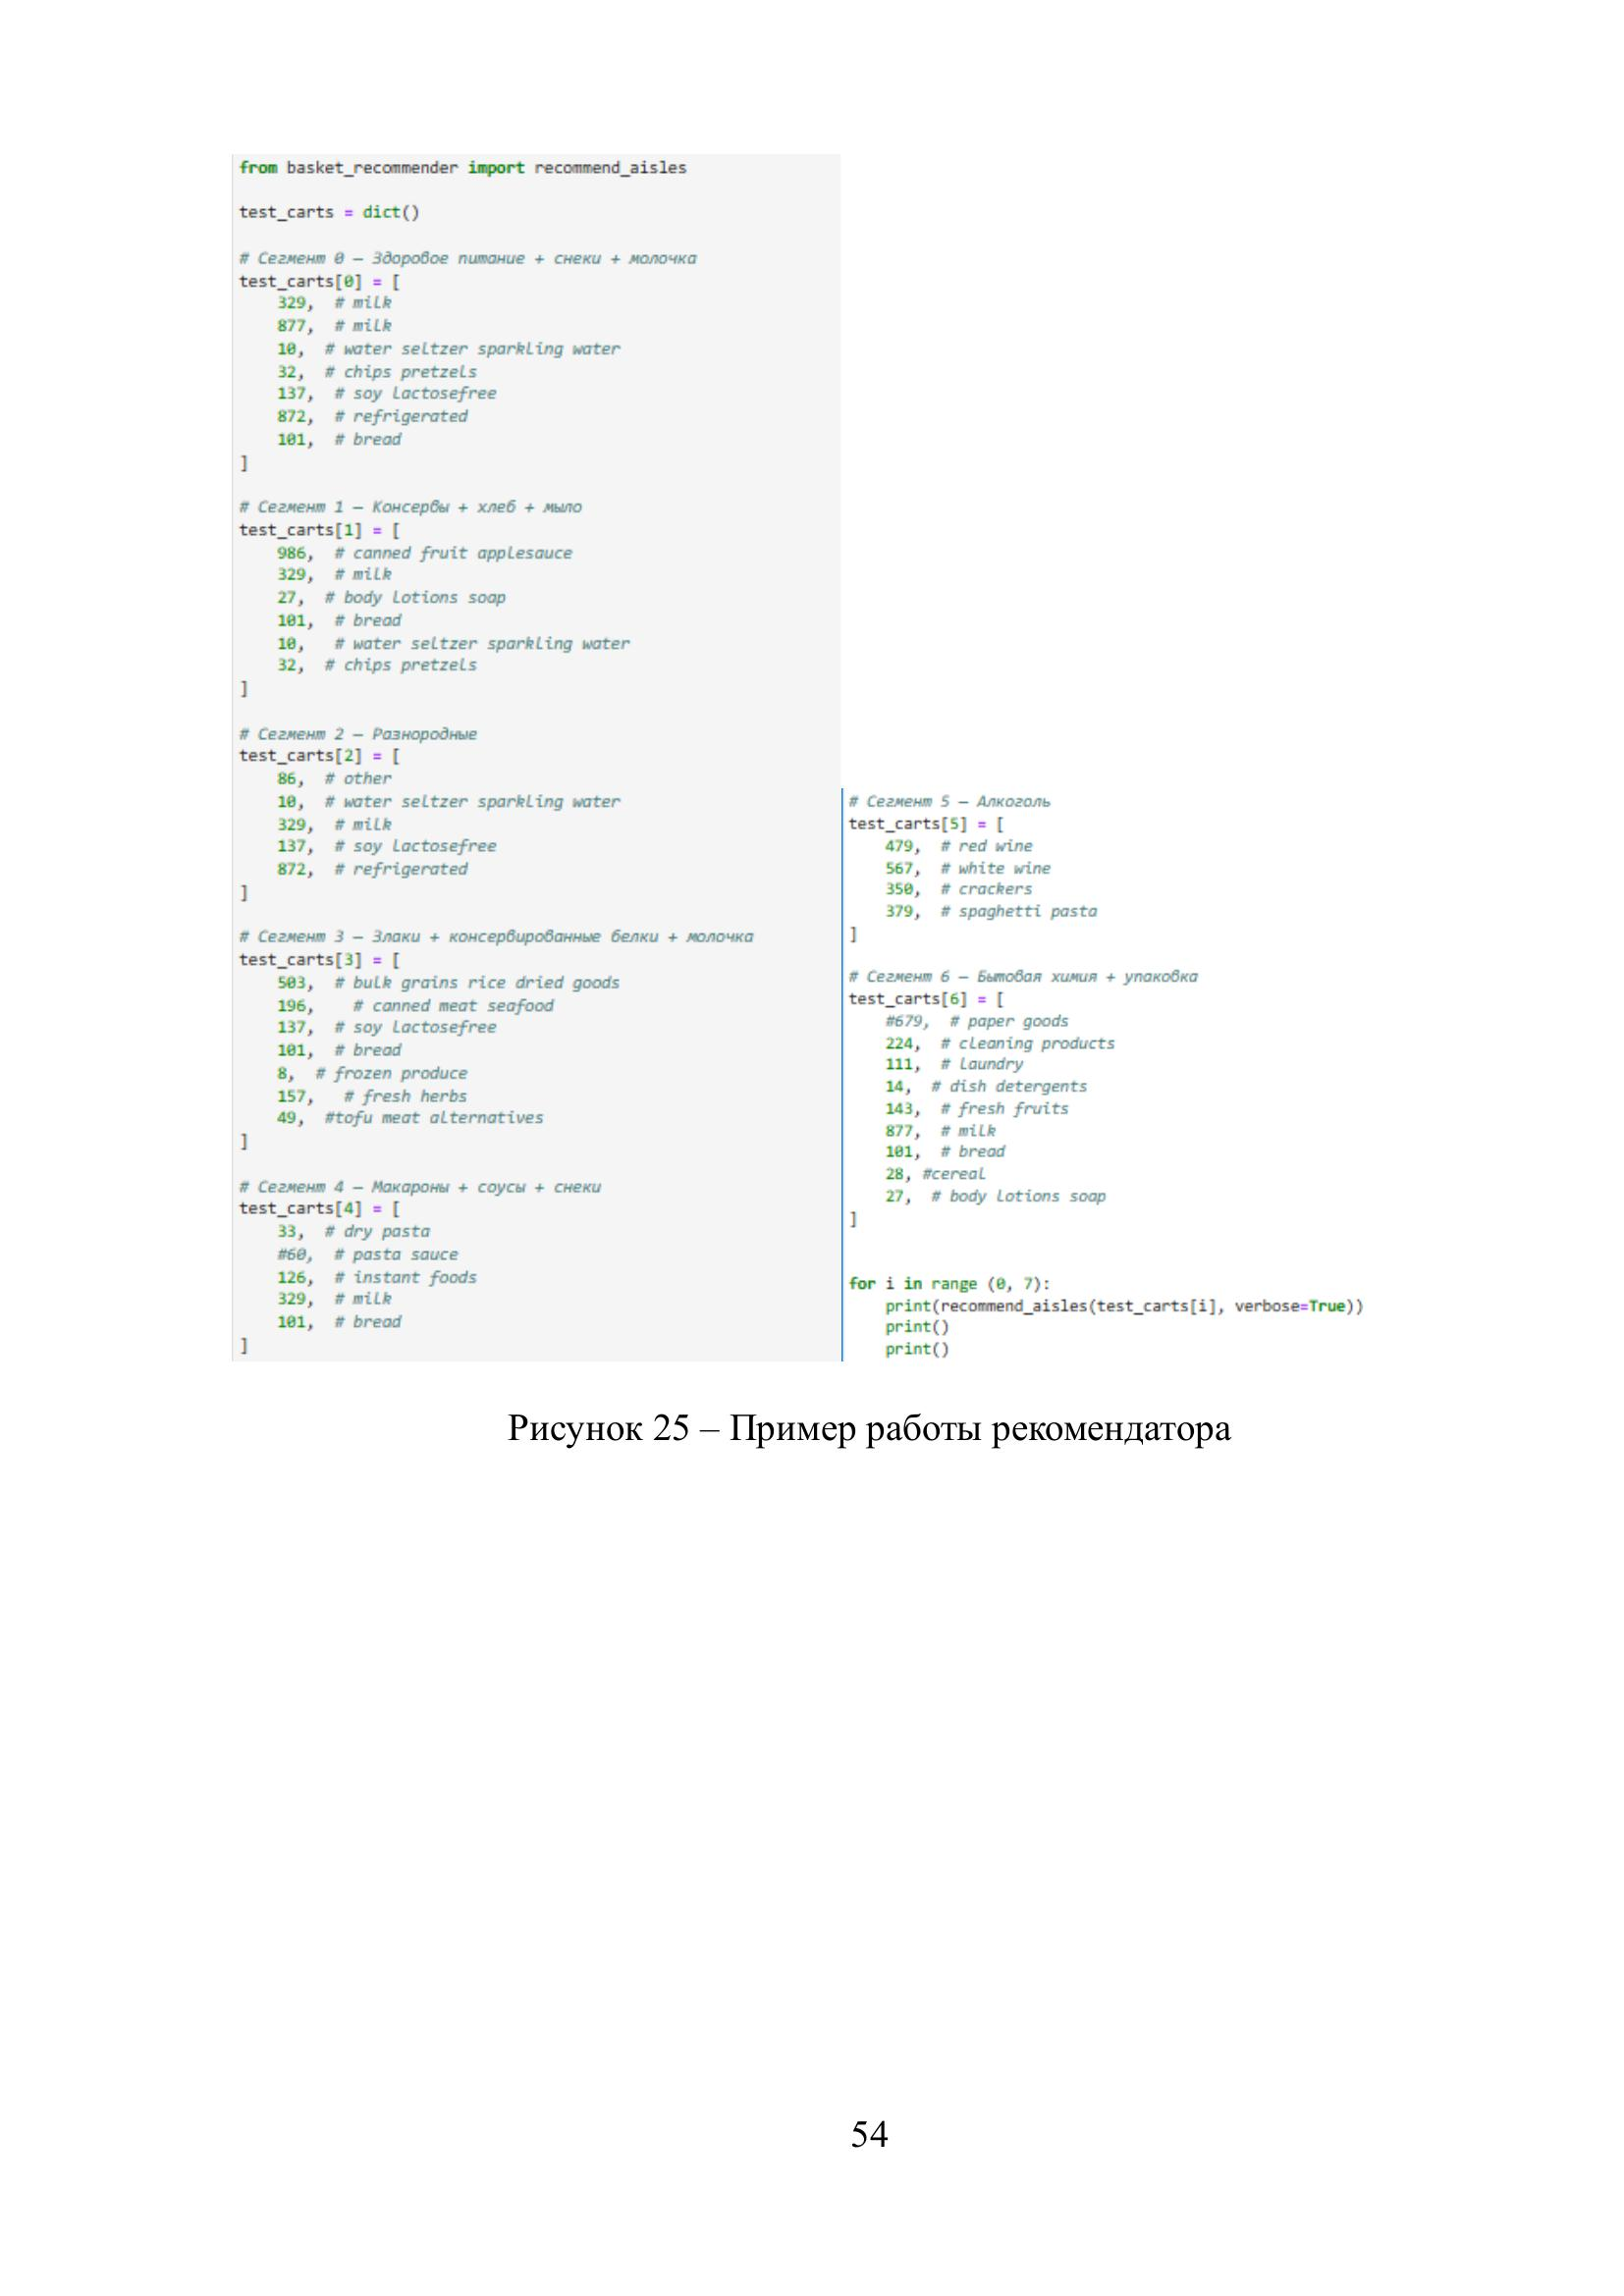
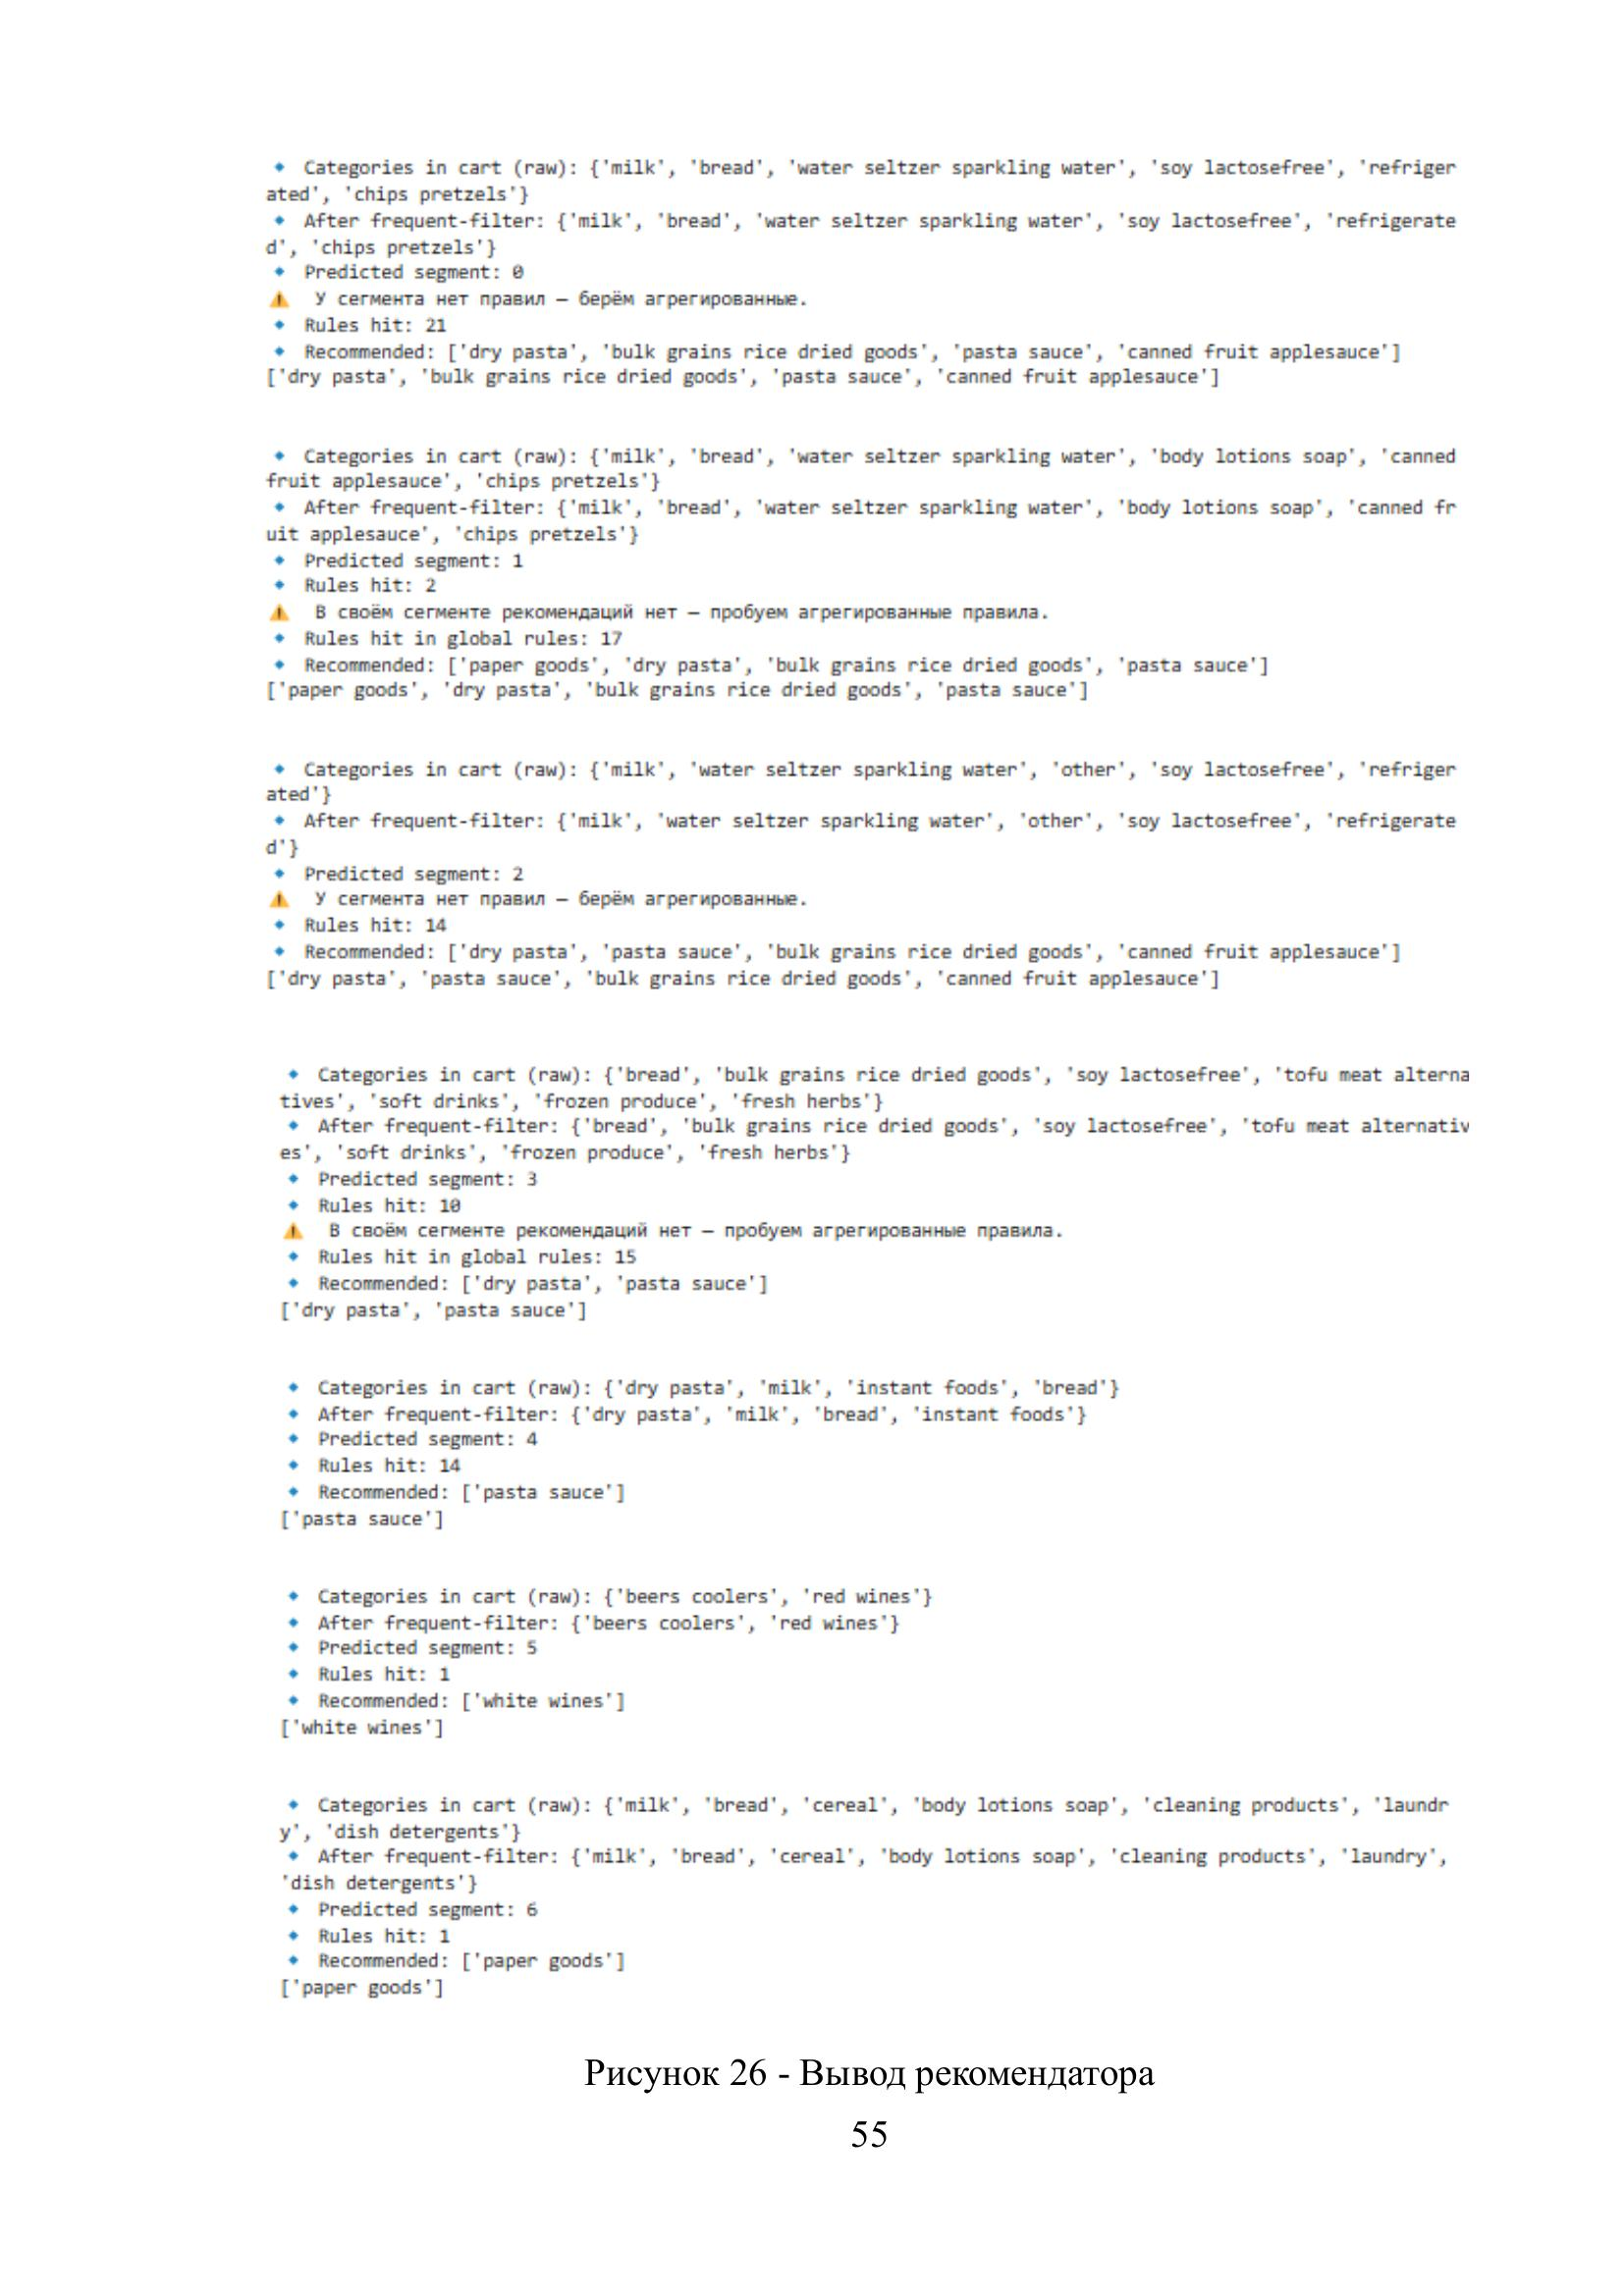

⚠ Gemma уточняет: молоко



Пожалуйста, уточните запрос:  пример использования ассоциативных правил с молоком


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



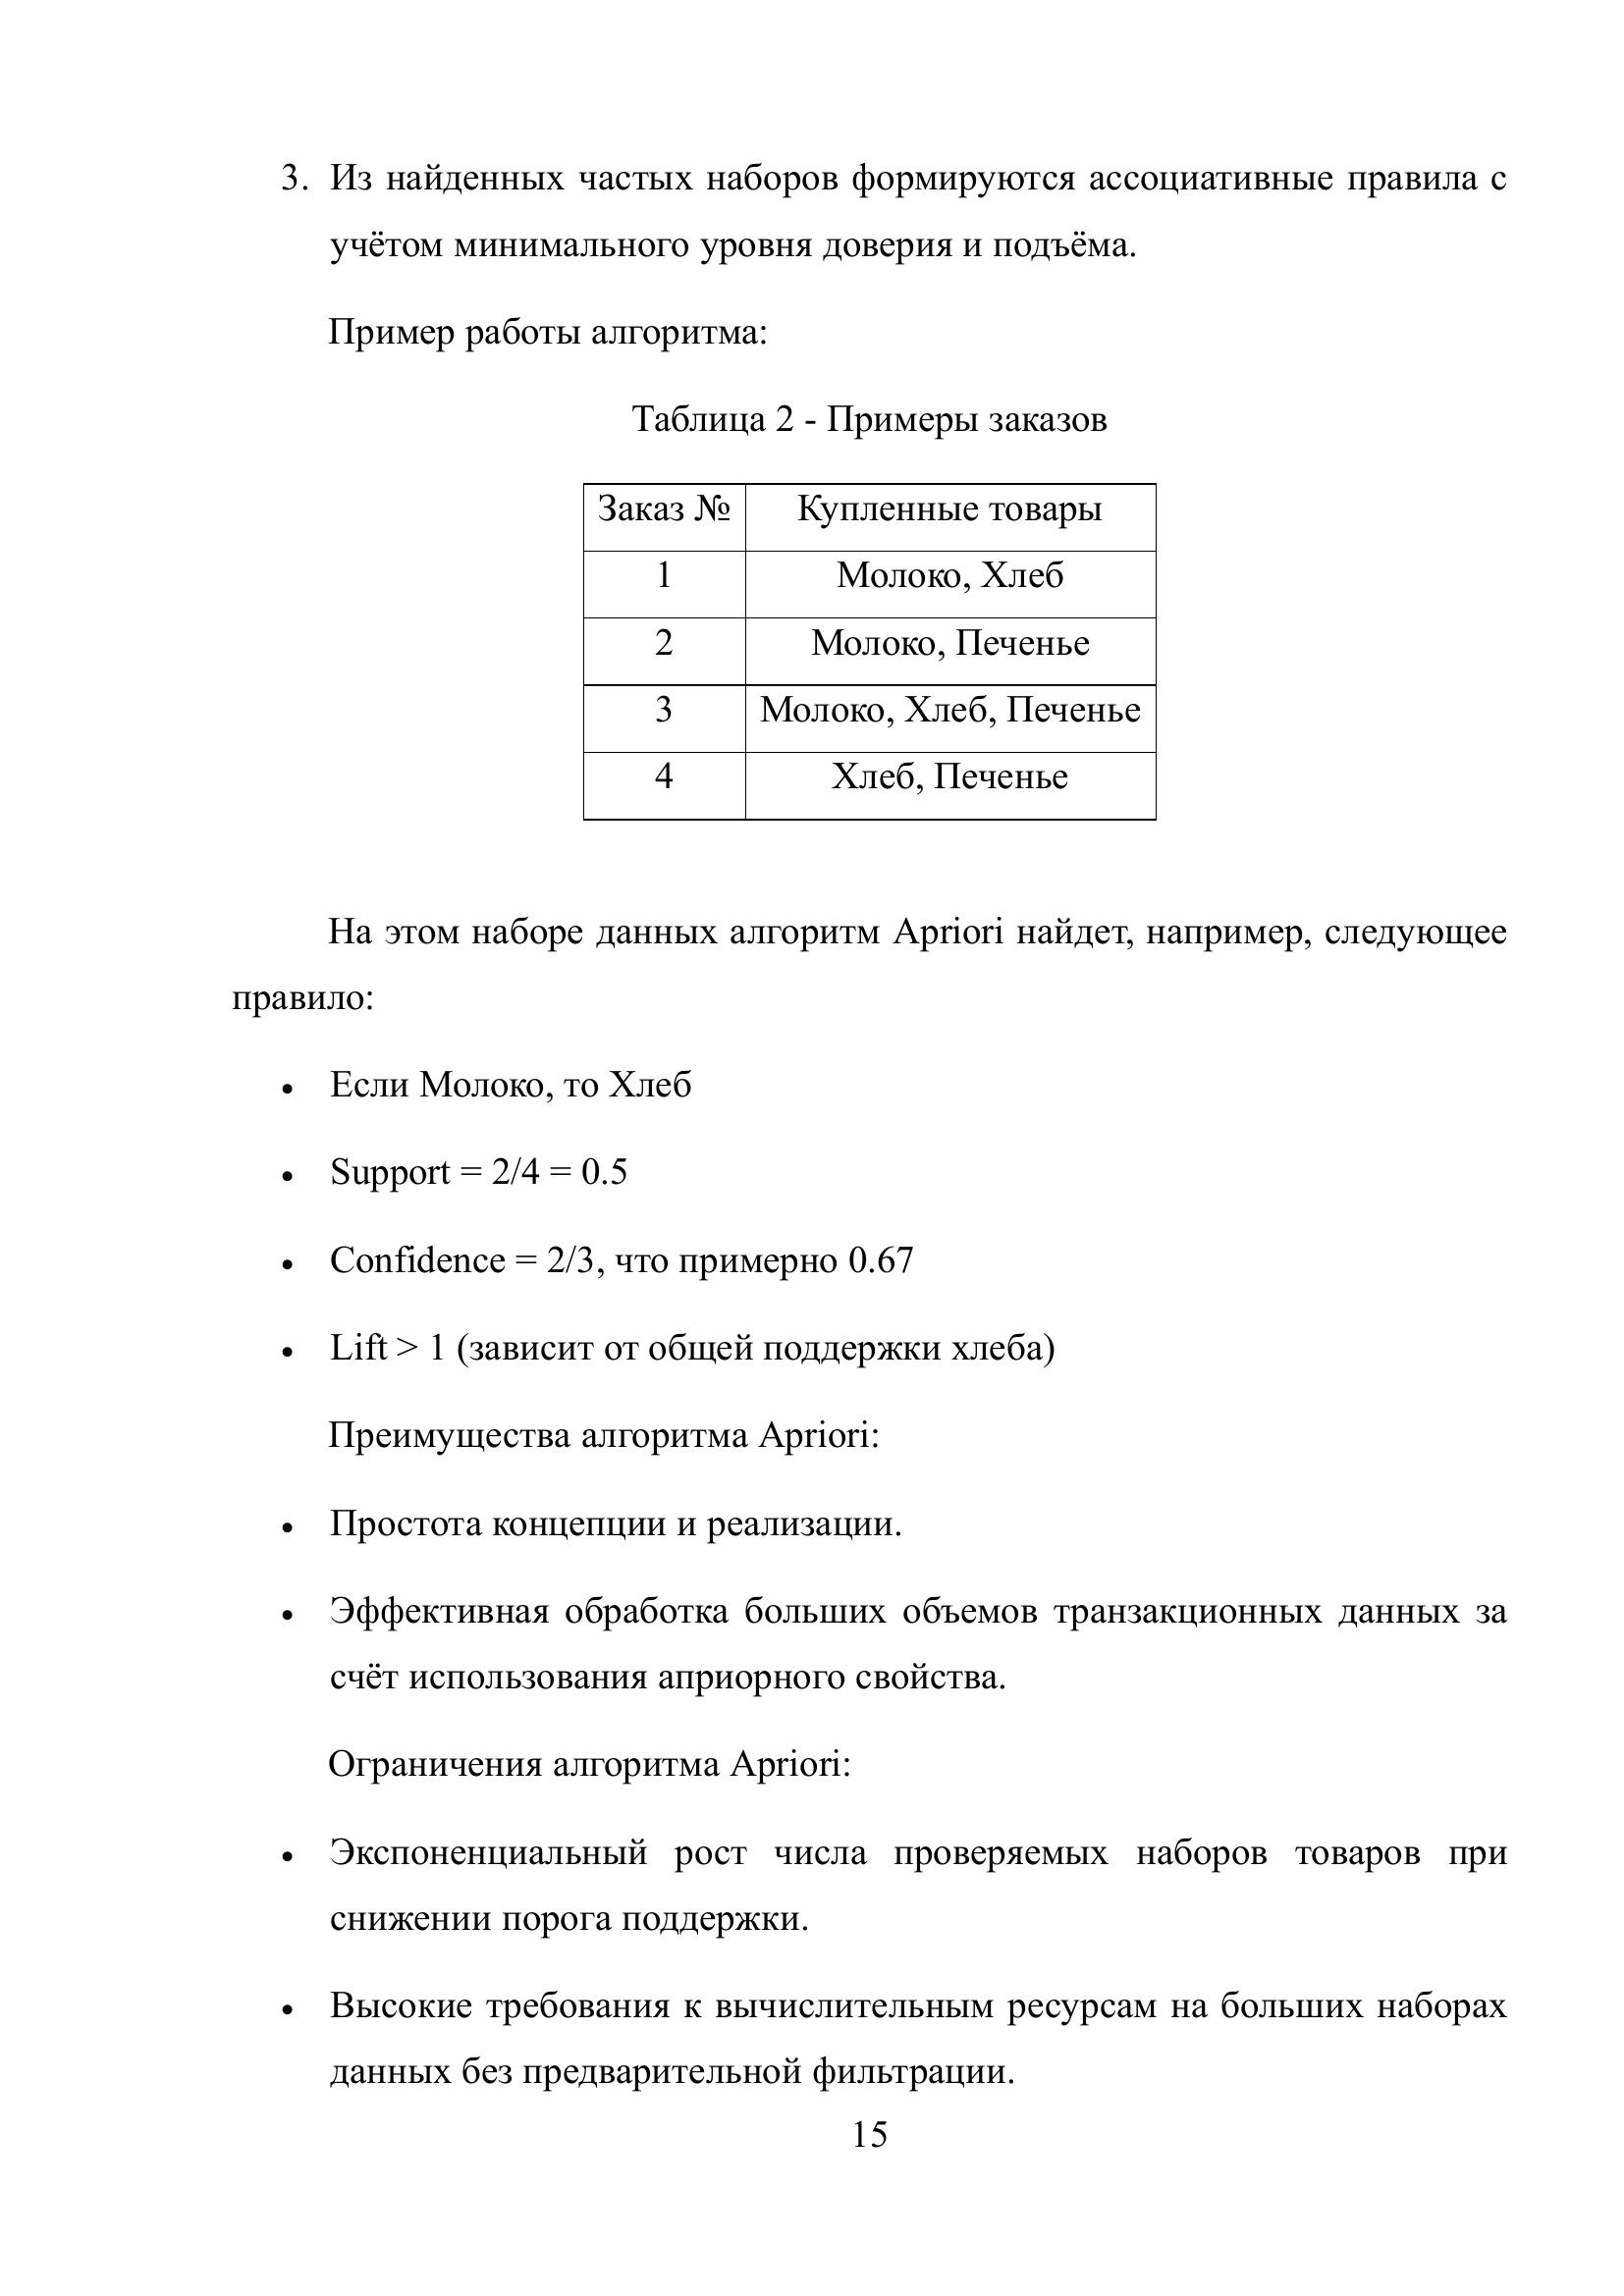
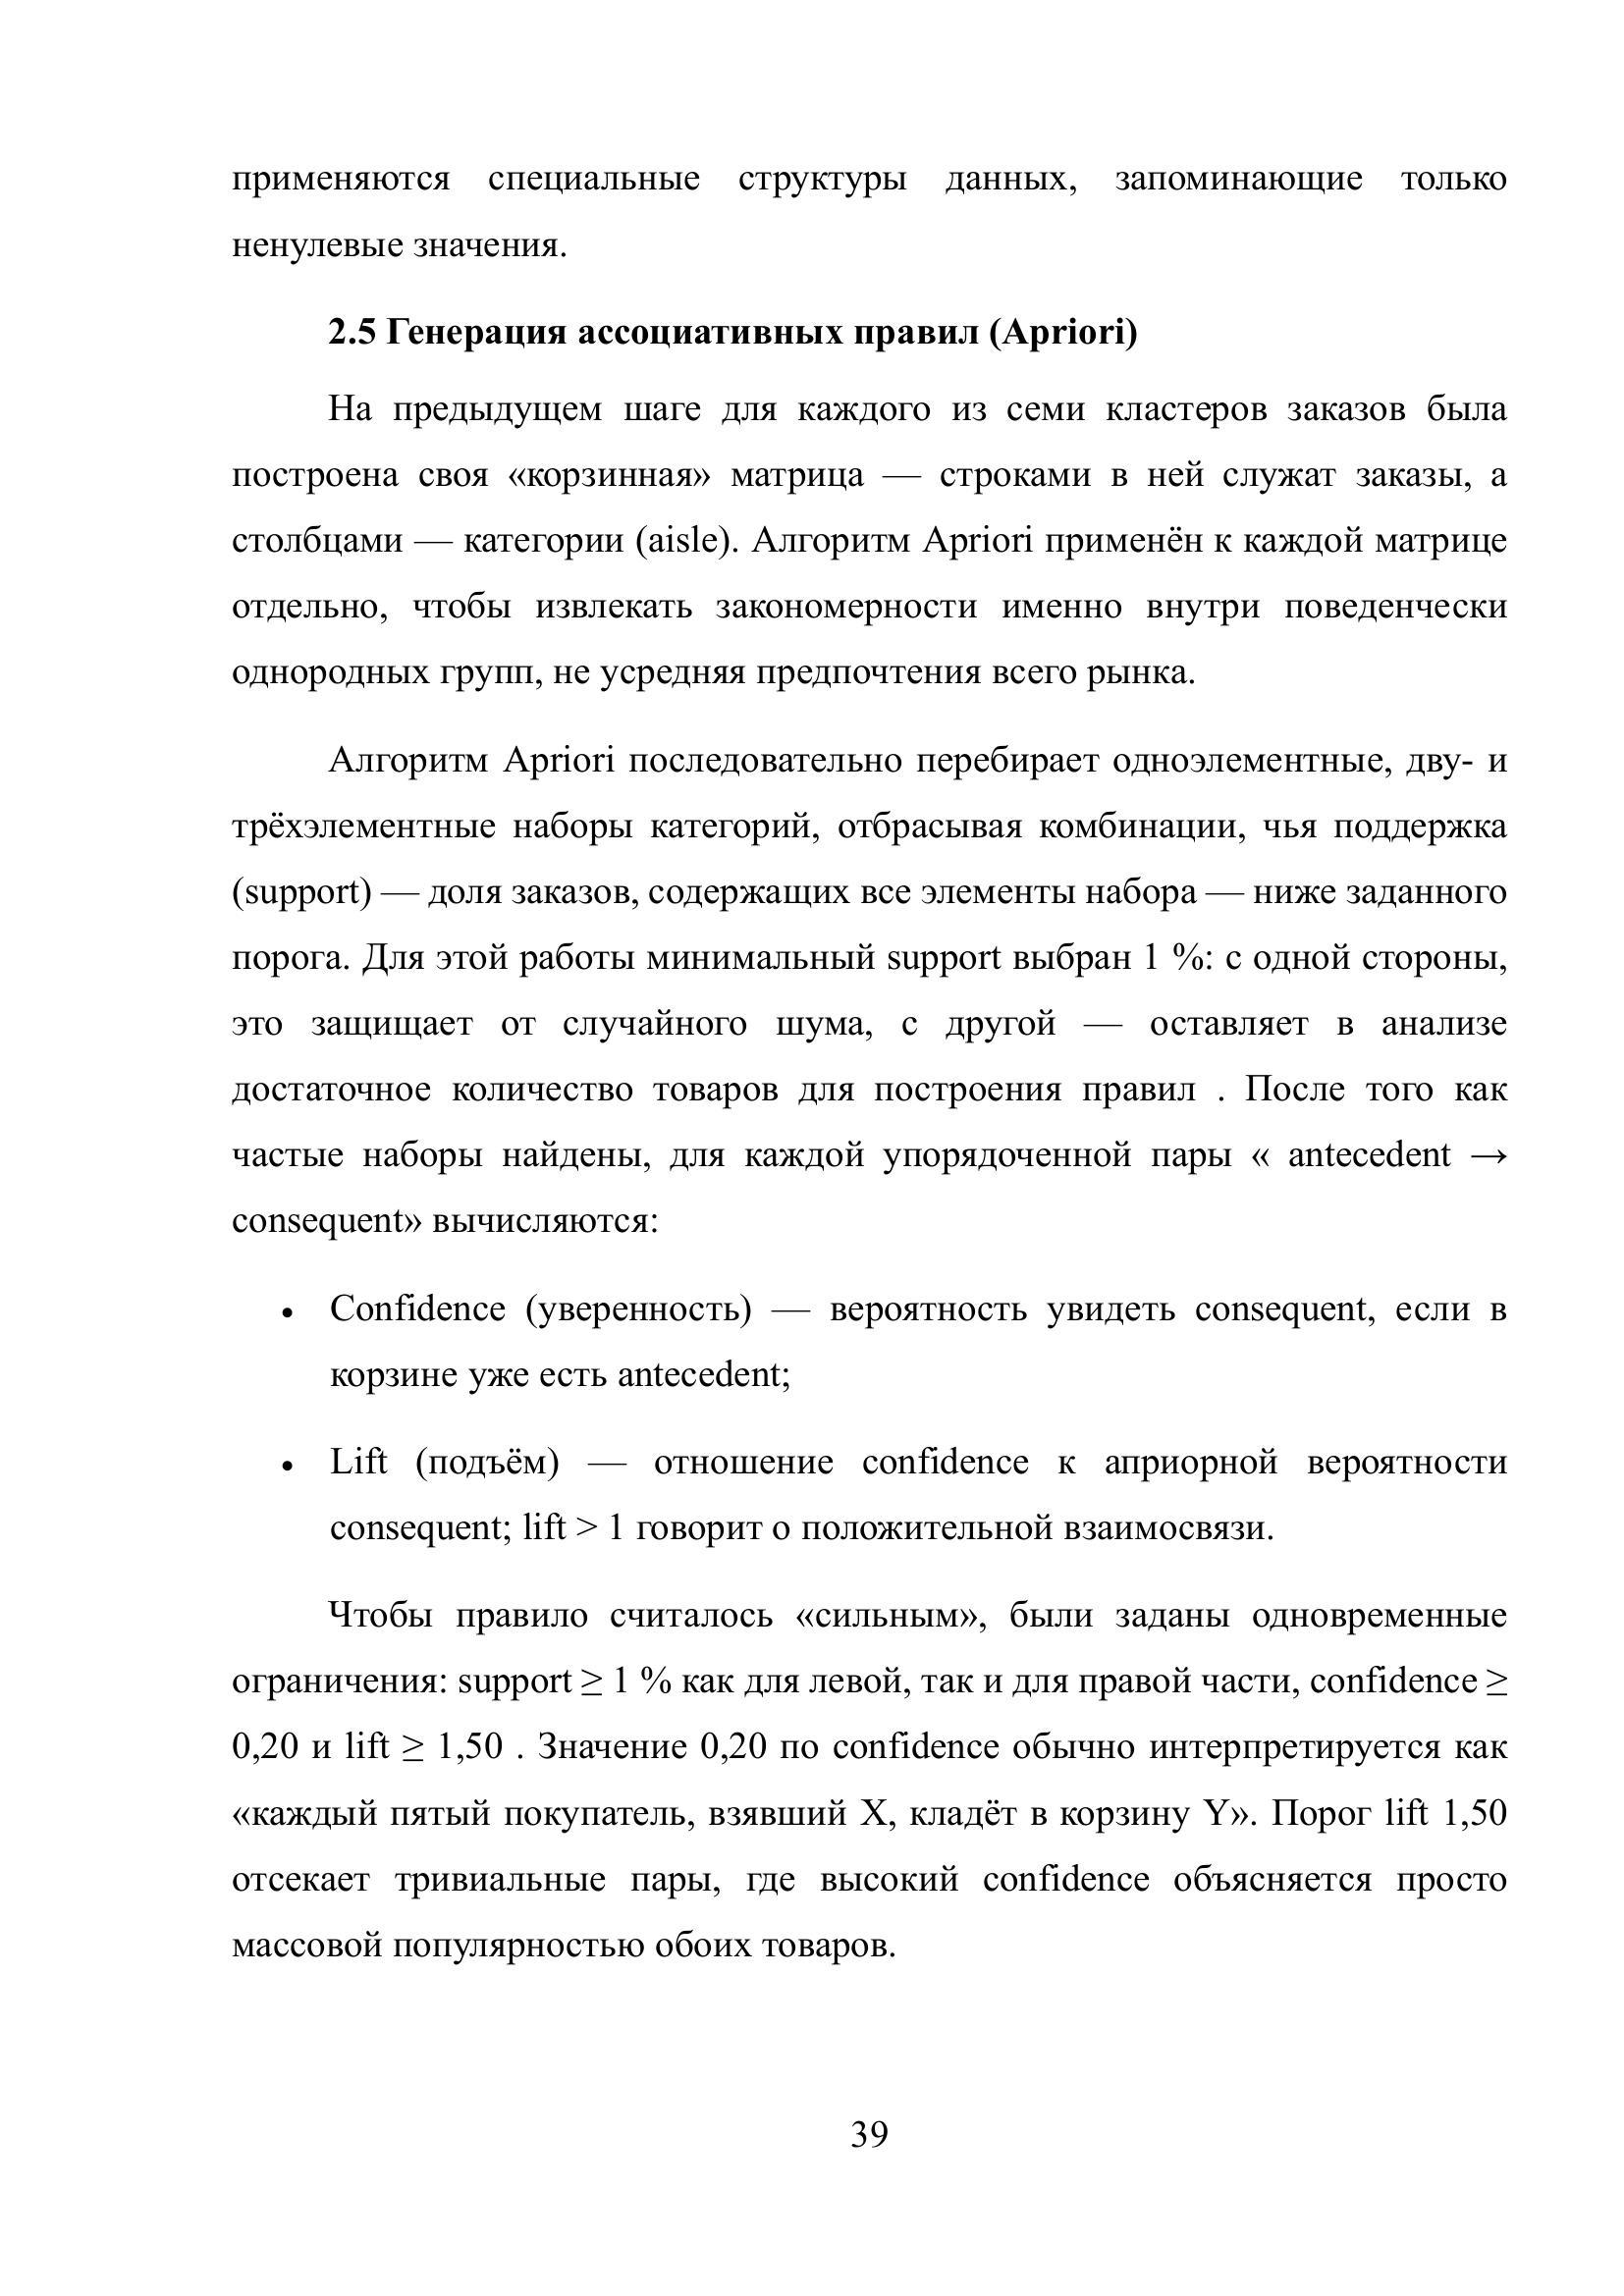
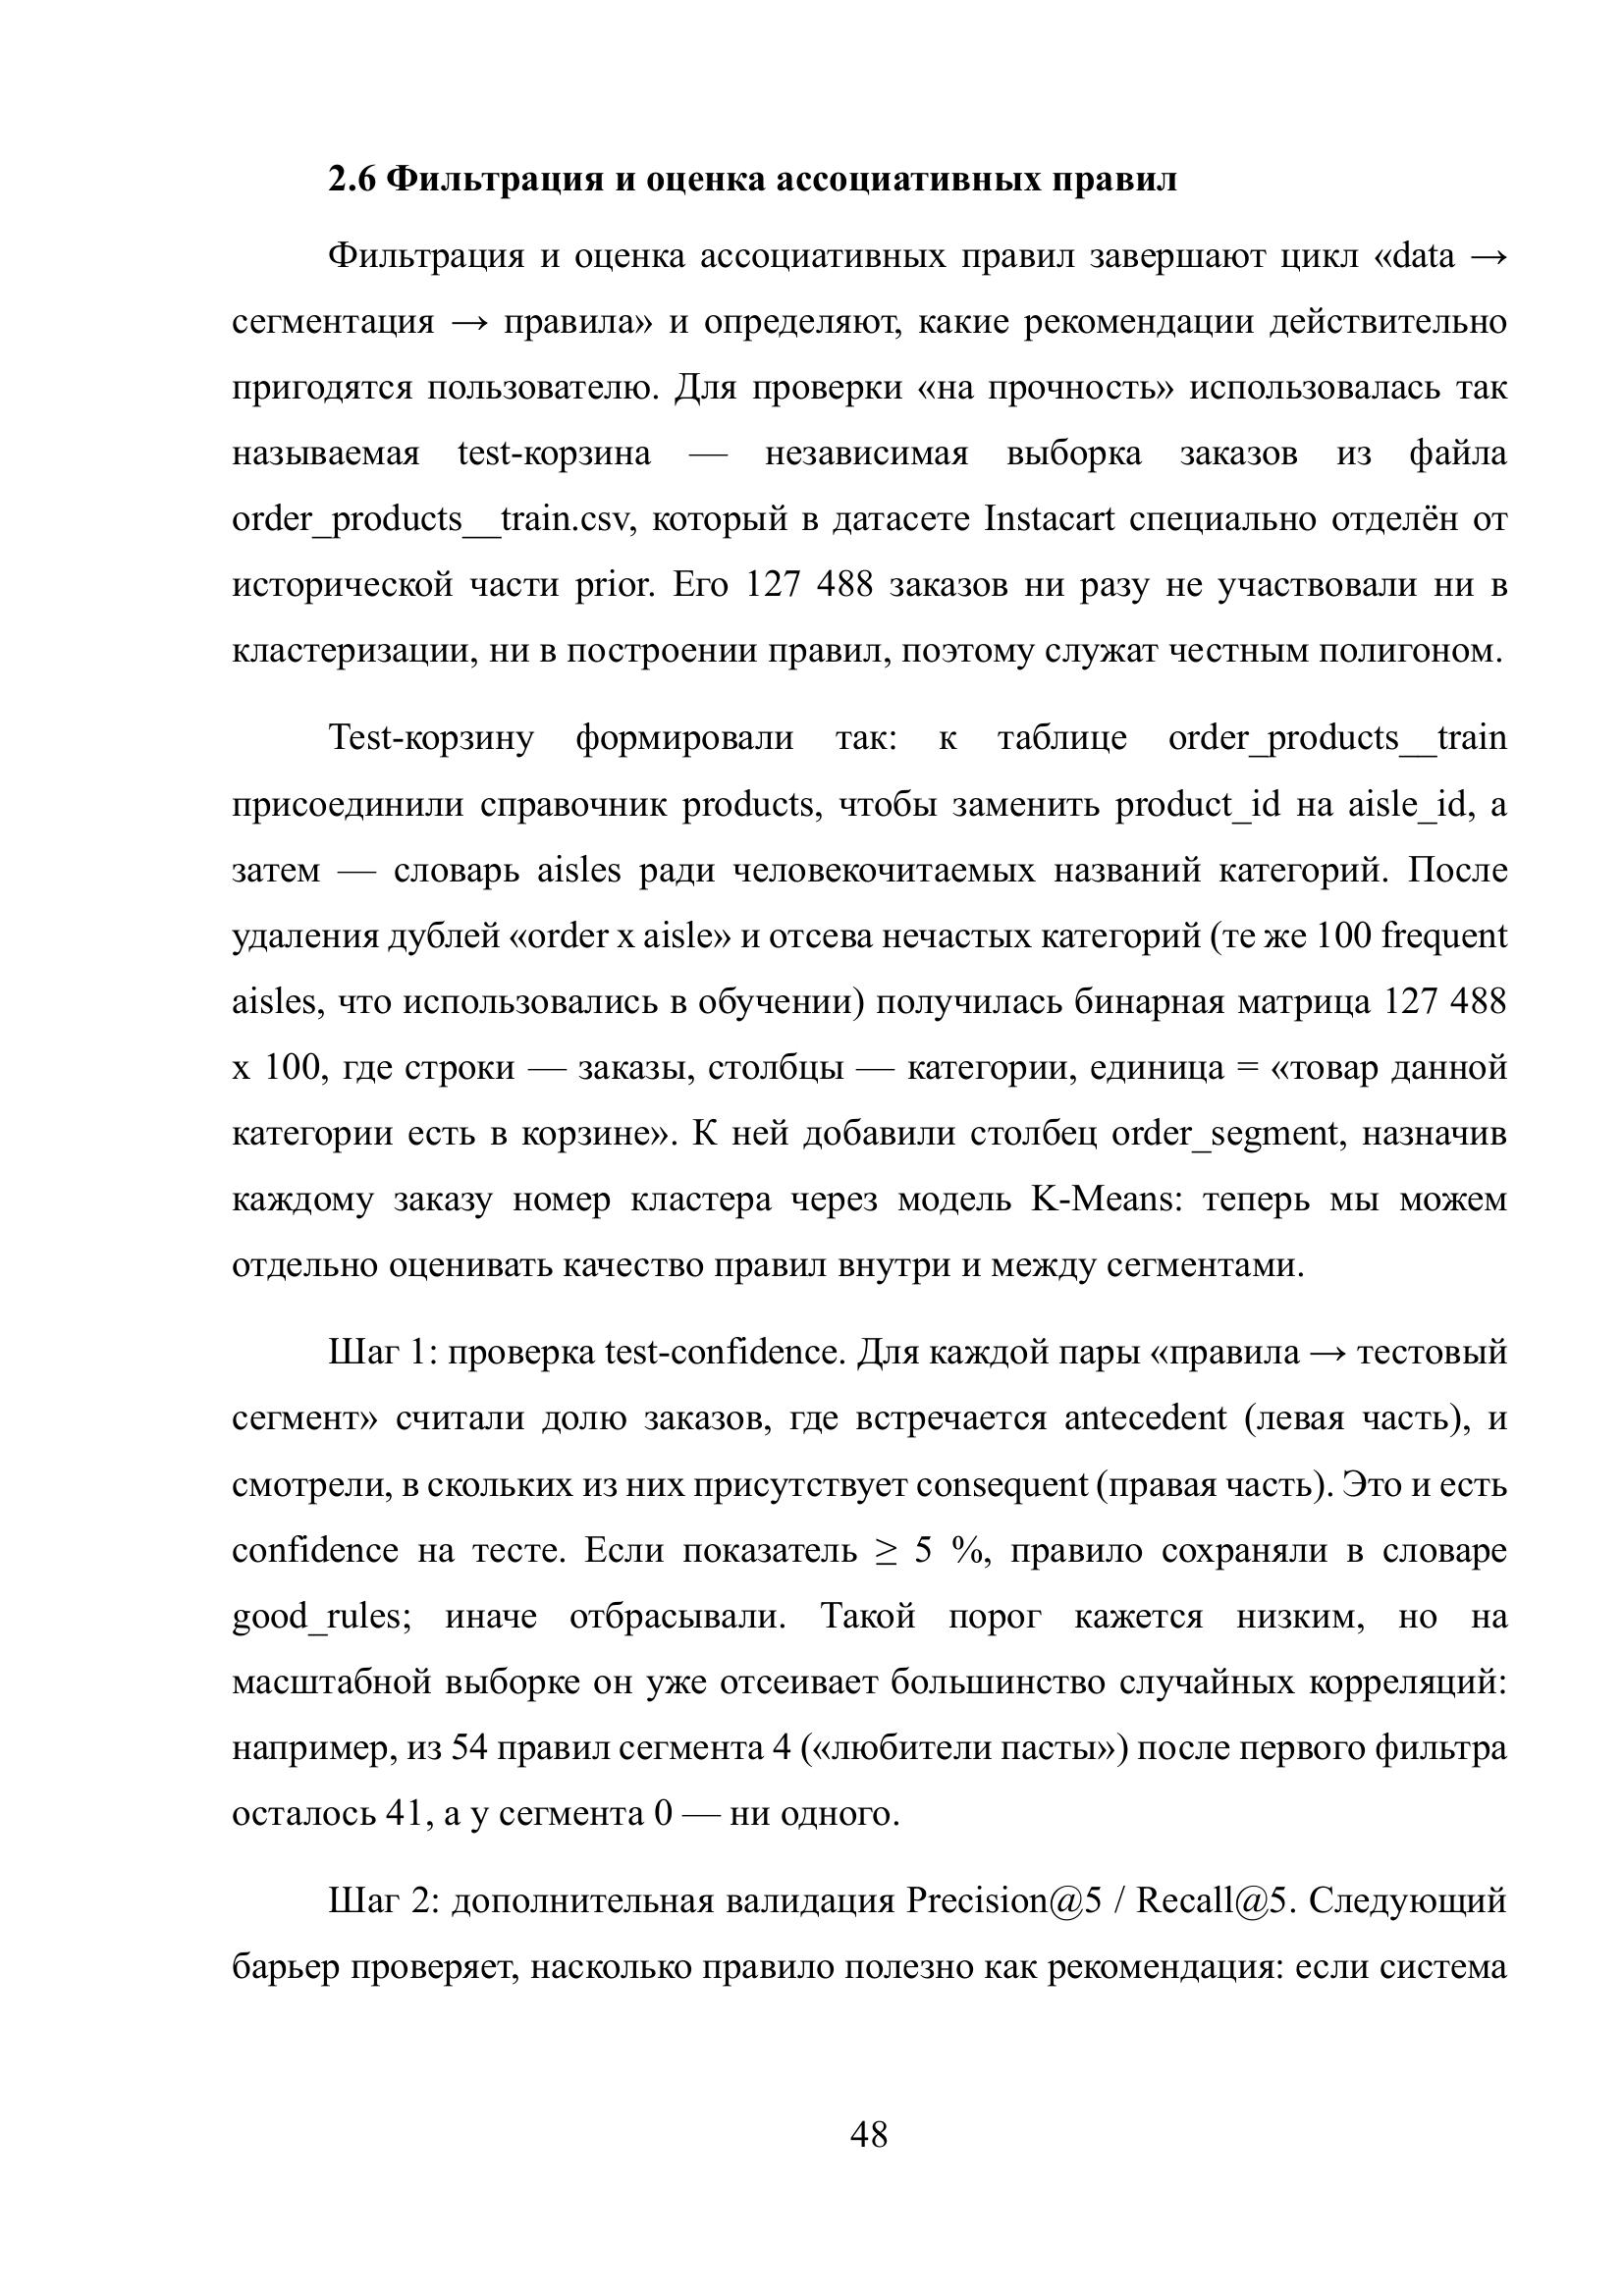


Ответ на «пример использования ассоциативных правил с молоком»:
Если молоко, то хлеб.


📦 Итоговый ответ:
 Ответ на «пример использования ассоциативных правил с молоком»: Если молоко, то хлеб.


In [6]:
# user_q = "описание алгоритма Apriori и как рассчитать support, confidence и lift" #это однозначно есть в тексте и этот запрос выполняется пректрасно
user_q = "что такое молоко" #в тексте мелькает пример с молоком
process_query_with_gemma_vespa(user_q)
